# 1. Setup environment

In [ ]:
# Install packages
! pip install -q tensorflow transformers datasets evaluate seqeval tf-keras PyGithub pympler

In [ ]:
# Import GPU support library
from numba import cuda

# Import file handling libraries
import os
import sys
import json
import pickle
import base64

# Import GitHub integration libraries
from github.MainClass import Github
import requests

# Import Google Drive integration libraries
#from google.colab import drive, files

# Import standard and numerical libraries
import numpy as np
import random
import pandas as pd

# Import dataset handling libraries
from datasets import Dataset, load_dataset
from sklearn.model_selection import train_test_split

# Import TensorFlow and Keras libraries
import tensorflow as tf
from transformers import create_optimizer
from transformers import BertConfig
from transformers import AutoTokenizer, BertTokenizer, BertTokenizerFast
from transformers import DataCollatorForTokenClassification, DataCollatorWithPadding
from transformers import AutoModel, TFBertModel, TFAutoModelForTokenClassification, TFBertForTokenClassification

# Import evaluation libraries
import evaluate
from transformers.keras_callbacks import KerasMetricCallback

# Import data analysis and visualization libraries
from collections import Counter
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats

# Import utility libraries
import timeit
from pympler import asizeof
import warnings

In [ ]:
"""# Mount Google Drive for read/write access
drive.mount('/content/drive')"""

# Temporary token for the repo
tk = 'x'

# Establish connection with GitHub
g = Github(tk)

# Load the repo
repo_name = "jspencermorris/datasci266_project"
repo = g.get_repo(repo_name)

# Get the scoring scripts
file_list = repo.get_contents("utils")
script_paths = [file.path for file in file_list]

# Bash script to make the folder for utilities and specify it as a system path
! mkdir -p /content/datasci266_project/utils

# Download and save the scripts
for script_path in script_paths:
    file_content = repo.get_contents(script_path).decoded_content.decode('utf-8')
    file_name = os.path.basename(script_path)
    with open(f'/content/datasci266_project/utils/{file_name}', 'w') as file:
        file.write(file_content)

# Verify that the files have been copied
! ls /content/datasci266_project/utils/

# Add the new directory to the python path
sys.path.append('/content/datasci266_project/utils')

# Import evaluation libraries
import compute_MCC
import compute_seqeval


compute_MCC.py	compute_seqeval.py  __pycache__


# 2. Define helper functions

In [ ]:
# Function to reset Keras Session
def reset_keras():
    sess = tf.compat.v1.keras.backend.get_session()
    tf.compat.v1.keras.backend.clear_session()
    sess.close()
    sess = tf.compat.v1.keras.backend.get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

    device = cuda.get_current_device()
    device.reset()

In [ ]:
# Function to upload file to GitHub
def upload_to_github(filename, github_folder):
    """
    Upload a file to a GitHub repository.

    Parameters:
    - filename (str): Filename with extension (e.g., filename.json) of the local file to be uploaded.
    - github_folder (str): Folder (e.g., data/interim) in the repository where the file will be saved.

    Returns:
    - None
    """
    # Ensure there is no trailing slash in the github_folder
    if github_folder.endswith('/'):
        github_folder = github_folder[:-1]

    # Specify the local file path
    local_file_path = f"/content/{filename}"

    # Specify the GitHub file path
    github_path = f"{github_folder}/{filename}"

    # Determine file mode
    file_mode = 'rb' if filename.endswith('.pkl') else 'r'

    # Read the content of the local file
    with open(local_file_path, file_mode) as file:
        content = file.read()

    # Convert content to base64 for binary files
    if file_mode == 'rb':
        content = base64.b64encode(content).decode()

    # Check if the file already exists in the repository
    try:
        contents = repo.get_contents(github_path)
        # Update the file if it already exists
        repo.update_file(contents.path, f"updating {filename}", content, contents.sha)
        print(f"Updated {github_path} in the repository.")
    except Exception as e:
        print(f"File not found: {e}. Creating a new one.")
        # Create a new file if it does not exist
        repo.create_file(github_path, f"adding {filename}", content)
        print(f"Created {github_path} in the repository.")

# Function to load a file from GitHub
def download_from_github0(file_path, github_folder=None):
    """
    Load a file from a GitHub repository.

    Parameters:
    - file_path (str): The name of the file to be loaded from the repository.
    - github_folder (str): The folder in the repository where the file is located.

    Returns:
    - local_file_path (str): The local file path of the loaded file.
    """
    # Update the GitHub file path, if necessary
    if github_folder:
        github_path = f"{github_folder}/{file_path}"
    else:
        github_path = file_path

    # Get the file content from the repository
    try:
        file_content = repo.get_contents(github_path).decoded_content
        local_file_path = f"/content/{file_path}"

        # Determine file mode
        file_mode = 'wb' if file_path.endswith('.pkl') else 'w'

        # Save the content to a local file
        with open(local_file_path, file_mode) as file:
            if file_mode == 'wb':
                file.write(base64.b64decode(file_content))
            else:
                file.write(file_content.decode())

        print(f"Loaded {github_path} into the local Google Colab environment.")
        return local_file_path
    except Exception as e:
        print(f"Failed to load {github_path}: {e}")
        return None

# Function to load a file from GitHub
def download_from_github(file_path, github_folder=None, verbose=True):
    """
    Load a file from a GitHub repository.

    Parameters:
    - file_path (str): The name of the file to be loaded from the repository.
    - github_folder (str): The folder in the repository where the file is located.
    - verbose (bool): If True, prints status messages.

    Returns:
    - local_file_path (str): The local file path of the loaded file.
    """
    # Update the GitHub file path, if necessary
    if github_folder:
        github_path = f"{github_folder}/{file_path}"
    else:
        github_path = file_path

    try:
        # Get the file content from the repository
        file_content = repo.get_contents(github_path).decoded_content
        local_file_path = f"/content/{file_path}"

        # Determine file mode
        file_mode = 'wb' if file_path.endswith('.pkl') else 'w'

        # Save the content to a local file
        with open(local_file_path, file_mode) as file:
            if file_mode == 'wb':
                file.write(base64.b64decode(file_content))
            else:
                file.write(file_content.decode())

        if verbose:
            print(f"Loaded {github_path} into the local Google Colab environment.")
        return local_file_path
    except AssertionError as e:
        if 'unsupported encoding' in str(e):
            # Fetch file download URL
            file_metadata = repo.get_contents(github_path)
            download_url = file_metadata.download_url
            if verbose:
                print(f"Download URL: {download_url}")

            # Download the file content using the download URL
            response = requests.get(download_url)
            local_file_path = f"/content/{file_path}"

            # Determine file mode
            file_mode = 'wb' if file_path.endswith('.pkl') else 'w'

            # Save the content to a local file
            with open(local_file_path, file_mode) as file:
                if file_mode == 'wb':
                    file.write(response.content)
                else:
                    file.write(response.text)

            if verbose:
                print(f"Loaded {github_path} into the local Google Colab environment.")
            return local_file_path
        else:
            if verbose:
                print(f"Failed to load {github_path}: {e}")
            return None
    except Exception as e:
        if verbose:
            print(f"Failed to load {github_path}: {e}")
        return None

In [ ]:
# Function to load the CLUB dataset and handle errors
def load_club_dataset(subset, split):
    """
    Load the CLUB dataset for a given subset and split.

    Args:
    subset (str): The subset of the dataset (e.g., 'BATTERY', 'CATALYST').
    split (str): The data split to load (e.g., 'train', 'validation').

    Returns:
    dataset: The loaded dataset or None if loading fails.
    """
    try:
        dataset = load_dataset(path='bluesky333/chemical_language_understanding_benchmark', data_dir=subset, split=split)
        print(f"Loaded {subset} dataset ({split}) successfully.")
        return dataset
    except Exception as e:
        print(f"Error loading {subset} dataset ({split}): {e}")
        return None

# Function to split the train dataset into train and validation sets
def split_train_validation(dataset, test_size=0.15):
    """
    Split a dataset into training and validation subsets.

    Args:
    dataset (Dataset): The dataset to split.
    test_size (float): The proportion of the dataset to include in the validation split.

    Returns:
    train_dataset, val_dataset: The training and validation datasets.
    """
    # Convert dataset to pandas DataFrame
    df = dataset.to_pandas()

    # Split the DataFrame
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)

    # Convert back to datasets
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    return train_dataset, val_dataset

In [ ]:
# Function to plot a distribution of the length of passages
def plot_passage_lengths(dataset):

    # Extract the lengths of each passage (before subword tokenization)
    sentence_lengths = [len(tokens) for tokens in dataset['tokens']]

    # Plot the histogram
    plt.figure(figsize=(5, 3))
    plt.hist(sentence_lengths, bins=30, edgecolor='black')
    plt.title('Histogram of Sentence Lengths')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()

# Function to display the sentence length statistics
def display_passage_stats(dataset):

    # Extract the lengths of each passage (before subword tokenization)
    sentence_lengths = [len(tokens) for tokens in dataset['tokens']]

    # Calculate statistics
    min_length = np.min(sentence_lengths)
    max_length = np.max(sentence_lengths)
    median_length = np.median(sentence_lengths)
    mode_length = stats.mode(sentence_lengths, keepdims=True).mode[0]
    mean_length = np.mean(sentence_lengths)

    # Create a DataFrame to store the statistics
    data = {
        'Statistic': ['Min', 'Max', 'Median', 'Mode', 'Mean'],
        'Value': [min_length, max_length, median_length, mode_length, mean_length]
    }
    df = pd.DataFrame(data)

    # Display the DataFrame
    display(df)

# Function to plot a histogram of NER tag counts
def plot_label_counts(dataset):

    # Extract NER labels
    ner_labels = [label for labels in dataset['ner_tags'] for label in labels]

    # Count occurrences of each label
    label_counts = pd.Series(ner_labels).value_counts().sort_index()

    # Plot the histogram of label counts
    plt.figure(figsize=(5, 3))
    label_counts.plot(kind='bar', edgecolor='black')
    plt.title('Histogram of NER Labels Distribution')
    plt.xlabel('NER Labels')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Function to count NER tag occurrences for a specified dataset
def display_label_counts(dataset):
    counts = []
    for split_name in ['train', 'val', 'eval']:
        split_data = dataset[split_name]
        # Flatten the list of tags
        all_tags = [tag for example in split_data['ner_tags'] for tag in example]
        # Count occurrences of each tag
        tag_counts = Counter(all_tags)
        # Append counts to the list
        for tag, count in tag_counts.items():
            counts.append((split_name, tag, count))
    return counts

In [ ]:
# Function to create dictionary that maps labels to ids, with B/I as odd/even integers
def create_label2id_mapping(dataset):
    """
    Create a mapping of NER labels to integer ids with 'B-XXX' tags as odd integers
    and 'I-XXX' tags as even integers.

    Args:
    dataset (Dataset): The dataset containing NER tags.

    Returns:
    dict: A dictionary mapping NER labels to integer ids.
    """
    # Extract unique tags from the dataset
    unique_tags = set(tag for example in dataset['ner_tags'] for tag in example)
    unique_tags = sorted(unique_tags)  # Ensure consistent ordering
    # Initialize the mapping dictionary with 'O': 0
    tag_mapping = {'O': 0}
    current_index = 1  # Start assigning odd integers for 'B-XXX' tags
    # Separate 'B-XXX' and 'I-XXX' tags
    b_tags = sorted(tag for tag in unique_tags if tag.startswith('B-') and tag != 'O')
    i_tags = sorted(tag for tag in unique_tags if tag.startswith('I-') and tag != 'O')
    # Map 'B-XXX' tags to odd integers
    for tag in b_tags:
        tag_mapping[tag] = current_index
        current_index += 2  # Move to the next odd integer
    # Map 'I-XXX' tags to even integers
    current_index = 2  # Start assigning even integers for 'I-XXX' tags
    for tag in i_tags:
        tag_mapping[tag] = current_index
        current_index += 2  # Move to the next even integer
    return tag_mapping

In [ ]:
# Function to add integer NER labels to dataset examples
def add_ner_ids(example, label_dict):
    """
    Add integer NER labels to each token in the example.

    Args:
    example (dict): Example containing 'ner_tags' field.
    label_dict (dict): Dictionary mapping NER tags to integer labels.

    Returns:
    dict: Updated example with 'ner_ids' field containing integer labels.
    """
    example['ner_ids'] = [label_dict[tag] for tag in example['ner_tags']]
    return example

In [ ]:
# Function for token-label alignemnt (word --> subword)
def align_labels_with_tokens(labels, word_ids, label_all_subword_tokens=False):
    """
    Align labels with tokens, considering subword tokens.

    Args:
    labels (list): List of original NER labels.
    word_ids (list): List of word IDs for each token, as provided by the tokenizer.
    label_all_subword_tokens (bool): Whether to label all subword tokens (TRUE) or only the first subword token (FALSE)

    Returns:
    list: List of new labels aligned with subword tokens.
    """
    new_labels = []
    current_word = None
    for word_id in word_ids:
      if word_id is None: # Special token
        new_labels.append(LABEL_PAD_TOKEN_ID) # Set the special tokens
      elif word_id != current_word: # Start of a new word!
        current_word = word_id
        new_labels.append(labels[word_id]) # Always label the first subword as B-XXX (odd)
      else: # Continuation of the same word
        if label_all_subword_tokens:
          label = labels[word_id]
          if label % 2 == 1: # If the label is B-XXX we change it to I-XXX
              label += 1
          new_labels.append(label) # Label continuing subwords as I-XXX (even)
        else:
          new_labels.append(LABEL_PAD_TOKEN_ID)
    return new_labels

# Function to tokenize inputs and align labels
def tokenize_and_align_labels(examples):
    """
    Tokenize inputs and align labels with subword tokens.

    Args:
    examples (dict): Dataset examples containing tokens and ner_ids.

    Returns:
    dict: Tokenized inputs with aligned labels.
    """
    tokenized_inputs = TOKENIZER(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_tensors='tf')
    new_labels = []
    for i, labels in enumerate(examples['ner_ids']):
      word_ids = tokenized_inputs.word_ids(i)   # Map tokens to their respective word.
      new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs["labels"] = new_labels # Labels generated for each subword
    return tokenized_inputs

# Function to inspect an example's label-token alignment after subword tokenization
def inspect_tokenization(example_index, dataset):
    """
    Inspect the tokenization and label alignment for a specific example in a dataset.

    Args:
    example_index (int): Index of the example to inspect.
    dataset_name (str): Name of the dataset ('catalyst' or 'battery').
    """
    # Data prior to subword model tokenization
    original_example = dataset[example_index]
    print(f"Original Tokens: {len(original_example['tokens'])} tokens")
    print('\t', original_example['tokens'])
    print(f"NER Tags: {len(original_example['ner_tags'])} tags")
    print('\t', original_example['ner_tags'])
    print(f"NER IDs: {len(original_example['ner_ids'])} IDs")
    print('\t', original_example['ner_ids'])

    # Data after subword model tokenization
    tokenized_input = TOKENIZER(original_example['tokens'], is_split_into_words=True)
    subword_tokens = TOKENIZER.convert_ids_to_tokens(tokenized_input["input_ids"])
    print(f"Subword Tokens: {len(subword_tokens)} tokens")
    print('\t', subword_tokens)
    print(f"Subword Labels: {len(dataset[example_index]['labels'])}")
    print('\t', dataset[example_index]['labels'])

In [ ]:
# Function for inverting alignemnt (subword --> word), necessary for applying scoring scripts
def invert_alignment(labels, word_ids, label_all_subword_tokens=False):
    """
    Map subword labels back to word labels.

    Args:
    labels (list): List of subword labels.
    word_ids (list): List of word IDs for each subword.
    label_all_subword_tokens (bool): Whether all subwords of a word are labeled.

    Returns:
    list: List of word-level labels.
    """
    word_labels = []
    current_word = None
    current_labels = []

    for i, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if word_id != current_word:
            if current_word is not None:
                if label_all_subword_tokens:
                    word_labels.append(current_labels[0])
                else:
                    word_labels.append(current_labels[0])
            current_word = word_id
            current_labels = [labels[i]] if i < len(labels) else [0]
        else:
            if i < len(labels):
                current_labels.append(labels[i])

    # Append the label for the last word
    if current_word is not None:
        if label_all_subword_tokens:
            word_labels.append(current_labels[0])
        else:
            word_labels.append(current_labels[0])

    return word_labels


# Function to test invert_alignment
def test_invert_alignment(dataset, example_index, label_all_subword_tokens=False):
    """
    Test the invert_alignment function by comparing original and reset labels.

    Args:
    dataset (dict): Dictionary containing the dataset.
    split (str): Split of the dataset ('train', 'validation', 'test').
    example_index (int): Index of the example to test.
    label_all_subword_tokens (bool): Whether all subwords of a word are labeled.
    """
    example = dataset[example_index]
    tokenized_input = TOKENIZER(example['tokens'], is_split_into_words=True)
    word_ids = tokenized_input.word_ids()

    subword_labels = example['labels']
    word_labels = invert_alignment(subword_labels, word_ids, label_all_subword_tokens)

    print(f"Original word-level labels: {example['ner_ids']}")
    print(f"Reset word-level labels: {word_labels}")
    print(f"Do the labels match? {example['ner_ids'] == word_labels}")

In [ ]:
# Function for conversion of HF dataset to TensorFlow datasets
def prepare_tf_datasets(train_dataset, validation_dataset, evaluation_set, tokenizer, batch_size=16):
    """
    Prepare TensorFlow datasets from tokenized datasets.

    Args:
    - train_dataset: Hugging Face tokenized train dataset.
    - validation_dataset: Hugging Face tokenized validation dataset.
    - tokenizer: Hugging Face tokenizer.

    Returns:
    - tf_train_set: TensorFlow train dataset.
    - tf_validation_set: TensorFlow validation dataset.
    """
    data_collator = DataCollatorForTokenClassification(
        tokenizer=tokenizer,
        return_tensors="tf",
        label_pad_token_id=LABEL_PAD_TOKEN_ID,
    )

    tf_train_set = train_dataset.to_tf_dataset(
        columns=["input_ids", "token_type_ids", "attention_mask", "id"],
        label_cols=["labels"],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    tf_validation_set = validation_dataset.to_tf_dataset(
        columns=["input_ids", "token_type_ids", "attention_mask", "id"],
        label_cols=["labels"],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    tf_evaluation_set = evaluation_set.to_tf_dataset(
        columns=["input_ids", "token_type_ids", "attention_mask", "id"],
        label_cols=["labels"],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator,
    )

    return tf_train_set, tf_validation_set, tf_evaluation_set

In [ ]:
# Function for conversion of TensorFlow dataset to dictionary of lists
def prepare_dict_dataset(tensorflow_dataset):
    """
    Convert a TensorFlow Dataset object to a dictionary format.

    Args:
    - tensorflow_dataset: TensorFlow Dataset object.

    Returns:
    - dict_dataset: Dictionary with keys 'input_ids', 'attention_mask', 'tokens', and 'id'.
    """
    dict_dataset = {
        'id': [],
        'input_ids': [],
        'token_type_ids': [],
        'attention_mask': [],
        'labels': [],
    }

    # Iterate over the dataset
    for batch in tensorflow_dataset:
        attention_mask = batch[0]['id'].numpy()
        input_ids = batch[0]['input_ids'].numpy()
        token_type_ids = batch[0]['token_type_ids'].numpy()
        attention_mask = batch[0]['attention_mask'].numpy()
        labels = batch[1]
        # Extract the 'tokens' and 'id' from the batch if available
        # Note: Adjust extraction based on your specific dataset structure if needed
        #tokens = batch.get('tokens', [None] * input_ids.shape[0])  # Assuming tokens are in the batch

        # Append data to the dictionary lists
        dict_dataset['id'].extend(input_ids.tolist())
        dict_dataset['input_ids'].extend(input_ids.tolist())
        dict_dataset['token_type_ids'].extend(token_type_ids.tolist())
        dict_dataset['attention_mask'].extend(attention_mask.tolist())
        dict_dataset['labels'].extend(labels)

    return dict_dataset

In [ ]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels

    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens )

    returns: accuracy
    """

    # Get labels and predictions
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    mask = (y_label >= 0)
    y_label_masked = tf.boolean_mask(y_label, mask)
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float32)),\
                                                    [-1, NUM_CLASSES]), axis=1)
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)
    custom_acc = tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float32))

    return custom_acc

def custom_acc_orig_non_other_tokens(y_true, y_pred):
    """
    Calculate accuracy for non-'O' tokens only.

    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x (max_length) x num_distinct_ner_tokens )

    returns: accuracy
    """
    # Flatten the tensors
    y_true_flat = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)), [-1])
    y_pred_flat = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float32)), [-1, NUM_CLASSES])

    # Create mask for non-'O' labels
    mask = (y_true_flat > 0)
    y_true_masked = tf.boolean_mask(y_true_flat, mask)
    y_pred_masked = tf.boolean_mask(tf.math.argmax(input=y_pred_flat, axis=1), mask)

    # Handle case where no non-'O' labels are present
    if tf.shape(y_true_masked)[0] == 0:
        return tf.constant(0.0, dtype=tf.float32)  # Return 0 if no non-'O' labels

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred_masked, y_true_masked), dtype=tf.float32))

    return accuracy

In [ ]:
# Initialize evaluation metric
seqeval = evaluate.load("seqeval")

# Function to compute validation metrics (at epoch conclusion) during model fitting
def compute_metrics(p, label_list):
    """
    Compute evaluation metrics.

    Args:
    - p: Predictions and labels.
    - label_list: List of labels.

    Returns:
    - results: Dictionary containing precision, recall, f1, and accuracy.
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != LABEL_PAD_TOKEN_ID]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != LABEL_PAD_TOKEN_ID]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
# Function to print metrics as a function of epoch to identify overfitting
def print_metrics(history):
    print("Training Metrics:")
    print(history.history.keys())  # List all data in history

    # Print metrics for each epoch
    for metric_name in history.history.keys():
        if metric_name.startswith('val_'):
            continue  # Skip validation metrics here

        print(f"{metric_name}:")
        for epoch, value in enumerate(history.history[metric_name], 1):
            print(f"  Epoch {epoch}: {value:.4f}")

# Function to plot metrics as subplots with two columns
def plot_metrics(history):
    metrics = history.history.keys()
    num_metrics = len(metrics)
    num_rows = (num_metrics + 1) // 2  # Calculate number of rows needed for two columns

    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 3 * num_rows))

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.plot(history.history[metric], label=f'Training {metric}')

        # Check if validation metric exists
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f'Validation {metric}')

        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()

    # Remove any unused subplot
    if num_metrics % 2 != 0:
        fig.delaxes(axes[-1, -1])

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to predict labels and save predictions from a TensorFlow dataset
def save_predictions(model, tf_dataset, hf_dataset, tokenizer, id2label, output_file, upload_choice=False):
    """
    Save predictions from the validation dataset.

    Args:
    - model: Trained TensorFlow model.
    - tf_dataset: TensorFlow dataset of tokenized data.
    - tokenizer: Hugging Face tokenizer.
    - id2label: Dictionary mapping IDs to labels.
    - output_file: Path to save the predictions JSON file.

    Returns:
    - predictions_list: List of dictionaries with 'id', 'tokens', and 'pred_ner_tags'.
    """
    predictions_list = []

    # Predict the outputs for the entire dataset
    outputs = model.predict(tf_dataset)
    predictions = np.argmax(outputs, axis=-1)  # Get the predicted class for each token

    # Define special tokens to exclude
    special_tokens = {tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id}

    # Iterate over the validation dataset and predictions together
    batch_index = 0
    for batch, _ in tf_dataset: # Loop over each Batch of Examples
        input_ids = batch['input_ids'].numpy()
        attention_mask = batch['attention_mask'].numpy()
        ids = batch['id'].numpy()

        batch_size = input_ids.shape[0]

        for j in range(batch_size): # Loop over each Example in the Batch
            unique_id = int(ids[j])  # Use the 'id' field from the dataset
            input_id_list = input_ids[j] # Get the list of input ids
            tokens = tokenizer.convert_ids_to_tokens(input_id_list)

            # Filter out special tokens and handle out-of-vocabulary tokens
            new_tokens = []
            for token_id, token in zip(input_id_list, tokens):
                if token_id in special_tokens:
                    continue  # Skip special tokens
                if token_id == tokenizer.unk_token_id:  # Handle out-of-vocabulary tokens
                    new_tokens.append(tokenizer.unk_token)
                elif token.startswith('##'):
                    new_tokens[-1] = new_tokens[-1] + token[2:]
                else:
                    new_tokens.append(token)

            # Get the word ids
            tokenized_input = tokenizer(new_tokens, is_split_into_words=True, return_tensors="np")
            word_ids = tokenized_input.word_ids()

            # Invert alignment to get token-level predictions
            pred_ner_tags = invert_alignment(predictions[batch_index * batch_size + j].tolist(), word_ids)
            pred_ner_tags = [id2label[tag] for tag in pred_ner_tags]

            # Create the dictionary for this example
            pred_dict = {
                'id': unique_id,
                'tokens': new_tokens,
                'pred_ner_tags': pred_ner_tags
            }

            predictions_list.append(pred_dict)

        batch_index += 1

    # Ensure the lengths match by padding truncated predictions (necessary for less than 0.1% of all passages)
    for hf_passage, prediction_passage in zip(hf_dataset, predictions_list):
        hf_length = len(hf_passage['ner_tags'])
        pred_length = len(prediction_passage['pred_ner_tags'])
        if pred_length < hf_length:
            prediction_passage['tokens'] = hf_passage['tokens']
            prediction_passage['pred_ner_tags'] = prediction_passage['pred_ner_tags'] + ['O'] * (hf_length - pred_length)
        elif pred_length > hf_length:
            prediction_passage['tokens'] = hf_passage['tokens']
            prediction_passage['pred_ner_tags'] = prediction_passage['pred_ner_tags'][:hf_length]

    # Save predictions and labels in JSON format
    with open(output_file, "w") as f:
        json.dump(predictions_list, f)

    if upload_choice:
        # Upload predictions file as a json file to GitHub
        upload_to_github(output_file, 'data/interim/')

    return predictions_list

# Function to load metrics details from a CSV file
def load_predictions(file_name, verbose=True):
    """
    Loads the metrics DataFrame from a JSON file.

    Args:
    - file_name (str): Name of the DataFrame to be loaded.
    - verbose (bool): If True, prints status messages.

    Returns:
        list[dict]: A list of dictionaries with the predictions.
    """
    file_path = f"{file_name}.json"
    local_file_path = f"/content/{file_path}"

    if not os.path.isfile(local_file_path):
        github_folder = 'data/interim'
        local_file_path = download_from_github(file_path, github_folder, verbose=verbose)

    if local_file_path and os.path.isfile(local_file_path):
        with open(local_file_path, 'r') as file:
            predictions = json.load(file)
        return predictions
    else:
        if verbose:
            print(f"File {file_path} not found in the local environment or GitHub.")
        return None

In [ ]:
# Function to save a pickle file
def save_pickle(obj, file_name, upload_choice=False):
    """
    Saves an object to a pickle file.

    Args:
    - obj: The object to save.
    - file_name (str): The name of the pickle file to save.
    - upload_choice (bool): Whether to upload the file to GitHub.
    """
    file_path = f"{file_name}.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)

    if upload_choice:
        # Upload the pickle file to GitHub
        upload_to_github(file_path, 'data/interim/')

# Function to load a pickle file
def load_pickle(file_name):
    """
    Loads an object from a pickle file.

    Args:
    - file_name (str): The name of the pickle file to load.

    Returns:
    - obj: The loaded object.
    """
    file_path = f"{file_name}.pkl"
    local_file_path = f"/content/{file_path}"

    if not os.path.isfile(local_file_path):
        github_folder = 'data/interim'
        local_file_path = download_from_github(file_path, github_folder)

    if local_file_path and os.path.isfile(local_file_path):
        with open(local_file_path, 'rb') as file:
            obj = pickle.load(file)
        return obj
    else:
        print(f"File {file_path} not found in the local environment or GitHub.")
        return None

In [ ]:
# Function to inspect an example to compare true vs. predicted labels
def inspect_example(reference_data, prediction_data, idx):

    # Actual labels from validation dataset
    actual_tokens = reference_data[idx]['tokens']
    actual_labels = reference_data[idx]['ner_tags']

    # Predicted labels from saved predictions
    prediction_tokens = prediction_data[idx]['tokens']
    prediction_labels = prediction_data[idx]['pred_ner_tags']

    # Print lengths and contents for comparison
    print("Actual Tokens:")
    print(len(actual_tokens))
    print(actual_tokens)
    print("\nActual Labels:")
    print(len(actual_labels))
    print(actual_labels)
    print("\nPredicted Tokens:")
    print(len(prediction_tokens))
    print(prediction_tokens)
    print("\nPredicted Labels:")
    print(len(prediction_labels))
    print(prediction_labels)

In [ ]:
# Function from HuggingFace to compute loss for token classification w/ masking of placeholder labels (due to subword tokenization)
def hf_ner_loss(labels, logits):
    """
    Custom loss function for token classification, using the approach in TFTokenClassificationLoss.

    Parameters:
    labels: tf.Tensor
        Tensor of shape (batch, max_length) containing the true labels for each token in the batch.
    logits: tf.Tensor
        Tensor of shape (batch, max_length, num_classes) containing the predicted logits for each token.

    Returns:
    tf.Tensor
        A tensor containing the computed loss value.
    """

    # Define the loss function: SparseCategoricalCrossentropy suitable for classification problems with sparse labels
    # from_logits=True indicates that the predictions (logits) are raw, unnormalized scores
    # reduction=keras.losses.Reduction.NONE indicates that no reduction (aggregation) should be applied to the loss values
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)

    # Check if the code is executing eagerly (immediately evaluating operations as they are called)
    # If any labels are -1, print a warning that using -1 is deprecated and -100 should be used instead
    if tf.executing_eagerly():
        if tf.math.reduce_any(labels == -1):
            tf.print("Using `-1` to mask the loss for the token is deprecated. Please use `-100` instead.")

    # Clip negative labels to zero using tf.nn.relu to avoid NaNs and errors
    # This is a temporary measure, as these positions will be masked later
    clipped_labels = tf.nn.relu(labels)

    # Compute the unmasked loss using the clipped labels and logits
    # This calculates the sparse categorical cross-entropy loss for each token
    unmasked_loss = loss_fn(clipped_labels, logits)

    # Create a mask to ignore positions where labels are less than 0
    # This mask will be used to exclude invalid positions from the loss calculation
    loss_mask = tf.cast(labels >= 0, dtype=unmasked_loss.dtype)

    # Multiply the unmasked loss by the loss mask to exclude invalid positions
    # Masked positions will have a loss of 0
    masked_loss = unmasked_loss * loss_mask

    # Compute the reduced masked loss by summing the masked loss values
    # Divide by the sum of the mask to get the mean loss per valid token
    reduced_masked_loss = tf.reduce_sum(masked_loss) / tf.reduce_sum(loss_mask)

    # Reshape the reduced masked loss to a scalar tensor and return it
    return tf.reshape(reduced_masked_loss, (1,))

In [ ]:
# Function to save a model to disk
def save_model(model, output_file):
    """
    Save the fitted model to a file using pickle.

    Parameters:
    model: The fitted model to be saved.
    output_file (str): The file path where the model will be saved.
    """
    """with open(output_file, 'wb') as file:
        pickle.dump(model, file)"""
    model.save(output_file)

    # Save predictions file to GitHub
    upload_to_github(output_file, 'models/')

In [ ]:
"""from tensorflow.keras.models import load_model

# Function to load a model from disk
# NOTE: This must be updated to load from GitHub instead of GoogleDrive
def load_model(output_file):
    ""
    Load a saved model from a file.

    Parameters:
    output_file (str): The file path from where the model will be loaded.

    Returns:
    model: The loaded model.
    ""
    if os.path.isfile(output_file):
        file_path = os.path.join("/content", output_file)
    else:
        ! cp -r "/content/drive/MyDrive/CLUB/{output_file}" "/content/"
        file_path = os.path.join("/content", output_file)

    # Define or import the custom optimizer
    custom_objects = {
        #'dummy_loss': dummy_loss,  # Ensure the custom loss function is included
        'custom_acc_orig_tokens': custom_acc_orig_tokens,
        'custom_acc_orig_non_other_tokens': custom_acc_orig_non_other_tokens,
        'optimizer': optimizer.__class__,  # Ensure the optimizer class is correctly referenced
    }

    # Load the model
    model = tf.keras.models.load_model(file_path, custom_objects=custom_objects)

    return model
"""

'from tensorflow.keras.models import load_model\n\n# Function to load a model from disk\n# NOTE: This must be updated to load from GitHub instead of GoogleDrive\ndef load_model(output_file):\n    ""\n    Load a saved model from a file.\n\n    Parameters:\n    output_file (str): The file path from where the model will be loaded.\n\n    Returns:\n    model: The loaded model.\n    ""\n    if os.path.isfile(output_file):\n        file_path = os.path.join("/content", output_file)\n    else:\n        ! cp -r "/content/drive/MyDrive/CLUB/{output_file}" "/content/"\n        file_path = os.path.join("/content", output_file)\n\n    # Define or import the custom optimizer\n    custom_objects = {\n        #\'dummy_loss\': dummy_loss,  # Ensure the custom loss function is included\n        \'custom_acc_orig_tokens\': custom_acc_orig_tokens,\n        \'custom_acc_orig_non_other_tokens\': custom_acc_orig_non_other_tokens,\n        \'optimizer\': optimizer.__class__,  # Ensure the optimizer class is c

In [ ]:
# Function to convert the computed predictions into a dictionary of lists
def convert_predictions_to_dict(predictions):
    """
    Converts a list of prediction dictionaries into a dictionary of lists for easier comparison with evaluation data.

    Args:
        predictions (list of dict): List where each dict contains 'id', 'tokens', and 'pred_ner_tags'.

    Returns:
        dict: A dictionary with keys 'id', 'tokens', and 'pred_ner_tags', each containing a list of values.
    """
    # Initialize the result dictionary with empty lists
    converted_predictions = {
        'id': [],
        'tokens': [],
        'pred_ner_tags': []
    }

    # Iterate through each dictionary in the predictions list
    for pred in predictions:
        converted_predictions['id'].append(pred['id'])
        converted_predictions['tokens'].append(pred['tokens'])
        converted_predictions['pred_ner_tags'].append(pred['pred_ner_tags'])

    return converted_predictions


In [ ]:
# Convert a dictionary of lists to a list of dictionaries
def dict_of_lists_to_list_of_dicts(data):
    # Extract the keys (column names) from the dictionary
    keys = data.keys()

    # Use the zip function to combine corresponding elements from each list
    # and then iterate over the zipped pairs to create a list of dictionaries
    list_of_dicts = [dict(zip(keys, values)) for values in zip(*data.values())]

    return list_of_dicts

In [ ]:
# Function to display some tokens with incorrect predicted labels
def display_mismatched_tokens(true_data, predicted_data, N=5):
    """
    Displays the first N examples with mismatches between true and predicted labels.

    Args:
    true_data (dict): Dictionary of lists containing the true data with keys 'tokens' and 'ner_tags'.
    predicted_data (dict): Dictionary of lists containing the predicted data with keys 'pred_ner_tags'.
    N (int): Number of mismatched examples to display.
    """
    # Flatten the lists of tokens and labels
    true_tokens_flat = [token for sublist in true_data['tokens'] for token in sublist]
    true_labels_flat = [label for sublist in true_data['ner_tags'] for label in sublist]
    pred_labels_flat = [label for sublist in predicted_data['pred_ner_tags'] for label in sublist]

    # Find mismatches
    mismatches = [i for i in range(len(true_labels_flat)) if true_labels_flat[i] != pred_labels_flat[i]]

    # Display the first N mismatched examples
    print(f"Displaying the first {N} mismatches:")
    for i in mismatches[:N]:
        # Find the original sentence containing the token at index `i`
        original_index = i
        tokens = true_tokens_flat[original_index]
        true_labels = true_labels_flat[original_index]
        pred_labels = pred_labels_flat[original_index]

        print(f"Example {i + 1}:")
        print(f"Tokens: {tokens}")
        print(f"True Labels: {true_labels}")
        print(f"Predicted Labels: {pred_labels}")
        print()


In [ ]:
# Function to display some passages with incorrect predicted labels
def display_mismatched_passages(true_data, predicted_data, N=5):
    """
    Displays the first N passages with mismatches between true and predicted labels.

    Args:
    true_data (dict): Dictionary of lists containing the true data with keys 'tokens' and 'ner_tags'.
    predicted_data (dict): Dictionary of lists containing the predicted data with keys 'pred_ner_tags'.
    N (int): Number of mismatched passages to display.
    """
    # Extract passages from the data
    true_passages = list(zip(true_data['tokens'], true_data['ner_tags']))
    pred_passages = list(zip(predicted_data['tokens'], predicted_data['pred_ner_tags']))

    # Find passages where true and predicted labels do not match
    mismatches = [i for i in range(len(true_passages)) if true_passages[i] != pred_passages[i]]

    # Display the first N mismatched passages
    print(f"Displaying the first {N} mismatched passages:")
    for i in mismatches[:N]:
        tokens, true_labels = true_passages[i]
        _, pred_labels = pred_passages[i]

        print(f"Passage {i + 1}:")
        print(f"Tokens: {tokens}")
        print(f"True Labels: {true_labels}")
        print(f"Predicted Labels: {pred_labels}")
        print()



In [ ]:
# Function to create a confusion matrix of predicted vs. actual labels
def plot_confusion_matrix(true_data, predicted_data, labels, title='Confusion Matrix'):
    """
    Compute and plot the confusion matrix for token labels, showing percentages.

    Parameters:
    - true_data (dict): A dictionary containing true labels with key 'ner_tags'.
    - predicted_data (dict): A dictionary containing predicted labels with key 'pred_ner_tags'.
    - labels (list): A list of all possible label names.
    - title (str): Title for the confusion matrix plot.
    """
    # Extract true and predicted labels
    true_labels = [item for sublist in true_data['ner_tags'] for item in sublist]
    pred_labels = [item for sublist in predicted_data['pred_ner_tags'] for item in sublist]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=labels)

    # Convert counts to percentages
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm_percentage, index=labels, columns=labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt=".2f", cmap='Blues', cbar=True,
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()



In [ ]:
# Function to create and display a dataframe of metrics for each type of label
def display_metrics_details(mcc_score, seqeval_scores, show=False):
    """
    Creates and displays a DataFrame of key metrics for precision, recall, F1, support, accuracy, and MCC.

    Args:
    mcc_score (dict or float): Dictionary containing MCC scores or a float value for MCC.
    seqeval_scores (dict): Dictionary containing seqeval scores with labels and overall scores.

    Returns:
    pd.DataFrame: DataFrame with metrics for each label and overall.
    """
    # Extract label metrics
    labels = [label for label in seqeval_scores.keys() if label not in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']]

    # Prepare data for DataFrame
    data = []

    # Format helper function
    def format_value(value):
        if isinstance(value, (int, float)):
            return f"{value:.3f}"
        return 'N/A'

    # Add individual label metrics
    for label in labels:
        metrics = seqeval_scores.get(label, {})
        precision = format_value(metrics.get('precision', 'N/A'))
        recall = format_value(metrics.get('recall', 'N/A'))
        f1 = format_value(metrics.get('f1', 'N/A'))
        support = metrics.get('support', 'N/A')  # Support is integer and does not need formatting
        # MCC is empty for individual labels
        data.append([label, precision, recall, f1, support, '', ''])

    # Add overall metrics
    overall_precision = format_value(seqeval_scores.get('overall_precision', 'N/A'))
    overall_recall = format_value(seqeval_scores.get('overall_recall', 'N/A'))
    overall_f1 = format_value(seqeval_scores.get('overall_f1', 'N/A'))
    overall_accuracy = format_value(seqeval_scores.get('overall_accuracy', 'N/A'))
    overall_support = ''  # Support is not typically provided for overall

    # Extract MCC
    overall_mcc = format_value(mcc_score) if isinstance(mcc_score, (int, float)) else 'N/A'

    # Append overall metrics to the data
    data.append(['OVERALL', overall_precision, overall_recall, overall_f1, overall_support, overall_accuracy, overall_mcc])

    # Create DataFrame
    df = pd.DataFrame(data, columns=['Label', 'Precision', 'Recall', 'F1', 'Support', 'Accuracy', 'MCC'])
    df.set_index('Label', inplace=True)

    if show:
        # Display the DataFrame
        display(df)

    return df

In [ ]:
# Function to save a metrics dataframe to disk
def save_metrics_details(df, file_name, upload_choice=False):
    """
    Saves the metrics DataFrame to a CSV file.

    Args:
    df (pd.DataFrame): DataFrame containing the metrics to save.
    file_name (str): Name of the the DataFrame to be saved.
    """

    file_path = f"{file_name}.csv"

    df.to_csv(file_path, index=True)

    if upload_choice:
        # Upload metrics details file to GitHub
        upload_to_github(file_path, 'data/interim/')


# Function to load metrics details from a CSV file
def load_metrics_details(file_name):
    """
    Loads the metrics DataFrame from a CSV file.

    Args:
    - file_name (str): Name of the DataFrame to be loaded.

    Returns:
    - pd.DataFrame: Loaded DataFrame containing the metrics.
    """
    file_path = f"{file_name}.csv"
    local_file_path = f"/content/{file_path}"

    if not os.path.isfile(local_file_path):
        github_folder = 'data/interim'
        local_file_path = download_from_github(file_path, github_folder)

    if local_file_path and os.path.isfile(local_file_path):
        df = pd.read_csv(local_file_path, index_col='Label')
        return df
    else:
        print(f"File {file_path} not found in the local environment or GitHub.")
        return None

# 3. Load and inspect data

In [ ]:
# Dictionary to store datasets
datasets = {
    'catalyst': {},
    'battery': {}
}

# Load and split the catalyst subsets
datasets['catalyst']['train'] = load_club_dataset('CATALYST', 'train')
datasets['catalyst']['train'], datasets['catalyst']['val'] = split_train_validation(datasets['catalyst']['train']) # Generate train/validation splits
datasets['catalyst']['eval'] = load_club_dataset('CATALYST', 'validation')

# Load and split the battery subsets
datasets['battery']['train'] = load_club_dataset('BATTERY', 'train')
datasets['battery']['train'], datasets['battery']['val'] = split_train_validation(datasets['battery']['train']) # Generate train/validation splits
datasets['battery']['eval'] = load_club_dataset('BATTERY', 'validation')

Loaded CATALYST dataset (train) successfully.
Loaded CATALYST dataset (validation) successfully.
Loaded BATTERY dataset (train) successfully.
Loaded BATTERY dataset (validation) successfully.


In [ ]:
# Inspect the datatype
print(f"{type(datasets['catalyst']['train']) = }\n")

type(datasets['catalyst']['train']) = <class 'datasets.arrow_dataset.Dataset'>



In [ ]:
# Print out the # of examples in each dataset
dataset_shapes = pd.DataFrame({
    'CATALYST': [len(datasets['catalyst']['train']), len(datasets['catalyst']['val']), len(datasets['catalyst']['eval'])],
    'BATTERY': [len(datasets['battery']['train']), len(datasets['battery']['val']), len(datasets['battery']['eval'])],
}, index=['train', 'val', 'eval'])

multi_index = pd.MultiIndex.from_tuples([('NER Dataset', 'CATALYST'), ('NER Dataset', 'BATTERY')])
dataset_shapes.columns = multi_index
display(dataset_shapes)

NER Dataset        
         CATALYST BATTERY
train        8409    2550
val          1485     450
eval         2474     750

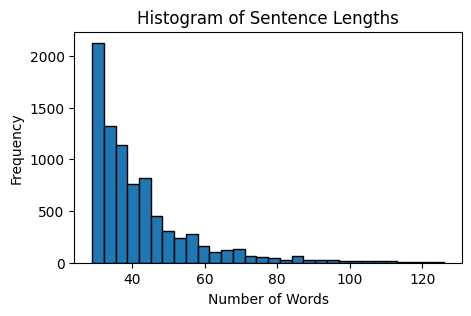

Statistic       Value
0       Min   29.000000
1       Max  126.000000
2    Median   37.000000
3      Mode   30.000000
4      Mean   42.174694

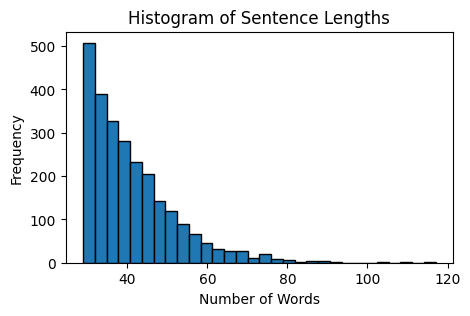

Statistic       Value
0       Min   29.000000
1       Max  117.000000
2    Median   38.000000
3      Mode   29.000000
4      Mean   40.862745

In [ ]:
# Plot distribution and display table of passage length statistics
plot_passage_lengths(datasets['catalyst']['train'])
display_passage_stats(datasets['catalyst']['train'])
plot_passage_lengths(datasets['battery']['train'])
display_passage_stats(datasets['battery']['train'])

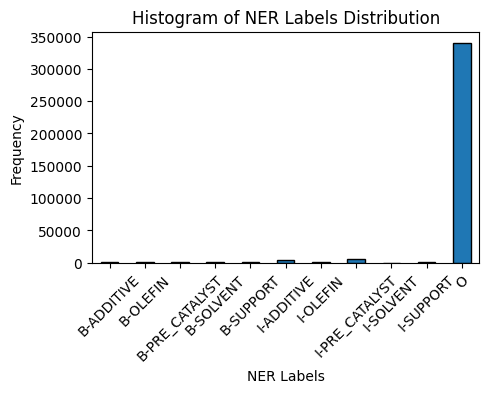

CATALYST          eval   train    val
Tag                                  
B-ADDITIVE         153     821    126
B-OLEFIN           356    1137    150
B-PRE_CATALYST      71     314     51
B-SOLVENT          131     352     50
B-SUPPORT           83     392     25
I-ADDITIVE         620    3785    669
I-OLEFIN           163     656     83
I-PRE_CATALYST    1350    6199   1041
I-SOLVENT           39      85     17
I-SUPPORT           68     384     14
O               100138  340522  60333

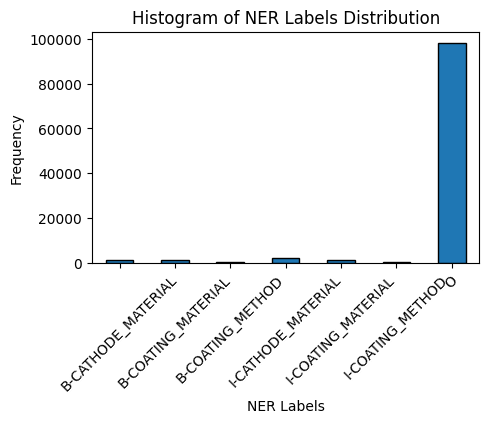

BATTERY              eval  train    val
Tag                                    
B-CATHODE_MATERIAL    402   1188    223
B-COATING_MATERIAL    359   1304    206
B-COATING_METHOD      134    352     57
I-CATHODE_MATERIAL    624   1872    362
I-COATING_MATERIAL    285    958    147
I-COATING_METHOD       91    212     34
O                   28838  98314  16791

In [ ]:
# Plot distribution of label counts
plot_label_counts(datasets['catalyst']['train'])
# Generate counts for the catalyst dataset
catalyst_counts = display_label_counts(datasets['catalyst'])
# Create a DataFrame from the counts
catalyst_counts_df = pd.DataFrame(catalyst_counts, columns=['CATALYST', 'Tag', 'Count'])
# Pivot the DataFrame to have Split as the column hierarchy
catalyst_counts_pivot = catalyst_counts_df.pivot(index='Tag',
                                               columns='CATALYST',
                                               values='Count').fillna(0)
# Display the updated DataFrame
display(catalyst_counts_pivot)

print('\n')

# Plot distribution of label counts
plot_label_counts(datasets['battery']['train'])
# Generate counts for the battery dataset
battery_counts = display_label_counts(datasets['battery'])
# Create a DataFrame from the counts
battery_counts_df = pd.DataFrame(battery_counts, columns=['BATTERY', 'Tag', 'Count'])
# Pivot the DataFrame to have Split as the column hierarchy
battery_counts_pivot = battery_counts_df.pivot(index='Tag',
                                               columns='BATTERY',
                                               values='Count').fillna(0)
# Display the updated DataFrame
display(battery_counts_pivot)

In [ ]:
# Inspect Catalyst dataset
print('\n___CATALYST___')
print(f"Features:\n\t{datasets['catalyst']['val'].features.keys()}")
print(f"Example:\n\t{datasets['catalyst']['val'][113]}") # 101, 113 (19 for train)

# Inspect Catalyst labels
catalyst_label_list = sorted(list(set(tag for tags in datasets['catalyst']['val']['ner_tags'] for tag in tags)))
catalyst_label2id = create_label2id_mapping(datasets['catalyst']['val'])
catalyst_id2label = {id: label for label, id in catalyst_label2id.items()}
print(f"Catalyst labels:\n\t{catalyst_label2id}")

# Inspect Battery dataset
print('\n___BATTERY___')
print(f"Features:\n\t{datasets['battery']['val'].features.keys()}")
print(f"Example:\n\t{datasets['battery']['val'][18]}") # 18, 45 (19 for train)

# Inspect Battery labels
battery_label_list = sorted(list(set(tag for tags in datasets['battery']['val']['ner_tags'] for tag in tags)))
battery_label2id = create_label2id_mapping(datasets['battery']['val'])
battery_id2label = {id: label for label, id in battery_label2id.items()}
print(f"Battery labels:\n\t{battery_label2id}")



___CATALYST___
Features:
	dict_keys(['id', 'tokens', 'ner_tags', '__index_level_0__'])
Example:
	{'id': 7876, 'tokens': ['0', 'bar', 'ethylene', 'pressure', ',', '500', 'ml', 'n', '-', 'pentane', ',', '1', '.', '0', 'ml', 'TIBA', '(', '1', '.', '6', 'M', 'in', 'n', '-', 'hexane', ')', ',', '70', '?', 'C', ','], 'ner_tags': ['O', 'O', 'B-OLEFIN', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'I-SOLVENT', 'I-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'B-ADDITIVE', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'I-SOLVENT', 'I-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'O'], '__index_level_0__': 7876}
Catalyst labels:
	{'O': 0, 'B-ADDITIVE': 1, 'B-OLEFIN': 3, 'B-PRE_CATALYST': 5, 'B-SOLVENT': 7, 'B-SUPPORT': 9, 'I-ADDITIVE': 2, 'I-OLEFIN': 4, 'I-PRE_CATALYST': 6, 'I-SOLVENT': 8, 'I-SUPPORT': 10}

___BATTERY___
Features:
	dict_keys(['id', 'tokens', 'ner_tags', '__index_level_0__'])
Example:
	{'id': 2738, 'tokens': ['ALD', '-', 'ZnO', 'coated', 'NCM', '-', '523', 'has', 'a', 'high', 'discharge', 'capacity', 'of', '256', '

In [ ]:
# Update the NER datasets with analogous integer labels
datasets['catalyst']['train'] = datasets['catalyst']['train'].map(lambda x: add_ner_ids(x, catalyst_label2id))
datasets['catalyst']['val'] = datasets['catalyst']['val'].map(lambda x: add_ner_ids(x, catalyst_label2id))
datasets['catalyst']['eval'] = datasets['catalyst']['eval'].map(lambda x: add_ner_ids(x, catalyst_label2id))
datasets['battery']['train'] = datasets['battery']['train'].map(lambda x: add_ner_ids(x, battery_label2id))
datasets['battery']['val'] = datasets['battery']['val'].map(lambda x: add_ner_ids(x, battery_label2id))
datasets['battery']['eval'] = datasets['battery']['eval'].map(lambda x: add_ner_ids(x, battery_label2id))

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

# 7. Analysis pipeline

## 7.1 Model statistics (B & C experiments)

### Setup basic data structures

In [ ]:
## 7.1.1 - Aggregate Scores into a single data structure

# Function to create full list of scores, with each element corresponding to a replicate-level model run
def append_scores():

    # Create a list to store all models' data
    scores_list = []

    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']  # update to ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased', 'dmis-lab/biobert-base-cased-v1.2']

    # Append data from 'B' experiments
    for checkpoint in checkpoints:
        name_prefix='B_'
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for dataset in ['battery', 'catalyst']:  # update to ['battery', 'catalyst']
            for train_strategy in ['none', 'all']: # update to ['none', 'all']
                scores_file = f"{model_name}_{dataset}_{train_strategy}_scores"
                #print(scores_file)
                partial_scores_list = load_pickle(scores_file)
                for i in range(len(partial_scores_list)):
                    scores_list.append(partial_scores_list[i])

    # Append data from 'C' experiments
    for checkpoint in  ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']:
        name_prefix='C_'
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for dataset in ['battery', 'catalyst']:  # update to ['battery', 'catalyst']
            for train_strategy in ['all']: # update to ['none', 'all']
                scores_file = f"{model_name}_{dataset}_{train_strategy}_scores"
                #print(scores_file)
                partial_scores_list = load_pickle(scores_file)
                for i in range(len(partial_scores_list)):
                    scores_list.append(partial_scores_list[i])

    return scores_list

# Create full list of scores
scores_list = append_scores()

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(scores_list)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect an example
i = 6
print(type(scores_list))
print(len(scores_list))
print(type(scores_list[i]))
print(scores_list[i].keys())
print(scores_list[i]['scores'].keys())
print(type(scores_list[i]['scores']['train']))
print(f"{scores_list[i]['model_prefix']}_{scores_list[i]['dataset']}_{scores_list[i]['train_strategy']}_{scores_list[i]['ff_strategy']}_{scores_list[i]['batch_size']}_{scores_list[i]['init_lr']}_{scores_list[i]['replicate']}")
print(type(scores_list[i]['scores']['train']))
display(scores_list[i]['scores']['train'])

# print out all model specifications + replicate #
for i in range(len(scores_list)):
    model_replicate_name = f"{scores_list[i]['model_prefix']}_{scores_list[i]['dataset']}_{scores_list[i]['train_strategy']}_{scores_list[i]['ff_strategy']}_{scores_list[i]['batch_size']}_{scores_list[i]['init_lr']}_{scores_list[i]['replicate']}"
    #print(f"________{model_replicate_name}_____")

Loaded data/interim/B_basebert_battery_none_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_basebert_battery_all_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_basebert_catalyst_none_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_basebert_catalyst_all_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_scibert_battery_none_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_scibert_battery_all_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_scibert_catalyst_none_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_scibert_catalyst_all_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_spanbert_battery_none_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_spanbert_battery_all_scores.pkl into the local Google Colab environment.
Loaded data/interim/B_spanbert_catalyst_none_

Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.685  0.797  0.737    1262                
COATING_MATERIAL     0.721  0.763  0.741    1305                
COATING_METHOD       0.726  0.565  0.636     352                
OVERALL              0.705  0.754  0.728            0.982  0.829

In [ ]:
## 7.1.2 - Compute score means and standard deviations (down to the label level)

# Function to compute mean and std for a list of dataframes
def compute_mean_std(dfs):
    # Combine dataframes for computation
    combined = pd.concat(dfs, axis=0)

    # Convert non-numeric values to NaN
    combined = combined.apply(pd.to_numeric, errors='coerce')

    # Compute mean and std
    means = combined.groupby(level=0).mean()
    stds = combined.groupby(level=0).std()

    # Merge results
    result = pd.concat([means, stds], keys=['Mean', 'Stdev'], axis=1)

    # Temporarily suppress FutureWarnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        # Ensure 'Overall' has mean and std for 'Accuracy' and 'MCC'
        if 'OVERALL' in result.index:
            result.loc['OVERALL'] = result.loc['OVERALL'].ffill()

    return result

# Function to compute the statistical scores list
def compute_stat_scores_list(scores_list):
    # List to store the statistical dataframes
    stat_scores_list = []

    # Iterate over the unique combinations of parameters
    for i in range(0, len(scores_list), 3):
        # Extract parameters
        try:
            params = scores_list[i]
            pretrained_model = params['model_prefix']
            dataset = params['dataset']
            train_strategy = params['train_strategy']
            ff_strategy = params['ff_strategy']
            batch_size = params['batch_size']
            init_lr = params['init_lr']
        except KeyError as e:
            print(f"KeyError: {e} in entry {params}")
            continue

        # Initialize storage for replicates
        replicate_data = {
            'train': [],
            'val': [],
            'eval': []
        }

        # Collect replicate data
        for j in range(3):
            replicate_data['train'].append(scores_list[i + j]['scores']['train'])
            replicate_data['val'].append(scores_list[i + j]['scores']['val'])
            replicate_data['eval'].append(scores_list[i + j]['scores']['eval'])

        # Compute statistics for train, val, and eval splits
        stat_scores = {
            'train': compute_mean_std(replicate_data['train']),
            'val': compute_mean_std(replicate_data['val']),
            'eval': compute_mean_std(replicate_data['eval'])
        }

        # Append to the list
        stat_scores_list.append({
            'model_prefix': pretrained_model,
            'dataset': dataset,
            'train_strategy': train_strategy,
            'ff_strategy': ff_strategy,
            'batch_size': batch_size,
            'init_lr': init_lr,
            'stat_scores': stat_scores
        })

    return stat_scores_list

# Create full list of score statistics
stat_scores_list = compute_stat_scores_list(scores_list)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(scores_list)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect an example
i = 32
print(type(stat_scores_list))
print(len(stat_scores_list))
print(type(stat_scores_list[i]))
print(stat_scores_list[i].keys())
print(stat_scores_list[i]['stat_scores'].keys())
print(type(stat_scores_list[i]['stat_scores']['train']))
print(f"{stat_scores_list[i]['model_prefix']}_{stat_scores_list[i]['dataset']}_{stat_scores_list[i]['train_strategy']}_{stat_scores_list[i]['ff_strategy']}_{stat_scores_list[i]['batch_size']}_{stat_scores_list[i]['init_lr']}")
print(type(stat_scores_list[i]['stat_scores']['train']))
display(stat_scores_list[i]['stat_scores']['train'])

Deep size of example_dict: 28.29395294189453 megabytes
<class 'list'>
162
<class 'dict'>
dict_keys(['model_prefix', 'dataset', 'train_strategy', 'ff_strategy', 'batch_size', 'init_lr', 'stat_scores'])
dict_keys(['train', 'val', 'eval'])
<class 'pandas.core.frame.DataFrame'>
B_basebert_catalyst_all_last_32_8e-05
<class 'pandas.core.frame.DataFrame'>


Mean                                                    \
             Precision    Recall        F1   Support  Accuracy       MCC   
Label                                                                      
ADDITIVE      0.628000  0.845000  0.720667   822.000       NaN       NaN   
OLEFIN        0.611000  0.797667  0.692000  1137.000       NaN       NaN   
OVERALL       0.638333  0.798000  0.709000     0.709  0.988333  0.857333   
PRE_CATALYST  0.630000  0.813333  0.709667   315.000       NaN       NaN   
SOLVENT       0.698667  0.684667  0.688333   352.000       NaN       NaN   
SUPPORT       0.722333  0.787333  0.753667   392.000       NaN       NaN   

                 Stdev                                                    
             Precision    Recall        F1   Support  Accuracy       MCC  
Label                                                                     
ADDITIVE      0.009539  0.019079  0.012342  0.000000       NaN       NaN  
OLEFIN        0.019079  0.036828  0.025357  0.000000       NaN       NaN  
OVERALL       0.014012  0.035341  0.021932  0.021932  0.000577  0.010504  
PRE_CATALYST  0.033601  0.027737  0.030436  0.000000       NaN       NaN  
SOLVENT       0.022143  0.095044  0.039501  0.000000       NaN       NaN  
SUPPORT       0.011590  0.030105  0.019757  0.000000       NaN       NaN

In [ ]:
## 7.1.3 - Consolidate all score statistics into a single comprehensive dataframe

# Function to consolidate score statistics into a single dataframe for all model specifications
def generate_stat_scores_df(stat_scores_list):
    # Create an empty DataFrame for summary
    stat_scores_specifications = pd.DataFrame()

    # Iterate over stat_scores_list to populate stat_scores_specifications
    for entry in stat_scores_list:
        model_prefix = entry['model_prefix']
        dataset = entry['dataset']
        train_strategy = entry['train_strategy']
        ff_strategy = entry['ff_strategy']
        batch_size = entry['batch_size']
        init_lr = entry['init_lr']

        # Extract statistical data
        for split in ['train', 'val', 'eval']:
            df = entry['stat_scores'][split].copy()
            df.insert(0, 'Model Prefix', model_prefix)
            df.insert(1, 'Dataset', dataset)
            df.insert(2, 'Train Strategy', train_strategy)
            df.insert(3, 'Feedforward Strategy', ff_strategy)
            df.insert(4, 'Batch Size', batch_size)
            df.insert(5, 'Init LR', init_lr)
            df.insert(6, 'Split', split)

            # Append to full DataFrame
            stat_scores_specifications = pd.concat([stat_scores_specifications, df.reset_index()], axis=0)

    # Reset index
    stat_scores_specifications.reset_index(drop=True, inplace=True)

    return stat_scores_specifications

# Generate full DataFrame where each row corresponds to a single model specification
stat_scores_specifications = generate_stat_scores_df(stat_scores_list)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(stat_scores_specifications)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect an example
i = 32
print(type(stat_scores_specifications))
print(len(stat_scores_specifications))
#display(stat_scores_specifications.head(10))
#display(stat_scores_specifications[stat_scores_specifications['Dataset']=='catalyst'].head(10))

# Filtering the DataFrame based on some specified conditions
filtered_rows = stat_scores_specifications[
    (stat_scores_specifications[('Dataset', '')] == 'catalyst') &
    (stat_scores_specifications[('Feedforward Strategy', '')] == 'concat') &
    (stat_scores_specifications[('Init LR', '')] == 2e-5)
]
# Display the filtered rows
display(filtered_rows)

Deep size of example_dict: 2.3317413330078125 megabytes
<class 'pandas.core.frame.DataFrame'>
2430


Label Model Prefix   Dataset Train Strategy Feedforward Strategy  \
                                                                                
216       ADDITIVE   B_basebert  catalyst           none               concat   
217         OLEFIN   B_basebert  catalyst           none               concat   
218        OVERALL   B_basebert  catalyst           none               concat   
219   PRE_CATALYST   B_basebert  catalyst           none               concat   
220        SOLVENT   B_basebert  catalyst           none               concat   
...            ...          ...       ...            ...                  ...   
2389        OLEFIN   C_spanbert  catalyst            all               concat   
2390       OVERALL   C_spanbert  catalyst            all               concat   
2391  PRE_CATALYST   C_spanbert  catalyst            all               concat   
2392       SOLVENT   C_spanbert  catalyst            all               concat   
2393       SUPPORT   C_spanbert  catalyst            all               concat   

     Batch Size  Init LR  Split      Mean                                   \
                                Precision    Recall        F1      Support   
216          16  0.00002  train  0.434000  0.357000  0.391667   822.000000   
217          16  0.00002  train  0.485667  0.478000  0.481000  1137.000000   
218          16  0.00002  train  0.450667  0.363667  0.402000     0.402000   
219          16  0.00002  train  0.336667  0.474000  0.393333   315.000000   
220          16  0.00002  train  0.708667  0.092000  0.162333   352.000000   
...         ...      ...    ...       ...       ...       ...          ...   
2389         64  0.00002   eval  0.000000  0.000000  0.000000   356.000000   
2390         64  0.00002   eval  0.125333  0.032667  0.051667     0.051667   
2391         64  0.00002   eval  0.029333  0.046667  0.036000    71.000000   
2392         64  0.00002   eval  0.000000  0.000000  0.000000   131.000000   
2393         64  0.00002   eval  0.000000  0.000000  0.000000    83.000000   

                             Stdev                                          \
      Accuracy       MCC Precision    Recall        F1   Support  Accuracy   
216        NaN       NaN  0.073021  0.062554  0.067144  0.000000       NaN   
217        NaN       NaN  0.031943  0.067000  0.049275  0.000000       NaN   
218   0.982000  0.757667  0.037207  0.046705  0.043209  0.043209  0.001000   
219        NaN       NaN  0.011590  0.032078  0.018930  0.000000       NaN   
220        NaN       NaN  0.079185  0.020298  0.033322  0.000000       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
2389       NaN       NaN  0.000000  0.000000  0.000000  0.000000       NaN   
2390  0.975667  0.522667  0.030271  0.010263  0.015177  0.015177  0.000577   
2391       NaN       NaN  0.002309  0.008083  0.004359  0.000000       NaN   
2392       NaN       NaN  0.000000  0.000000  0.000000  0.000000       NaN   
2393       NaN       NaN  0.000000  0.000000  0.000000  0.000000       NaN   

                
           MCC  
216        NaN  
217        NaN  
218   0.013051  
219        NaN  
220        NaN  
...        ...  
2389       NaN  
2390  0.003215  
2391       NaN  
2392       NaN  
2393       NaN  

[324 rows x 20 columns]

### Generate tables for TRAIN split


In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_train = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'train'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'train'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    return full_configuration_summaries_train


# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
full_configuration_summaries_train = generate_configuration_summaries(stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
full_configuration_summaries_train = add_combined_score(full_configuration_summaries_train)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(full_configuration_summaries_train)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(full_configuration_summaries_train))
print(len(full_configuration_summaries_train))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in full_configuration_summaries_train:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.357940673828125 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 train  0.475333   
                                                                                  0.00005 train  0.674000   
                                                                                  0.00008 train  0.721667   
                                                                       32         0.00002 train  0.100000   
                                                                                  0.00005 train  0.471667   
                                                                                  0.00008 train  0.585333   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.072333   
                                                                                  0.00008 train  0.277333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 train  0.029738   
                                                                                  0.00005 train  0.005196   
                                                                                  0.00008 train  0.005686   
                                                                       32         0.00002 train  0.026230   
                                                                                  0.00005 train  0.032130   
                                                                                  0.00008 train  0.014295   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.050836   
                                                                                  0.00008 train  0.029263   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 train  0.626667   
                                                                                  0.00005 train  0.779667   
                                                                                  0.00008 train  0.824667   
                                                                       32         0.00002 train  0.385333   
                                                                                  0.00005 train  0.618333   
                                                                                  0.00008 train  0.697667   
                                                                       64         0.00002 train  0.097333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 train  0.761000   
                                                                                 0.00005 train  0.858667   
                                                                                 0.00008 train  0.893667   
                                                                      32         0.00002 train  0.679667   
                                                                                 0.00005 train  0.753333   
                                                                                 0.00008 train  0.787000   
                                                                      64         0.00002 train  0.549333   
                                                                                 0.00005 train  0.661000   
                                                                                 0.00008 train  0.686667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 train  0.016523   
                                                                                 0.00005 train  0.012055   
                                                                                 0.00008 train  0.006429   
                                                                      32         0.00002 train  0.016503   
                                                                                 0.00005 train  0.011846   
                                                                                 0.00008 train  0.018358   
                                                                      64         0.00002 train  0.069867   
                                                                                 0.00005 train  0.019519   
                                                                                 0.00008 train  0.027006   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 train  0.857333   
                                                                                 0.00005 train  0.920000   
                                                                                 0.00008 train  0.940333   
                                                                      32         0.00002 train  0.779667   
                                                                                 0.00005 train  0.845000   
                                                                                 0.00008 train  0.868667   
                                                                      64         0.00002 train  0.664000   
                                                                                 0.00005 train  0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 train  0.439000   
                                                                                  0.00005 train  0.629000   
                                                                                  0.00008 train  0.702333   
                                                                       32         0.00002 train  0.037667   
                                                                                  0.00005 train  0.438667   
                                                                                  0.00008 train  0.529333   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.022333   
                                                                                  0.00008 train  0.230667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 train  0.008888   
                                                                                  0.00005 train  0.010440   
                                                                                  0.00008 train  0.005132   
                                                                       32         0.00002 train  0.019502   
                                                                                  0.00005 train  0.009292   
                                                                                  0.00008 train  0.007234   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.009074   
                                                                                  0.00008 train  0.031214   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 train  0.617667   
                                                                                  0.00005 train  0.759667   
                                                                                  0.00008 train  0.822000   
                                                                       32         0.00002 train  0.352667   
                                                                                  0.00005 train  0.612333   
                                                                                  0.00008 train  0.680000   
                                                                       64         0.00002 train  0.134667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 train  0.765333   
                                                                                 0.00005 train  0.867667   
                                                                                 0.00008 train  0.902333   
                                                                      32         0.00002 train  0.620667   
                                                                                 0.00005 train  0.751667   
                                                                                 0.00008 train  0.795667   
                                                                      64         0.00002 train  0.431333   
                                                                                 0.00005 train  0.587667   
                                                                                 0.00008 train  0.651333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 train  0.019858   
                                                                                 0.00005 train  0.007638   
                                                                                 0.00008 train  0.006506   
                                                                      32         0.00002 train  0.036116   
                                                                                 0.00005 train  0.023180   
                                                                                 0.00008 train  0.023965   
                                                                      64         0.00002 train  0.113808   
                                                                                 0.00005 train  0.076553   
                                                                                 0.00008 train  0.059341   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 train  0.865000   
                                                                                 0.00005 train  0.928667   
                                                                                 0.00008 train  0.947667   
                                                                      32         0.00002 train  0.757000   
                                                                                 0.00005 train  0.854333   
                                                                                 0.00008 train  0.878000   
                                                                      64         0.00002 train  0.599333   
                                                                                 0.00005 train  0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 train  0.309000   
                                                                                  0.00005 train  0.586667   
                                                                                  0.00008 train  0.667667   
                                                                       32         0.00002 train  0.000000   
                                                                                  0.00005 train  0.290000   
                                                                                  0.00008 train  0.466667   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.000000   
                                                                                  0.00008 train  0.049333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 train  0.027221   
                                                                                  0.00005 train  0.016442   
                                                                                  0.00008 train  0.009292   
                                                                       32         0.00002 train  0.000000   
                                                                                  0.00005 train  0.045574   
                                                                                  0.00008 train  0.021939   
                                                                       64         0.00002 train  0.000000   
                                                                                  0.00005 train  0.000000   
                                                                                  0.00008 train  0.037166   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 train  0.531667   
                                                                                  0.00005 train  0.716000   
                                                                                  0.00008 train  0.780667   
                                                                       32         0.00002 train  0.259667   
                                                                                  0.00005 train  0.519667   
                                                                                  0.00008 train  0.626667   
                                                                       64         0.00002 train  0.000000   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 train  0.716667   
                                                                                 0.00005 train  0.824667   
                                                                                 0.00008 train  0.864667   
                                                                      32         0.00002 train  0.451667   
                                                                                 0.00005 train  0.662333   
                                                                                 0.00008 train  0.712000   
                                                                      64         0.00002 train  0.008000   
                                                                                 0.00005 train  0.291000   
                                                                                 0.00008 train  0.345667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 train  0.022898   
                                                                                 0.00005 train  0.019553   
                                                                                 0.00008 train  0.007767   
                                                                      32         0.00002 train  0.079008   
                                                                                 0.00005 train  0.051326   
                                                                                 0.00008 train  0.037403   
                                                                      64         0.00002 train  0.011358   
                                                                                 0.00005 train  0.204507   
                                                                                 0.00008 train  0.192918   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 train  0.824333   
                                                                                 0.00005 train  0.902000   
                                                                                 0.00008 train  0.923333   
                                                                      32         0.00002 train  0.641000   
                                                                                 0.00005 train  0.786667   
                                                                                 0.00008 train  0.820667   
                                                                      64         0.00002 train  0.125333   
                                                                                 0.00005 train  0.5

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 train  0.761667   
                                                                                 0.00005 train  0.860000   
                                                                                 0.00008 train  0.898000   
                                                                      32         0.00002 train  0.664667   
                                                                                 0.00005 train  0.740667   
                                                                                 0.00008 train  0.776000   
                                                                      64         0.00002 train  0.353000   
                                                                                 0.00005 train  0.648667   
                                                                                 0.00008 train  0.678333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 train  0.001528   
                                                                                 0.00005 train  0.007000   
                                                                                 0.00008 train  0.003464   
                                                                      32         0.00002 train  0.014295   
                                                                                 0.00005 train  0.003512   
                                                                                 0.00008 train  0.002646   
                                                                      64         0.00002 train  0.033779   
                                                                                 0.00005 train  0.028431   
                                                                                 0.00008 train  0.008622   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 train  0.854667   
                                                                                 0.00005 train  0.921667   
                                                                                 0.00008 train  0.942333   
                                                                      32         0.00002 train  0.773333   
                                                                                 0.00005 train  0.840000   
                                                                                 0.00008 train  0.865333   
                                                                      64         0.00002 train  0.538333   
                                                                                 0.00005 train  0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 train  0.783667   
                                                                                 0.00005 train  0.889000   
                                                                                 0.00008 train  0.915667   
                                                                      32         0.00002 train  0.613000   
                                                                                 0.00005 train  0.768333   
                                                                                 0.00008 train  0.804667   
                                                                      64         0.00002 train  0.130667   
                                                                                 0.00005 train  0.578000   
                                                                                 0.00008 train  0.631333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 train  0.003055   
                                                                                 0.00005 train  0.005000   
                                                                                 0.00008 train  0.005033   
                                                                      32         0.00002 train  0.019975   
                                                                                 0.00005 train  0.008386   
                                                                                 0.00008 train  0.015631   
                                                                      64         0.00002 train  0.034443   
                                                                                 0.00005 train  0.041797   
                                                                                 0.00008 train  0.037018   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 train  0.877667   
                                                                                 0.00005 train  0.940333   
                                                                                 0.00008 train  0.955000   
                                                                      32         0.00002 train  0.754667   
                                                                                 0.00005 train  0.860000   
                                                                                 0.00008 train  0.883333   
                                                                      64         0.00002 train  0.424333   
                                                                                 0.00005 train  0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 train  0.683000   
                                                                                 0.00005 train  0.805000   
                                                                                 0.00008 train  0.856333   
                                                                      32         0.00002 train  0.438333   
                                                                                 0.00005 train  0.649000   
                                                                                 0.00008 train  0.708000   
                                                                      64         0.00002 train  0.000000   
                                                                                 0.00005 train  0.322000   
                                                                                 0.00008 train  0.429667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 train  0.015524   
                                                                                 0.00005 train  0.002646   
                                                                                 0.00008 train  0.002517   
                                                                      32         0.00002 train  0.033126   
                                                                                 0.00005 train  0.010817   
                                                                                 0.00008 train  0.005568   
                                                                      64         0.00002 train  0.000000   
                                                                                 0.00005 train  0.041581   
                                                                                 0.00008 train  0.042004   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 train  0.808000   
                                                                                 0.00005 train  0.891000   
                                                                                 0.00008 train  0.919667   
                                                                      32         0.00002 train  0.629667   
                                                                                 0.00005 train  0.781333   
                                                                                 0.00008 train  0.820667   
                                                                      64         0.00002 train  0.253000   
                                                                                 0.00005 train  0.5

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_train = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            hyperparameters = f"({batch_size}, {init_lr:.0e})"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_train.append(pretty_df)

    return pretty_configuration_summaries_train

# Usage example:
pretty_configuration_summaries_train = prettify_configuration_summaries(full_configuration_summaries_train)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_train)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_train))
print(len(pretty_configuration_summaries_train))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_train:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.28973388671875 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4753 +/- 0.0297  0.6267 +/- 0.0196   
                       (16, 5e-05)      0.6740 +/- 0.0052  0.7797 +/- 0.0071   
                       (16, 8e-05)      0.7217 +/- 0.0057  0.8247 +/- 0.0075   
                       (32, 2e-05)      0.1000 +/- 0.0262  0.3853 +/- 0.0147   
                       (32, 5e-05)      0.4717 +/- 0.0321  0.6183 +/- 0.0232   
                       (32, 8e-05)      0.5853 +/- 0.0143  0.6977 +/- 0.0122   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0973 +/- 0.0877   
                       (64, 5e-05)      0.0723 +/- 0.0508  0.3707 +/- 0.0312   
                       (64, 8e-05)      0.2773 +/- 0.0293  0.4987 +/- 0.0184   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4020 +/- 0.0432  0.7577 +/- 0.0131   
                       (16, 5e-05)      0.6413 +/- 0.0186  0.8380 +/- 0.0056   
                       (16, 8e-05)      0.6777 +/- 0.0134  0.8537 +/- 0.0038   
                       (32, 2e-05)      0.0797 +/- 0.0223  0.6260 +/- 0.0249   
                       (32, 5e-05)      0.3350 +/- 0.0579  0.7273 +/- 0.0170   
                       (32, 8e-05)      0.4637 +/- 0.0241  0.7607 +/- 0.0106   
                       (64, 2e-05)      0.0093 +/- 0.0059  0.3543 +/- 0.1060   
                       (64, 5e-05)      0.0137 +/- 0.0203  0.5707 +/- 0.0438   
                       (64, 8e-05)      0.0640 +/- 0.0543  0.6210 +/- 0.0195   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4387 +/- 0.0027  0.6922 +/- 0.0054  
                       (16, 5e-05)      0.6577 +/- 0.0005  0.8088 +/- 0.0011  
                       (16, 8e-05)      0.6997 +/- 0.0007  0.8392 +/- 0.0003  
                       (32, 2e-05)      0.0898 +/- 0.0006  0.5057 +/- 0.0177  
                       (32, 5e-05)      0.4033 +/- 0.0074  0.6728 +/- 0.0039  
                       (32, 8e-05)      0.5245 +/- 0.0048  0.7292 +/- 0.0013  
                       (64, 2e-05)      0.0047 +/- 0.0000  0.2258 +/- 0.0274  
                       (64, 5e-05)      0.0430 +/- 0.0022  0.4707 +/- 0.0132  
                       (64, 8e-05)      0.1707 +/- 0.0152  0.5598 +/- 0.0048

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.7610 +/- 0.0165  0.8573 +/- 0.0105   
                    (16, 5e-05)      0.8587 +/- 0.0121  0.9200 +/- 0.0061   
                    (16, 8e-05)      0.8937 +/- 0.0064  0.9403 +/- 0.0060   
                    (32, 2e-05)      0.6797 +/- 0.0165  0.7797 +/- 0.0150   
                    (32, 5e-05)      0.7533 +/- 0.0118  0.8450 +/- 0.0098   
                    (32, 8e-05)      0.7870 +/- 0.0184  0.8687 +/- 0.0106   
                    (64, 2e-05)      0.5493 +/- 0.0699  0.6640 +/- 0.0651   
                    (64, 5e-05)      0.6610 +/- 0.0195  0.7600 +/- 0.0190   
                    (64, 8e-05)      0.6867 +/- 0.0270  0.7930 +/- 0.0145   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.7343 +/- 0.0130  0.8933 +/- 0.0040   
                    (16, 5e-05)      0.8047 +/- 0.0080  0.9207 +/- 0.0047   
                    (16, 8e-05)      0.8140 +/- 0.0087  0.9260 +/- 0.0026   
                    (32, 2e-05)      0.5980 +/- 0.0227  0.8203 +/- 0.0072   
                    (32, 5e-05)      0.6953 +/- 0.0162  0.8550 +/- 0.0123   
                    (32, 8e-05)      0.7090 +/- 0.0219  0.8573 +/- 0.0105   
                    (64, 2e-05)      0.3427 +/- 0.0535  0.7097 +/- 0.0188   
                    (64, 5e-05)      0.4863 +/- 0.0146  0.7627 +/- 0.0057   
                    (64, 8e-05)      0.5080 +/- 0.0274  0.7667 +/- 0.0272   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.7477 +/- 0.0004  0.8753 +/- 0.0004  
                    (16, 5e-05)      0.8317 +/- 0.0010  0.9203 +/- 0.0000  
                    (16, 8e-05)      0.8538 +/- 0.0020  0.9332 +/- 0.0001  
                    (32, 2e-05)      0.6388 +/- 0.0023  0.8000 +/- 0.0006  
                    (32, 5e-05)      0.7243 +/- 0.0012  0.8500 +/- 0.0001  
                    (32, 8e-05)      0.7480 +/- 0.0022  0.8630 +/- 0.0001  
                    (64, 2e-05)      0.4460 +/- 0.0159  0.6868 +/- 0.0025  
                    (64, 5e-05)      0.5737 +/- 0.0094  0.7613 +/- 0.0002  
                    (64, 8e-05)      0.5973 +/- 0.0102  0.7798 +/- 0.0006

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4390 +/- 0.0089  0.6177 +/- 0.0051   
                      (16, 5e-05)      0.6290 +/- 0.0104  0.7597 +/- 0.0057   
                      (16, 8e-05)      0.7023 +/- 0.0051  0.8220 +/- 0.0017   
                      (32, 2e-05)      0.0377 +/- 0.0195  0.3527 +/- 0.0090   
                      (32, 5e-05)      0.4387 +/- 0.0093  0.6123 +/- 0.0070   
                      (32, 8e-05)      0.5293 +/- 0.0072  0.6800 +/- 0.0046   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1347 +/- 0.0770   
                      (64, 5e-05)      0.0223 +/- 0.0091  0.3367 +/- 0.0076   
                      (64, 8e-05)      0.2307 +/- 0.0312  0.4763 +/- 0.0147   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4760 +/- 0.0291  0.7827 +/- 0.0071   
                      (16, 5e-05)      0.6747 +/- 0.0067  0.8587 +/- 0.0050   
                      (16, 8e-05)      0.7167 +/- 0.0015  0.8753 +/- 0.0031   
                      (32, 2e-05)      0.1473 +/- 0.0176  0.6437 +/- 0.0137   
                      (32, 5e-05)      0.4227 +/- 0.0240  0.7597 +/- 0.0091   
                      (32, 8e-05)      0.5377 +/- 0.0221  0.7937 +/- 0.0060   
                      (64, 2e-05)      0.0457 +/- 0.0119  0.4997 +/- 0.0378   
                      (64, 5e-05)      0.0757 +/- 0.0467  0.6320 +/- 0.0141   
                      (64, 8e-05)      0.1640 +/- 0.0406  0.6743 +/- 0.0123   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4575 +/- 0.0008  0.7002 +/- 0.0082  
                      (16, 5e-05)      0.6518 +/- 0.0007  0.8092 +/- 0.0030  
                      (16, 8e-05)      0.7095 +/- 0.0001  0.8487 +/- 0.0009  
                      (32, 2e-05)      0.0925 +/- 0.0039  0.4982 +/- 0.0255  
                      (32, 5e-05)      0.4307 +/- 0.0003  0.6860 +/- 0.0066  
                      (32, 8e-05)      0.5335 +/- 0.0002  0.7368 +/- 0.0039  
                      (64, 2e-05)      0.0228 +/- 0.0007  0.3172 +/- 0.0429  
                      (64, 5e-05)      0.0490 +/- 0.0018  0.4843 +/- 0.0263  
                      (64, 8e-05)      0.1973 +/- 0.0024  0.5753 +/- 0.0119

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7653 +/- 0.0199  0.8650 +/- 0.0072   
                   (16, 5e-05)      0.8677 +/- 0.0076  0.9287 +/- 0.0035   
                   (16, 8e-05)      0.9023 +/- 0.0065  0.9477 +/- 0.0035   
                   (32, 2e-05)      0.6207 +/- 0.0361  0.7570 +/- 0.0148   
                   (32, 5e-05)      0.7517 +/- 0.0232  0.8543 +/- 0.0144   
                   (32, 8e-05)      0.7957 +/- 0.0240  0.8780 +/- 0.0130   
                   (64, 2e-05)      0.4313 +/- 0.1138  0.5993 +/- 0.0641   
                   (64, 5e-05)      0.5877 +/- 0.0766  0.7223 +/- 0.0398   
                   (64, 8e-05)      0.6513 +/- 0.0593  0.7680 +/- 0.0313   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7527 +/- 0.0170  0.9063 +/- 0.0035   
                   (16, 5e-05)      0.8187 +/- 0.0110  0.9297 +/- 0.0015   
                   (16, 8e-05)      0.8333 +/- 0.0142  0.9323 +/- 0.0070   
                   (32, 2e-05)      0.6023 +/- 0.0235  0.8257 +/- 0.0076   
                   (32, 5e-05)      0.7163 +/- 0.0045  0.8637 +/- 0.0097   
                   (32, 8e-05)      0.7410 +/- 0.0075  0.8723 +/- 0.0055   
                   (64, 2e-05)      0.3333 +/- 0.0267  0.7170 +/- 0.0036   
                   (64, 5e-05)      0.5160 +/- 0.0418  0.7777 +/- 0.0103   
                   (64, 8e-05)      0.5710 +/- 0.0135  0.7920 +/- 0.0154   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.7590 +/- 0.0003  0.8857 +/- 0.0005  
                   (16, 5e-05)      0.8432 +/- 0.0008  0.9292 +/- 0.0000  
                   (16, 8e-05)      0.8678 +/- 0.0015  0.9400 +/- 0.0001  
                   (32, 2e-05)      0.6115 +/- 0.0008  0.7913 +/- 0.0015  
                   (32, 5e-05)      0.7340 +/- 0.0006  0.8590 +/- 0.0001  
                   (32, 8e-05)      0.7683 +/- 0.0011  0.8752 +/- 0.0001  
                   (64, 2e-05)      0.3823 +/- 0.0083  0.6582 +/- 0.0058  
                   (64, 5e-05)      0.5518 +/- 0.0046  0.7500 +/- 0.0016  
                   (64, 8e-05)      0.6112 +/- 0.0034  0.7800 +/- 0.0007

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3090 +/- 0.0272  0.5317 +/- 0.0145   
                       (16, 5e-05)      0.5867 +/- 0.0164  0.7160 +/- 0.0096   
                       (16, 8e-05)      0.6677 +/- 0.0093  0.7807 +/- 0.0049   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2597 +/- 0.0503   
                       (32, 5e-05)      0.2900 +/- 0.0456  0.5197 +/- 0.0214   
                       (32, 8e-05)      0.4667 +/- 0.0219  0.6267 +/- 0.0103   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2130 +/- 0.0702   
                       (64, 8e-05)      0.0493 +/- 0.0372  0.3480 +/- 0.0275   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2530 +/- 0.0384  0.7163 +/- 0.0102   
                       (16, 5e-05)      0.5560 +/- 0.0104  0.8187 +/- 0.0015   
                       (16, 8e-05)      0.6217 +/- 0.0068  0.8407 +/- 0.0023   
                       (32, 2e-05)      0.0370 +/- 0.0072  0.6063 +/- 0.0155   
                       (32, 5e-05)      0.2330 +/- 0.0403  0.6927 +/- 0.0100   
                       (32, 8e-05)      0.3500 +/- 0.0166  0.7330 +/- 0.0078   
                       (64, 2e-05)      0.0127 +/- 0.0038  0.3737 +/- 0.0620   
                       (64, 5e-05)      0.0463 +/- 0.0092  0.5903 +/- 0.0146   
                       (64, 8e-05)      0.0587 +/- 0.0136  0.6190 +/- 0.0044   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2810 +/- 0.0018  0.6240 +/- 0.0104  
                       (16, 5e-05)      0.5713 +/- 0.0004  0.7673 +/- 0.0032  
                       (16, 8e-05)      0.6447 +/- 0.0007  0.8107 +/- 0.0011  
                       (32, 2e-05)      0.0185 +/- 0.0004  0.4330 +/- 0.0372  
                       (32, 5e-05)      0.2615 +/- 0.0025  0.6062 +/- 0.0092  
                       (32, 8e-05)      0.4083 +/- 0.0044  0.6798 +/- 0.0035  
                       (64, 2e-05)      0.0063 +/- 0.0001  0.1868 +/- 0.0434  
                       (64, 5e-05)      0.0232 +/- 0.0007  0.4017 +/- 0.0448  
                       (64, 8e-05)      0.0540 +/- 0.0007  0.4835 +/- 0.0223

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.7167 +/- 0.0229  0.8243 +/- 0.0178   
                    (16, 5e-05)      0.8247 +/- 0.0196  0.9020 +/- 0.0111   
                    (16, 8e-05)      0.8647 +/- 0.0078  0.9233 +/- 0.0047   
                    (32, 2e-05)      0.4517 +/- 0.0790  0.6410 +/- 0.0495   
                    (32, 5e-05)      0.6623 +/- 0.0513  0.7867 +/- 0.0320   
                    (32, 8e-05)      0.7120 +/- 0.0374  0.8207 +/- 0.0212   
                    (64, 2e-05)      0.0080 +/- 0.0114  0.1253 +/- 0.1764   
                    (64, 5e-05)      0.2910 +/- 0.2045  0.5203 +/- 0.1501   
                    (64, 8e-05)      0.3457 +/- 0.1929  0.5760 +/- 0.1379   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.7123 +/- 0.0123  0.8823 +/- 0.0040   
                    (16, 5e-05)      0.7820 +/- 0.0044  0.9117 +/- 0.0021   
                    (16, 8e-05)      0.7827 +/- 0.0156  0.9100 +/- 0.0075   
                    (32, 2e-05)      0.5043 +/- 0.0280  0.7607 +/- 0.0029   
                    (32, 5e-05)      0.6420 +/- 0.0079  0.8327 +/- 0.0078   
                    (32, 8e-05)      0.6560 +/- 0.0416  0.8427 +/- 0.0076   
                    (64, 2e-05)      0.0850 +/- 0.0115  0.6257 +/- 0.0035   
                    (64, 5e-05)      0.3143 +/- 0.0532  0.6867 +/- 0.0206   
                    (64, 8e-05)      0.3460 +/- 0.0350  0.6893 +/- 0.0099   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.7145 +/- 0.0003  0.8533 +/- 0.0011  
                    (16, 5e-05)      0.8033 +/- 0.0007  0.9068 +/- 0.0001  
                    (16, 8e-05)      0.8237 +/- 0.0021  0.9167 +/- 0.0001  
                    (32, 2e-05)      0.4780 +/- 0.0036  0.7008 +/- 0.0053  
                    (32, 5e-05)      0.6522 +/- 0.0012  0.8097 +/- 0.0011  
                    (32, 8e-05)      0.6840 +/- 0.0022  0.8317 +/- 0.0003  
                    (64, 2e-05)      0.0465 +/- 0.0019  0.3755 +/- 0.0875  
                    (64, 5e-05)      0.3027 +/- 0.0180  0.6035 +/- 0.0175  
                    (64, 8e-05)      0.3458 +/- 0.0154  0.6327 +/- 0.0115

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7617 +/- 0.0015  0.8547 +/- 0.0031   
                 (16, 5e-05)      0.8600 +/- 0.0070  0.9217 +/- 0.0081   
                 (16, 8e-05)      0.8980 +/- 0.0035  0.9423 +/- 0.0050   
                 (32, 2e-05)      0.6647 +/- 0.0143  0.7733 +/- 0.0050   
                 (32, 5e-05)      0.7407 +/- 0.0035  0.8400 +/- 0.0026   
                 (32, 8e-05)      0.7760 +/- 0.0026  0.8653 +/- 0.0006   
                 (64, 2e-05)      0.3530 +/- 0.0338  0.5383 +/- 0.0266   
                 (64, 5e-05)      0.6487 +/- 0.0284  0.7463 +/- 0.0139   
                 (64, 8e-05)      0.6783 +/- 0.0086  0.7777 +/- 0.0058   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7283 +/- 0.0157  0.8927 +/- 0.0064   
                 (16, 5e-05)      0.7893 +/- 0.0086  0.9123 +/- 0.0035   
                 (16, 8e-05)      0.8113 +/- 0.0059  0.9230 +/- 0.0026   
                 (32, 2e-05)      0.5617 +/- 0.0335  0.8067 +/- 0.0130   
                 (32, 5e-05)      0.6813 +/- 0.0259  0.8420 +/- 0.0066   
                 (32, 8e-05)      0.6963 +/- 0.0168  0.8457 +/- 0.0135   
                 (64, 2e-05)      0.1627 +/- 0.0973  0.6857 +/- 0.0265   
                 (64, 5e-05)      0.3573 +/- 0.1093  0.7260 +/- 0.0439   
                 (64, 8e-05)      0.4923 +/- 0.0509  0.7657 +/- 0.0225   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.7450 +/- 0.0004  0.8737 +/- 0.0005  
                 (16, 5e-05)      0.8247 +/- 0.0015  0.9170 +/- 0.0001  
                 (16, 8e-05)      0.8547 +/- 0.0023  0.9327 +/- 0.0001  
                 (32, 2e-05)      0.6132 +/- 0.0037  0.7900 +/- 0.0004  
                 (32, 5e-05)      0.7110 +/- 0.0013  0.8410 +/- 0.0000  
                 (32, 8e-05)      0.7362 +/- 0.0020  0.8555 +/- 0.0002  
                 (64, 2e-05)      0.2578 +/- 0.0151  0.6120 +/- 0.0071  
                 (64, 5e-05)      0.5030 +/- 0.0306  0.7362 +/- 0.0010  
                 (64, 8e-05)      0.5853 +/- 0.0114  0.7717 +/- 0.0003

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7837 +/- 0.0031  0.8777 +/- 0.0012   
                (16, 5e-05)      0.8890 +/- 0.0050  0.9403 +/- 0.0038   
                (16, 8e-05)      0.9157 +/- 0.0050  0.9550 +/- 0.0020   
                (32, 2e-05)      0.6130 +/- 0.0200  0.7547 +/- 0.0117   
                (32, 5e-05)      0.7683 +/- 0.0084  0.8600 +/- 0.0090   
                (32, 8e-05)      0.8047 +/- 0.0156  0.8833 +/- 0.0096   
                (64, 2e-05)      0.1307 +/- 0.0344  0.4243 +/- 0.0280   
                (64, 5e-05)      0.5780 +/- 0.0418  0.7173 +/- 0.0273   
                (64, 8e-05)      0.6313 +/- 0.0370  0.7607 +/- 0.0194   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7650 +/- 0.0092  0.9137 +/- 0.0025   
                (16, 5e-05)      0.8240 +/- 0.0080  0.9283 +/- 0.0057   
                (16, 8e-05)      0.8317 +/- 0.0050  0.9270 +/- 0.0066   
                (32, 2e-05)      0.5977 +/- 0.0234  0.8113 +/- 0.0090   
                (32, 5e-05)      0.7157 +/- 0.0057  0.8623 +/- 0.0055   
                (32, 8e-05)      0.7213 +/- 0.0160  0.8507 +/- 0.0042   
                (64, 2e-05)      0.2443 +/- 0.0368  0.7023 +/- 0.0155   
                (64, 5e-05)      0.4083 +/- 0.0942  0.7503 +/- 0.0093   
                (64, 8e-05)      0.5063 +/- 0.0455  0.7740 +/- 0.0269   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.7743 +/- 0.0001  0.8957 +/- 0.0004  
                (16, 5e-05)      0.8565 +/- 0.0013  0.9343 +/- 0.0001  
                (16, 8e-05)      0.8737 +/- 0.0021  0.9410 +/- 0.0003  
                (32, 2e-05)      0.6053 +/- 0.0004  0.7830 +/- 0.0010  
                (32, 5e-05)      0.7420 +/- 0.0009  0.8612 +/- 0.0000  
                (32, 8e-05)      0.7630 +/- 0.0023  0.8670 +/- 0.0004  
                (64, 2e-05)      0.1875 +/- 0.0049  0.5633 +/- 0.0236  
                (64, 5e-05)      0.4932 +/- 0.0129  0.7338 +/- 0.0007  
                (64, 8e-05)      0.5688 +/- 0.0061  0.7673 +/- 0.0005

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6830 +/- 0.0155  0.8080 +/- 0.0056   
                 (16, 5e-05)      0.8050 +/- 0.0026  0.8910 +/- 0.0017   
                 (16, 8e-05)      0.8563 +/- 0.0025  0.9197 +/- 0.0015   
                 (32, 2e-05)      0.4383 +/- 0.0331  0.6297 +/- 0.0228   
                 (32, 5e-05)      0.6490 +/- 0.0108  0.7813 +/- 0.0040   
                 (32, 8e-05)      0.7080 +/- 0.0056  0.8207 +/- 0.0015   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2530 +/- 0.0327   
                 (64, 5e-05)      0.3220 +/- 0.0416  0.5583 +/- 0.0253   
                 (64, 8e-05)      0.4297 +/- 0.0420  0.6273 +/- 0.0180   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6747 +/- 0.0051  0.8740 +/- 0.0036   
                 (16, 5e-05)      0.7600 +/- 0.0046  0.9007 +/- 0.0015   
                 (16, 8e-05)      0.7687 +/- 0.0200  0.9020 +/- 0.0050   
                 (32, 2e-05)      0.3317 +/- 0.0193  0.7430 +/- 0.0052   
                 (32, 5e-05)      0.5693 +/- 0.0395  0.8063 +/- 0.0181   
                 (32, 8e-05)      0.6513 +/- 0.0117  0.8303 +/- 0.0032   
                 (64, 2e-05)      0.0830 +/- 0.0157  0.6457 +/- 0.0096   
                 (64, 5e-05)      0.1537 +/- 0.0356  0.6753 +/- 0.0092   
                 (64, 8e-05)      0.2807 +/- 0.0196  0.6937 +/- 0.0192   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6788 +/- 0.0001  0.8410 +/- 0.0013  
                 (16, 5e-05)      0.7825 +/- 0.0006  0.8958 +/- 0.0000  
                 (16, 8e-05)      0.8125 +/- 0.0025  0.9108 +/- 0.0001  
                 (32, 2e-05)      0.3850 +/- 0.0040  0.6863 +/- 0.0041  
                 (32, 5e-05)      0.6092 +/- 0.0026  0.7938 +/- 0.0003  
                 (32, 8e-05)      0.6797 +/- 0.0010  0.8255 +/- 0.0000  
                 (64, 2e-05)      0.0415 +/- 0.0022  0.4493 +/- 0.0467  
                 (64, 5e-05)      0.2378 +/- 0.0097  0.6168 +/- 0.0044  
                 (64, 8e-05)      0.3552 +/- 0.0075  0.6605 +/- 0.0016

### Generate tables for VALIDATION split

In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_val = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'val'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_val.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'val'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_val.append(summary_df)

    return full_configuration_summaries_val

# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
full_configuration_summaries_val = generate_configuration_summaries(stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
full_configuration_summaries_val = add_combined_score(full_configuration_summaries_val)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(full_configuration_summaries_val)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(full_configuration_summaries_val))
print(len(full_configuration_summaries_val))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in full_configuration_summaries_val:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.35742950439453125 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 val    0.493333   
                                                                                  0.00005 val    0.642667   
                                                                                  0.00008 val    0.668333   
                                                                       32         0.00002 val    0.108000   
                                                                                  0.00005 val    0.490667   
                                                                                  0.00008 val    0.582667   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.066333   
                                                                                  0.00008 val    0.310000   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 val    0.022591   
                                                                                  0.00005 val    0.005774   
                                                                                  0.00008 val    0.002309   
                                                                       32         0.00002 val    0.035384   
                                                                                  0.00005 val    0.019140   
                                                                                  0.00008 val    0.006506   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.063721   
                                                                                  0.00008 val    0.047445   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 val    0.630667   
                                                                                  0.00005 val    0.757667   
                                                                                  0.00008 val    0.783667   
                                                                       32         0.00002 val    0.424667   
                                                                                  0.00005 val    0.623333   
                                                                                  0.00008 val    0.688667   
                                                                       64         0.00002 val    0.121667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 val    0.699000   
                                                                                 0.00005 val    0.771333   
                                                                                 0.00008 val    0.789667   
                                                                      32         0.00002 val    0.665667   
                                                                                 0.00005 val    0.703667   
                                                                                 0.00008 val    0.731667   
                                                                      64         0.00002 val    0.564667   
                                                                                 0.00005 val    0.649333   
                                                                                 0.00008 val    0.664000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 val    0.012767   
                                                                                 0.00005 val    0.015011   
                                                                                 0.00008 val    0.004041   
                                                                      32         0.00002 val    0.005033   
                                                                                 0.00005 val    0.014844   
                                                                                 0.00008 val    0.015011   
                                                                      64         0.00002 val    0.061240   
                                                                                 0.00005 val    0.003786   
                                                                                 0.00008 val    0.022517   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 val    0.826333   
                                                                                 0.00005 val    0.869000   
                                                                                 0.00008 val    0.873333   
                                                                      32         0.00002 val    0.772667   
                                                                                 0.00005 val    0.818000   
                                                                                 0.00008 val    0.845333   
                                                                      64         0.00002 val    0.671667   
                                                                                 0.00005 val    0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 val    0.455333   
                                                                                  0.00005 val    0.603333   
                                                                                  0.00008 val    0.638667   
                                                                       32         0.00002 val    0.039000   
                                                                                  0.00005 val    0.455333   
                                                                                  0.00008 val    0.525000   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.021667   
                                                                                  0.00008 val    0.275333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 val    0.014572   
                                                                                  0.00005 val    0.008083   
                                                                                  0.00008 val    0.012097   
                                                                       32         0.00002 val    0.029614   
                                                                                  0.00005 val    0.001155   
                                                                                  0.00008 val    0.010536   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.005774   
                                                                                  0.00008 val    0.024111   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 val    0.616333   
                                                                                  0.00005 val    0.742333   
                                                                                  0.00008 val    0.781667   
                                                                       32         0.00002 val    0.384667   
                                                                                  0.00005 val    0.609000   
                                                                                  0.00008 val    0.673333   
                                                                       64         0.00002 val    0.125333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 val    0.690000   
                                                                                 0.00005 val    0.759333   
                                                                                 0.00008 val    0.783333   
                                                                      32         0.00002 val    0.593667   
                                                                                 0.00005 val    0.694333   
                                                                                 0.00008 val    0.729667   
                                                                      64         0.00002 val    0.438333   
                                                                                 0.00005 val    0.579333   
                                                                                 0.00008 val    0.626667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 val    0.008888   
                                                                                 0.00005 val    0.009609   
                                                                                 0.00008 val    0.013013   
                                                                      32         0.00002 val    0.036665   
                                                                                 0.00005 val    0.016503   
                                                                                 0.00008 val    0.015011   
                                                                      64         0.00002 val    0.110555   
                                                                                 0.00005 val    0.060468   
                                                                                 0.00008 val    0.053594   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 val    0.827667   
                                                                                 0.00005 val    0.861333   
                                                                                 0.00008 val    0.875000   
                                                                      32         0.00002 val    0.745333   
                                                                                 0.00005 val    0.824000   
                                                                                 0.00008 val    0.841333   
                                                                      64         0.00002 val    0.608333   
                                                                                 0.00005 val    0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 val    0.310000   
                                                                                  0.00005 val    0.556667   
                                                                                  0.00008 val    0.608000   
                                                                       32         0.00002 val    0.000000   
                                                                                  0.00005 val    0.309000   
                                                                                  0.00008 val    0.474000   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.000000   
                                                                                  0.00008 val    0.047000   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 val    0.026230   
                                                                                  0.00005 val    0.011590   
                                                                                  0.00008 val    0.010583   
                                                                       32         0.00002 val    0.000000   
                                                                                  0.00005 val    0.035157   
                                                                                  0.00008 val    0.028000   
                                                                       64         0.00002 val    0.000000   
                                                                                  0.00005 val    0.000000   
                                                                                  0.00008 val    0.035043   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 val    0.542667   
                                                                                  0.00005 val    0.699333   
                                                                                  0.00008 val    0.746000   
                                                                       32         0.00002 val    0.290667   
                                                                                  0.00005 val    0.539333   
                                                                                  0.00008 val    0.624000   
                                                                       64         0.00002 val    0.000000   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 val    0.642333   
                                                                                 0.00005 val    0.718333   
                                                                                 0.00008 val    0.759000   
                                                                      32         0.00002 val    0.448000   
                                                                                 0.00005 val    0.616667   
                                                                                 0.00008 val    0.670000   
                                                                      64         0.00002 val    0.010000   
                                                                                 0.00005 val    0.304000   
                                                                                 0.00008 val    0.355000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 val    0.015011   
                                                                                 0.00005 val    0.009074   
                                                                                 0.00008 val    0.007000   
                                                                      32         0.00002 val    0.061392   
                                                                                 0.00005 val    0.032563   
                                                                                 0.00008 val    0.039154   
                                                                      64         0.00002 val    0.014000   
                                                                                 0.00005 val    0.199812   
                                                                                 0.00008 val    0.162923   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 val    0.789667   
                                                                                 0.00005 val    0.841667   
                                                                                 0.00008 val    0.855667   
                                                                      32         0.00002 val    0.641000   
                                                                                 0.00005 val    0.767000   
                                                                                 0.00008 val    0.801000   
                                                                      64         0.00002 val    0.140000   
                                                                                 0.00005 val    0.5

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 val    0.710667   
                                                                                 0.00005 val    0.765667   
                                                                                 0.00008 val    0.787333   
                                                                      32         0.00002 val    0.644000   
                                                                                 0.00005 val    0.697667   
                                                                                 0.00008 val    0.713000   
                                                                      64         0.00002 val    0.390333   
                                                                                 0.00005 val    0.639333   
                                                                                 0.00008 val    0.663667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 val    0.008622   
                                                                                 0.00005 val    0.008021   
                                                                                 0.00008 val    0.005132   
                                                                      32         0.00002 val    0.012000   
                                                                                 0.00005 val    0.003215   
                                                                                 0.00008 val    0.001732   
                                                                      64         0.00002 val    0.036692   
                                                                                 0.00005 val    0.020232   
                                                                                 0.00008 val    0.003786   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 val    0.832000   
                                                                                 0.00005 val    0.867000   
                                                                                 0.00008 val    0.870667   
                                                                      32         0.00002 val    0.757667   
                                                                                 0.00005 val    0.823333   
                                                                                 0.00008 val    0.835000   
                                                                      64         0.00002 val    0.563000   
                                                                                 0.00005 val    0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 val    0.706333   
                                                                                 0.00005 val    0.796000   
                                                                                 0.00008 val    0.810667   
                                                                      32         0.00002 val    0.586667   
                                                                                 0.00005 val    0.702333   
                                                                                 0.00008 val    0.738667   
                                                                      64         0.00002 val    0.139000   
                                                                                 0.00005 val    0.573000   
                                                                                 0.00008 val    0.614000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 val    0.004509   
                                                                                 0.00005 val    0.001000   
                                                                                 0.00008 val    0.001155   
                                                                      32         0.00002 val    0.025794   
                                                                                 0.00005 val    0.008083   
                                                                                 0.00008 val    0.002887   
                                                                      64         0.00002 val    0.024637   
                                                                                 0.00005 val    0.042579   
                                                                                 0.00008 val    0.024637   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 val    0.835000   
                                                                                 0.00005 val    0.876333   
                                                                                 0.00008 val    0.881333   
                                                                      32         0.00002 val    0.743667   
                                                                                 0.00005 val    0.827333   
                                                                                 0.00008 val    0.844333   
                                                                      64         0.00002 val    0.460333   
                                                                                 0.00005 val    0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 val    0.625667   
                                                                                 0.00005 val    0.712667   
                                                                                 0.00008 val    0.744667   
                                                                      32         0.00002 val    0.425667   
                                                                                 0.00005 val    0.603333   
                                                                                 0.00008 val    0.664333   
                                                                      64         0.00002 val    0.000000   
                                                                                 0.00005 val    0.341333   
                                                                                 0.00008 val    0.434667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 val    0.009238   
                                                                                 0.00005 val    0.002517   
                                                                                 0.00008 val    0.010066   
                                                                      32         0.00002 val    0.018717   
                                                                                 0.00005 val    0.009018   
                                                                                 0.00008 val    0.002517   
                                                                      64         0.00002 val    0.000000   
                                                                                 0.00005 val    0.038592   
                                                                                 0.00008 val    0.049217   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 val    0.778000   
                                                                                 0.00005 val    0.837333   
                                                                                 0.00008 val    0.849333   
                                                                      32         0.00002 val    0.618333   
                                                                                 0.00005 val    0.760333   
                                                                                 0.00008 val    0.798667   
                                                                      64         0.00002 val    0.281667   
                                                                                 0.00005 val    0.5

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_val = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            hyperparameters = f"({batch_size}, {init_lr:.0e})"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_val.append(pretty_df)

    return pretty_configuration_summaries_val

# Usage example:
pretty_configuration_summaries_val = prettify_configuration_summaries(full_configuration_summaries_val)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_val)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_val))
print(len(pretty_configuration_summaries_val))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_val:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.28973388671875 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4933 +/- 0.0226  0.6307 +/- 0.0130   
                       (16, 5e-05)      0.6427 +/- 0.0058  0.7577 +/- 0.0064   
                       (16, 8e-05)      0.6683 +/- 0.0023  0.7837 +/- 0.0035   
                       (32, 2e-05)      0.1080 +/- 0.0354  0.4247 +/- 0.0211   
                       (32, 5e-05)      0.4907 +/- 0.0191  0.6233 +/- 0.0166   
                       (32, 8e-05)      0.5827 +/- 0.0065  0.6887 +/- 0.0086   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.1217 +/- 0.1196   
                       (64, 5e-05)      0.0663 +/- 0.0637  0.4057 +/- 0.0307   
                       (64, 8e-05)      0.3100 +/- 0.0474  0.5250 +/- 0.0276   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4057 +/- 0.0488  0.6983 +/- 0.0093   
                       (16, 5e-05)      0.5833 +/- 0.0112  0.7493 +/- 0.0021   
                       (16, 8e-05)      0.6107 +/- 0.0110  0.7663 +/- 0.0025   
                       (32, 2e-05)      0.0993 +/- 0.0196  0.6243 +/- 0.0096   
                       (32, 5e-05)      0.3257 +/- 0.0590  0.6760 +/- 0.0100   
                       (32, 8e-05)      0.4263 +/- 0.0387  0.6983 +/- 0.0064   
                       (64, 2e-05)      0.0143 +/- 0.0127  0.3973 +/- 0.1068   
                       (64, 5e-05)      0.0290 +/- 0.0308  0.5853 +/- 0.0432   
                       (64, 8e-05)      0.1083 +/- 0.0745  0.6310 +/- 0.0125   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4495 +/- 0.0035  0.6645 +/- 0.0015  
                       (16, 5e-05)      0.6130 +/- 0.0011  0.7535 +/- 0.0000  
                       (16, 8e-05)      0.6395 +/- 0.0010  0.7750 +/- 0.0001  
                       (32, 2e-05)      0.1037 +/- 0.0007  0.5245 +/- 0.0122  
                       (32, 5e-05)      0.4082 +/- 0.0097  0.6497 +/- 0.0010  
                       (32, 8e-05)      0.5045 +/- 0.0079  0.6935 +/- 0.0001  
                       (64, 2e-05)      0.0072 +/- 0.0001  0.2595 +/- 0.0331  
                       (64, 5e-05)      0.0477 +/- 0.0024  0.4955 +/- 0.0108  
                       (64, 8e-05)      0.2092 +/- 0.0153  0.5780 +/- 0.0037

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6990 +/- 0.0128  0.8263 +/- 0.0059   
                    (16, 5e-05)      0.7713 +/- 0.0150  0.8690 +/- 0.0070   
                    (16, 8e-05)      0.7897 +/- 0.0040  0.8733 +/- 0.0038   
                    (32, 2e-05)      0.6657 +/- 0.0050  0.7727 +/- 0.0129   
                    (32, 5e-05)      0.7037 +/- 0.0148  0.8180 +/- 0.0122   
                    (32, 8e-05)      0.7317 +/- 0.0150  0.8453 +/- 0.0076   
                    (64, 2e-05)      0.5647 +/- 0.0612  0.6717 +/- 0.0580   
                    (64, 5e-05)      0.6493 +/- 0.0038  0.7507 +/- 0.0121   
                    (64, 8e-05)      0.6640 +/- 0.0225  0.7823 +/- 0.0161   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6133 +/- 0.0228  0.8150 +/- 0.0070   
                    (16, 5e-05)      0.6723 +/- 0.0101  0.8357 +/- 0.0055   
                    (16, 8e-05)      0.6860 +/- 0.0100  0.8350 +/- 0.0056   
                    (32, 2e-05)      0.5607 +/- 0.0202  0.7373 +/- 0.0061   
                    (32, 5e-05)      0.6087 +/- 0.0130  0.7627 +/- 0.0150   
                    (32, 8e-05)      0.6280 +/- 0.0185  0.7690 +/- 0.0053   
                    (64, 2e-05)      0.3370 +/- 0.0387  0.6710 +/- 0.0087   
                    (64, 5e-05)      0.4453 +/- 0.0116  0.7033 +/- 0.0050   
                    (64, 8e-05)      0.4400 +/- 0.0240  0.7007 +/- 0.0247   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.6562 +/- 0.0025  0.8207 +/- 0.0001  
                    (16, 5e-05)      0.7218 +/- 0.0031  0.8523 +/- 0.0004  
                    (16, 8e-05)      0.7378 +/- 0.0033  0.8542 +/- 0.0005  
                    (32, 2e-05)      0.6132 +/- 0.0035  0.7550 +/- 0.0005  
                    (32, 5e-05)      0.6562 +/- 0.0029  0.7903 +/- 0.0011  
                    (32, 8e-05)      0.6798 +/- 0.0035  0.8072 +/- 0.0018  
                    (64, 2e-05)      0.4508 +/- 0.0177  0.6713 +/- 0.0014  
                    (64, 5e-05)      0.5473 +/- 0.0125  0.7270 +/- 0.0007  
                    (64, 8e-05)      0.5520 +/- 0.0155  0.7415 +/- 0.0023

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4553 +/- 0.0146  0.6163 +/- 0.0060   
                      (16, 5e-05)      0.6033 +/- 0.0081  0.7423 +/- 0.0025   
                      (16, 8e-05)      0.6387 +/- 0.0121  0.7817 +/- 0.0006   
                      (32, 2e-05)      0.0390 +/- 0.0296  0.3847 +/- 0.0096   
                      (32, 5e-05)      0.4553 +/- 0.0012  0.6090 +/- 0.0046   
                      (32, 8e-05)      0.5250 +/- 0.0105  0.6733 +/- 0.0059   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1253 +/- 0.0869   
                      (64, 5e-05)      0.0217 +/- 0.0058  0.3677 +/- 0.0038   
                      (64, 8e-05)      0.2753 +/- 0.0241  0.5020 +/- 0.0115   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4753 +/- 0.0186  0.7393 +/- 0.0090   
                      (16, 5e-05)      0.6217 +/- 0.0232  0.7890 +/- 0.0020   
                      (16, 8e-05)      0.6647 +/- 0.0090  0.8037 +/- 0.0023   
                      (32, 2e-05)      0.1743 +/- 0.0176  0.6443 +/- 0.0125   
                      (32, 5e-05)      0.4010 +/- 0.0261  0.7197 +/- 0.0058   
                      (32, 8e-05)      0.4880 +/- 0.0176  0.7417 +/- 0.0025   
                      (64, 2e-05)      0.0657 +/- 0.0206  0.5373 +/- 0.0423   
                      (64, 5e-05)      0.0870 +/- 0.0501  0.6370 +/- 0.0195   
                      (64, 8e-05)      0.2090 +/- 0.0477  0.6710 +/- 0.0115   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4653 +/- 0.0003  0.6778 +/- 0.0046  
                      (16, 5e-05)      0.6125 +/- 0.0003  0.7657 +/- 0.0007  
                      (16, 8e-05)      0.6517 +/- 0.0003  0.7927 +/- 0.0001  
                      (32, 2e-05)      0.1067 +/- 0.0060  0.5145 +/- 0.0203  
                      (32, 5e-05)      0.4282 +/- 0.0012  0.6643 +/- 0.0037  
                      (32, 8e-05)      0.5065 +/- 0.0006  0.7075 +/- 0.0014  
                      (64, 2e-05)      0.0328 +/- 0.0015  0.3313 +/- 0.0547  
                      (64, 5e-05)      0.0543 +/- 0.0023  0.5023 +/- 0.0219  
                      (64, 8e-05)      0.2422 +/- 0.0025  0.5865 +/- 0.0087

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6900 +/- 0.0089  0.8277 +/- 0.0035   
                   (16, 5e-05)      0.7593 +/- 0.0096  0.8613 +/- 0.0085   
                   (16, 8e-05)      0.7833 +/- 0.0130  0.8750 +/- 0.0044   
                   (32, 2e-05)      0.5937 +/- 0.0367  0.7453 +/- 0.0093   
                   (32, 5e-05)      0.6943 +/- 0.0165  0.8240 +/- 0.0082   
                   (32, 8e-05)      0.7297 +/- 0.0150  0.8413 +/- 0.0091   
                   (64, 2e-05)      0.4383 +/- 0.1106  0.6083 +/- 0.0631   
                   (64, 5e-05)      0.5793 +/- 0.0605  0.7193 +/- 0.0317   
                   (64, 8e-05)      0.6267 +/- 0.0536  0.7547 +/- 0.0300   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6687 +/- 0.0263  0.8463 +/- 0.0015   
                   (16, 5e-05)      0.6893 +/- 0.0100  0.8550 +/- 0.0125   
                   (16, 8e-05)      0.6873 +/- 0.0046  0.8523 +/- 0.0051   
                   (32, 2e-05)      0.5890 +/- 0.0140  0.7763 +/- 0.0040   
                   (32, 5e-05)      0.6587 +/- 0.0264  0.8027 +/- 0.0060   
                   (32, 8e-05)      0.6580 +/- 0.0160  0.8043 +/- 0.0081   
                   (64, 2e-05)      0.3963 +/- 0.0147  0.7040 +/- 0.0030   
                   (64, 5e-05)      0.5290 +/- 0.0517  0.7620 +/- 0.0181   
                   (64, 8e-05)      0.5617 +/- 0.0146  0.7783 +/- 0.0224   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.6793 +/- 0.0004  0.8370 +/- 0.0001  
                   (16, 5e-05)      0.7243 +/- 0.0015  0.8582 +/- 0.0001  
                   (16, 8e-05)      0.7353 +/- 0.0028  0.8637 +/- 0.0002  
                   (32, 2e-05)      0.5913 +/- 0.0006  0.7608 +/- 0.0003  
                   (32, 5e-05)      0.6765 +/- 0.0008  0.8133 +/- 0.0002  
                   (32, 8e-05)      0.6938 +/- 0.0017  0.8228 +/- 0.0005  
                   (64, 2e-05)      0.4173 +/- 0.0055  0.6562 +/- 0.0043  
                   (64, 5e-05)      0.5542 +/- 0.0033  0.7407 +/- 0.0011  
                   (64, 8e-05)      0.5942 +/- 0.0025  0.7665 +/- 0.0007

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3100 +/- 0.0262  0.5427 +/- 0.0096   
                       (16, 5e-05)      0.5567 +/- 0.0116  0.6993 +/- 0.0065   
                       (16, 8e-05)      0.6080 +/- 0.0106  0.7460 +/- 0.0036   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2907 +/- 0.0645   
                       (32, 5e-05)      0.3090 +/- 0.0352  0.5393 +/- 0.0133   
                       (32, 8e-05)      0.4740 +/- 0.0280  0.6240 +/- 0.0104   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2330 +/- 0.0884   
                       (64, 8e-05)      0.0470 +/- 0.0350  0.3930 +/- 0.0255   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2637 +/- 0.0395  0.6783 +/- 0.0096   
                       (16, 5e-05)      0.5023 +/- 0.0265  0.7413 +/- 0.0038   
                       (16, 8e-05)      0.5640 +/- 0.0036  0.7557 +/- 0.0071   
                       (32, 2e-05)      0.0593 +/- 0.0137  0.6307 +/- 0.0119   
                       (32, 5e-05)      0.2357 +/- 0.0505  0.6723 +/- 0.0104   
                       (32, 8e-05)      0.3547 +/- 0.0251  0.6913 +/- 0.0065   
                       (64, 2e-05)      0.0153 +/- 0.0080  0.4217 +/- 0.0609   
                       (64, 5e-05)      0.0640 +/- 0.0114  0.6317 +/- 0.0051   
                       (64, 8e-05)      0.0833 +/- 0.0098  0.6460 +/- 0.0053   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2868 +/- 0.0015  0.6105 +/- 0.0056  
                       (16, 5e-05)      0.5295 +/- 0.0012  0.7203 +/- 0.0006  
                       (16, 8e-05)      0.5860 +/- 0.0006  0.7508 +/- 0.0001  
                       (32, 2e-05)      0.0297 +/- 0.0011  0.4607 +/- 0.0364  
                       (32, 5e-05)      0.2723 +/- 0.0031  0.6058 +/- 0.0054  
                       (32, 8e-05)      0.4143 +/- 0.0048  0.6577 +/- 0.0014  
                       (64, 2e-05)      0.0077 +/- 0.0001  0.2108 +/- 0.0548  
                       (64, 5e-05)      0.0320 +/- 0.0013  0.4323 +/- 0.0508  
                       (64, 8e-05)      0.0652 +/- 0.0009  0.5195 +/- 0.0195

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6423 +/- 0.0150  0.7897 +/- 0.0154   
                    (16, 5e-05)      0.7183 +/- 0.0091  0.8417 +/- 0.0057   
                    (16, 8e-05)      0.7590 +/- 0.0070  0.8557 +/- 0.0070   
                    (32, 2e-05)      0.4480 +/- 0.0614  0.6410 +/- 0.0336   
                    (32, 5e-05)      0.6167 +/- 0.0326  0.7670 +/- 0.0238   
                    (32, 8e-05)      0.6700 +/- 0.0392  0.8010 +/- 0.0229   
                    (64, 2e-05)      0.0100 +/- 0.0140  0.1400 +/- 0.1984   
                    (64, 5e-05)      0.3040 +/- 0.1998  0.5330 +/- 0.1393   
                    (64, 8e-05)      0.3550 +/- 0.1629  0.5747 +/- 0.1276   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6120 +/- 0.0113  0.8093 +/- 0.0145   
                    (16, 5e-05)      0.6553 +/- 0.0031  0.8193 +/- 0.0067   
                    (16, 8e-05)      0.6480 +/- 0.0275  0.8097 +/- 0.0198   
                    (32, 2e-05)      0.4553 +/- 0.0506  0.6930 +/- 0.0098   
                    (32, 5e-05)      0.5757 +/- 0.0283  0.7467 +/- 0.0075   
                    (32, 8e-05)      0.6020 +/- 0.0298  0.7643 +/- 0.0051   
                    (64, 2e-05)      0.0923 +/- 0.0087  0.6263 +/- 0.0025   
                    (64, 5e-05)      0.3307 +/- 0.0758  0.6540 +/- 0.0092   
                    (64, 8e-05)      0.3833 +/- 0.0522  0.6657 +/- 0.0060   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.6272 +/- 0.0004  0.7995 +/- 0.0003  
                    (16, 5e-05)      0.6868 +/- 0.0012  0.8305 +/- 0.0002  
                    (16, 8e-05)      0.7035 +/- 0.0040  0.8327 +/- 0.0008  
                    (32, 2e-05)      0.4517 +/- 0.0025  0.6670 +/- 0.0013  
                    (32, 5e-05)      0.5962 +/- 0.0012  0.7568 +/- 0.0004  
                    (32, 8e-05)      0.6360 +/- 0.0024  0.7827 +/- 0.0006  
                    (64, 2e-05)      0.0512 +/- 0.0021  0.3832 +/- 0.0867  
                    (64, 5e-05)      0.3173 +/- 0.0185  0.5935 +/- 0.0122  
                    (64, 8e-05)      0.3692 +/- 0.0119  0.6202 +/- 0.0090

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7107 +/- 0.0086  0.8320 +/- 0.0010   
                 (16, 5e-05)      0.7657 +/- 0.0080  0.8670 +/- 0.0010   
                 (16, 8e-05)      0.7873 +/- 0.0051  0.8707 +/- 0.0015   
                 (32, 2e-05)      0.6440 +/- 0.0120  0.7577 +/- 0.0038   
                 (32, 5e-05)      0.6977 +/- 0.0032  0.8233 +/- 0.0015   
                 (32, 8e-05)      0.7130 +/- 0.0017  0.8350 +/- 0.0030   
                 (64, 2e-05)      0.3903 +/- 0.0367  0.5630 +/- 0.0250   
                 (64, 5e-05)      0.6393 +/- 0.0202  0.7363 +/- 0.0091   
                 (64, 8e-05)      0.6637 +/- 0.0038  0.7713 +/- 0.0057   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.6463 +/- 0.0071  0.8163 +/- 0.0015   
                 (16, 5e-05)      0.6947 +/- 0.0090  0.8230 +/- 0.0208   
                 (16, 8e-05)      0.6933 +/- 0.0055  0.8283 +/- 0.0114   
                 (32, 2e-05)      0.5127 +/- 0.0057  0.7273 +/- 0.0057   
                 (32, 5e-05)      0.6103 +/- 0.0137  0.7513 +/- 0.0047   
                 (32, 8e-05)      0.6283 +/- 0.0137  0.7607 +/- 0.0106   
                 (64, 2e-05)      0.1923 +/- 0.0984  0.6577 +/- 0.0152   
                 (64, 5e-05)      0.3337 +/- 0.1095  0.6753 +/- 0.0295   
                 (64, 8e-05)      0.4630 +/- 0.0369  0.7053 +/- 0.0130   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.6785 +/- 0.0013  0.8242 +/- 0.0001  
                 (16, 5e-05)      0.7302 +/- 0.0016  0.8450 +/- 0.0008  
                 (16, 8e-05)      0.7403 +/- 0.0027  0.8495 +/- 0.0006  
                 (32, 2e-05)      0.5783 +/- 0.0052  0.7425 +/- 0.0003  
                 (32, 5e-05)      0.6540 +/- 0.0024  0.7873 +/- 0.0016  
                 (32, 8e-05)      0.6707 +/- 0.0022  0.7978 +/- 0.0017  
                 (64, 2e-05)      0.2913 +/- 0.0162  0.6103 +/- 0.0030  
                 (64, 5e-05)      0.4865 +/- 0.0330  0.7058 +/- 0.0015  
                 (64, 8e-05)      0.5633 +/- 0.0126  0.7383 +/- 0.0014

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7063 +/- 0.0045  0.8350 +/- 0.0010   
                (16, 5e-05)      0.7960 +/- 0.0010  0.8763 +/- 0.0038   
                (16, 8e-05)      0.8107 +/- 0.0012  0.8813 +/- 0.0038   
                (32, 2e-05)      0.5867 +/- 0.0258  0.7437 +/- 0.0101   
                (32, 5e-05)      0.7023 +/- 0.0081  0.8273 +/- 0.0015   
                (32, 8e-05)      0.7387 +/- 0.0029  0.8443 +/- 0.0040   
                (64, 2e-05)      0.1390 +/- 0.0246  0.4603 +/- 0.0265   
                (64, 5e-05)      0.5730 +/- 0.0426  0.7087 +/- 0.0272   
                (64, 8e-05)      0.6140 +/- 0.0246  0.7477 +/- 0.0186   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.6637 +/- 0.0339  0.8430 +/- 0.0087   
                (16, 5e-05)      0.7007 +/- 0.0276  0.8550 +/- 0.0080   
                (16, 8e-05)      0.6983 +/- 0.0099  0.8477 +/- 0.0194   
                (32, 2e-05)      0.5373 +/- 0.0117  0.7597 +/- 0.0029   
                (32, 5e-05)      0.6363 +/- 0.0012  0.8017 +/- 0.0023   
                (32, 8e-05)      0.6427 +/- 0.0083  0.7870 +/- 0.0066   
                (64, 2e-05)      0.3173 +/- 0.0474  0.6967 +/- 0.0136   
                (64, 5e-05)      0.4277 +/- 0.0895  0.7403 +/- 0.0186   
                (64, 8e-05)      0.4897 +/- 0.0438  0.7513 +/- 0.0414   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.6850 +/- 0.0010  0.8390 +/- 0.0000  
                (16, 5e-05)      0.7483 +/- 0.0030  0.8657 +/- 0.0002  
                (16, 8e-05)      0.7545 +/- 0.0038  0.8645 +/- 0.0005  
                (32, 2e-05)      0.5620 +/- 0.0011  0.7517 +/- 0.0001  
                (32, 5e-05)      0.6693 +/- 0.0013  0.8145 +/- 0.0002  
                (32, 8e-05)      0.6907 +/- 0.0028  0.8157 +/- 0.0010  
                (64, 2e-05)      0.2282 +/- 0.0107  0.5785 +/- 0.0171  
                (64, 5e-05)      0.5003 +/- 0.0103  0.7245 +/- 0.0007  
                (64, 8e-05)      0.5518 +/- 0.0056  0.7495 +/- 0.0008

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6257 +/- 0.0092  0.7780 +/- 0.0078   
                 (16, 5e-05)      0.7127 +/- 0.0025  0.8373 +/- 0.0025   
                 (16, 8e-05)      0.7447 +/- 0.0101  0.8493 +/- 0.0021   
                 (32, 2e-05)      0.4257 +/- 0.0187  0.6183 +/- 0.0155   
                 (32, 5e-05)      0.6033 +/- 0.0090  0.7603 +/- 0.0045   
                 (32, 8e-05)      0.6643 +/- 0.0025  0.7987 +/- 0.0006   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2817 +/- 0.0388   
                 (64, 5e-05)      0.3413 +/- 0.0386  0.5653 +/- 0.0176   
                 (64, 8e-05)      0.4347 +/- 0.0492  0.6267 +/- 0.0200   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.5820 +/- 0.0040  0.8160 +/- 0.0044   
                 (16, 5e-05)      0.6413 +/- 0.0196  0.8260 +/- 0.0122   
                 (16, 8e-05)      0.6617 +/- 0.0226  0.8223 +/- 0.0197   
                 (32, 2e-05)      0.3207 +/- 0.0397  0.7020 +/- 0.0115   
                 (32, 5e-05)      0.4993 +/- 0.0257  0.7327 +/- 0.0087   
                 (32, 8e-05)      0.5823 +/- 0.0132  0.7503 +/- 0.0015   
                 (64, 2e-05)      0.0980 +/- 0.0429  0.6390 +/- 0.0062   
                 (64, 5e-05)      0.1617 +/- 0.0357  0.6490 +/- 0.0052   
                 (64, 8e-05)      0.2907 +/- 0.0420  0.6697 +/- 0.0038   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6038 +/- 0.0006  0.7970 +/- 0.0005  
                 (16, 5e-05)      0.6770 +/- 0.0017  0.8317 +/- 0.0001  
                 (16, 8e-05)      0.7032 +/- 0.0023  0.8358 +/- 0.0004  
                 (32, 2e-05)      0.3732 +/- 0.0041  0.6602 +/- 0.0022  
                 (32, 5e-05)      0.5513 +/- 0.0035  0.7465 +/- 0.0003  
                 (32, 8e-05)      0.6233 +/- 0.0021  0.7745 +/- 0.0007  
                 (64, 2e-05)      0.0490 +/- 0.0036  0.4603 +/- 0.0389  
                 (64, 5e-05)      0.2515 +/- 0.0108  0.6072 +/- 0.0022  
                 (64, 8e-05)      0.3627 +/- 0.0079  0.6482 +/- 0.0007

### Generate tables for EVALUATION split

In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_eval = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'eval'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_eval.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'eval'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_eval.append(summary_df)

    return full_configuration_summaries_eval

# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
full_configuration_summaries_eval = generate_configuration_summaries(stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
full_configuration_summaries_eval = add_combined_score(full_configuration_summaries_eval)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(full_configuration_summaries_eval)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(full_configuration_summaries_eval))
print(len(full_configuration_summaries_eval))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in full_configuration_summaries_eval:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.35759735107421875 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 eval   0.497667   
                                                                                  0.00005 eval   0.665333   
                                                                                  0.00008 eval   0.692667   
                                                                       32         0.00002 eval   0.139333   
                                                                                  0.00005 eval   0.491667   
                                                                                  0.00008 eval   0.593000   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.109667   
                                                                                  0.00008 eval   0.318333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 eval   0.023245   
                                                                                  0.00005 eval   0.003786   
                                                                                  0.00008 eval   0.001528   
                                                                       32         0.00002 eval   0.029400   
                                                                                  0.00005 eval   0.020429   
                                                                                  0.00008 eval   0.010000   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.063948   
                                                                                  0.00008 eval   0.034312   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         0.00002 eval   0.600667   
                                                                                  0.00005 eval   0.725333   
                                                                                  0.00008 eval   0.755667   
                                                                       32         0.00002 eval   0.388000   
                                                                                  0.00005 eval   0.595667   
                                                                                  0.00008 eval   0.658667   
                                                                       64         0.00002 eval   0.094000   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 eval   0.694000   
                                                                                 0.00005 eval   0.746000   
                                                                                 0.00008 eval   0.767000   
                                                                      32         0.00002 eval   0.657333   
                                                                                 0.00005 eval   0.683667   
                                                                                 0.00008 eval   0.712667   
                                                                      64         0.00002 eval   0.556333   
                                                                                 0.00005 eval   0.635000   
                                                                                 0.00008 eval   0.645000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 eval   0.012000   
                                                                                 0.00005 eval   0.005196   
                                                                                 0.00008 eval   0.002646   
                                                                      32         0.00002 eval   0.016010   
                                                                                 0.00005 eval   0.008622   
                                                                                 0.00008 eval   0.016166   
                                                                      64         0.00002 eval   0.066905   
                                                                                 0.00005 eval   0.011136   
                                                                                 0.00008 eval   0.024637   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         0.00002 eval   0.778000   
                                                                                 0.00005 eval   0.823000   
                                                                                 0.00008 eval   0.833667   
                                                                      32         0.00002 eval   0.727000   
                                                                                 0.00005 eval   0.772333   
                                                                                 0.00008 eval   0.798667   
                                                                      64         0.00002 eval   0.632333   
                                                                                 0.00005 eval   0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 eval   0.454333   
                                                                                  0.00005 eval   0.597000   
                                                                                  0.00008 eval   0.653667   
                                                                       32         0.00002 eval   0.034000   
                                                                                  0.00005 eval   0.457333   
                                                                                  0.00008 eval   0.535333   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.025667   
                                                                                  0.00008 eval   0.250667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 eval   0.007506   
                                                                                  0.00005 eval   0.003606   
                                                                                  0.00008 eval   0.008505   
                                                                       32         0.00002 eval   0.015716   
                                                                                  0.00005 eval   0.005859   
                                                                                  0.00008 eval   0.004509   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.015044   
                                                                                  0.00008 eval   0.039804   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         0.00002 eval   0.590000   
                                                                                  0.00005 eval   0.705667   
                                                                                  0.00008 eval   0.751000   
                                                                       32         0.00002 eval   0.338000   
                                                                                  0.00005 eval   0.589667   
                                                                                  0.00008 eval   0.646000   
                                                                       64         0.00002 eval   0.129667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 eval   0.700000   
                                                                                 0.00005 eval   0.756667   
                                                                                 0.00008 eval   0.757333   
                                                                      32         0.00002 eval   0.591333   
                                                                                 0.00005 eval   0.691667   
                                                                                 0.00008 eval   0.724333   
                                                                      64         0.00002 eval   0.444333   
                                                                                 0.00005 eval   0.567667   
                                                                                 0.00008 eval   0.622000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 eval   0.013077   
                                                                                 0.00005 eval   0.004041   
                                                                                 0.00008 eval   0.003215   
                                                                      32         0.00002 eval   0.034269   
                                                                                 0.00005 eval   0.019296   
                                                                                 0.00008 eval   0.021079   
                                                                      64         0.00002 eval   0.115846   
                                                                                 0.00005 eval   0.078679   
                                                                                 0.00008 eval   0.064969   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         0.00002 eval   0.788000   
                                                                                 0.00005 eval   0.821333   
                                                                                 0.00008 eval   0.827000   
                                                                      32         0.00002 eval   0.701000   
                                                                                 0.00005 eval   0.778667   
                                                                                 0.00008 eval   0.798667   
                                                                      64         0.00002 eval   0.578000   
                                                                                 0.00005 eval   0.6

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 eval   0.326333   
                                                                                  0.00005 eval   0.570333   
                                                                                  0.00008 eval   0.640667   
                                                                       32         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.315333   
                                                                                  0.00008 eval   0.469667   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.000000   
                                                                                  0.00008 eval   0.081667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 eval   0.026160   
                                                                                  0.00005 eval   0.006429   
                                                                                  0.00008 eval   0.005033   
                                                                       32         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.039703   
                                                                                  0.00008 eval   0.018475   
                                                                       64         0.00002 eval   0.000000   
                                                                                  0.00005 eval   0.000000   
                                                                                  0.00008 eval   0.050836   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         0.00002 eval   0.503667   
                                                                                  0.00005 eval   0.662667   
                                                                                  0.00008 eval   0.719333   
                                                                       32         0.00002 eval   0.266000   
                                                                                  0.00005 eval   0.497667   
                                                                                  0.00008 eval   0.586667   
                                                                       64         0.00002 eval   0.000000   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 eval   0.661333   
                                                                                 0.00005 eval   0.741000   
                                                                                 0.00008 eval   0.771000   
                                                                      32         0.00002 eval   0.442667   
                                                                                 0.00005 eval   0.613333   
                                                                                 0.00008 eval   0.659000   
                                                                      64         0.00002 eval   0.006000   
                                                                                 0.00005 eval   0.299000   
                                                                                 0.00008 eval   0.338000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 eval   0.021221   
                                                                                 0.00005 eval   0.007810   
                                                                                 0.00008 eval   0.008888   
                                                                      32         0.00002 eval   0.070685   
                                                                                 0.00005 eval   0.049410   
                                                                                 0.00008 eval   0.034117   
                                                                      64         0.00002 eval   0.010392   
                                                                                 0.00005 eval   0.197411   
                                                                                 0.00008 eval   0.176847   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         0.00002 eval   0.750333   
                                                                                 0.00005 eval   0.819000   
                                                                                 0.00008 eval   0.834000   
                                                                      32         0.00002 eval   0.599667   
                                                                                 0.00005 eval   0.716333   
                                                                                 0.00008 eval   0.752333   
                                                                      64         0.00002 eval   0.118333   
                                                                                 0.00005 eval   0.4

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 eval   0.711667   
                                                                                 0.00005 eval   0.760000   
                                                                                 0.00008 eval   0.776667   
                                                                      32         0.00002 eval   0.640333   
                                                                                 0.00005 eval   0.690333   
                                                                                 0.00008 eval   0.708667   
                                                                      64         0.00002 eval   0.358000   
                                                                                 0.00005 eval   0.632333   
                                                                                 0.00008 eval   0.641000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 eval   0.003512   
                                                                                 0.00005 eval   0.001732   
                                                                                 0.00008 eval   0.006807   
                                                                      32         0.00002 eval   0.008327   
                                                                                 0.00005 eval   0.004726   
                                                                                 0.00008 eval   0.001528   
                                                                      64         0.00002 eval   0.023516   
                                                                                 0.00005 eval   0.017010   
                                                                                 0.00008 eval   0.003464   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         0.00002 eval   0.786667   
                                                                                 0.00005 eval   0.830667   
                                                                                 0.00008 eval   0.841000   
                                                                      32         0.00002 eval   0.717667   
                                                                                 0.00005 eval   0.773333   
                                                                                 0.00008 eval   0.797333   
                                                                      64         0.00002 eval   0.514333   
                                                                                 0.00005 eval   0.6

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 eval   0.724000   
                                                                                 0.00005 eval   0.778333   
                                                                                 0.00008 eval   0.788000   
                                                                      32         0.00002 eval   0.588333   
                                                                                 0.00005 eval   0.715667   
                                                                                 0.00008 eval   0.730000   
                                                                      64         0.00002 eval   0.129000   
                                                                                 0.00005 eval   0.579000   
                                                                                 0.00008 eval   0.595000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 eval   0.005292   
                                                                                 0.00005 eval   0.002887   
                                                                                 0.00008 eval   0.006000   
                                                                      32         0.00002 eval   0.021779   
                                                                                 0.00005 eval   0.012897   
                                                                                 0.00008 eval   0.013528   
                                                                      64         0.00002 eval   0.028931   
                                                                                 0.00005 eval   0.026458   
                                                                                 0.00008 eval   0.031048   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         0.00002 eval   0.805333   
                                                                                 0.00005 eval   0.838000   
                                                                                 0.00008 eval   0.842333   
                                                                      32         0.00002 eval   0.705667   
                                                                                 0.00005 eval   0.785333   
                                                                                 0.00008 eval   0.807333   
                                                                      64         0.00002 eval   0.398667   
                                                                                 0.00005 eval   0.6

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 eval   0.629333   
                                                                                 0.00005 eval   0.731667   
                                                                                 0.00008 eval   0.768000   
                                                                      32         0.00002 eval   0.444333   
                                                                                 0.00005 eval   0.607667   
                                                                                 0.00008 eval   0.671667   
                                                                      64         0.00002 eval   0.000000   
                                                                                 0.00005 eval   0.348333   
                                                                                 0.00008 eval   0.441333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 eval   0.014189   
                                                                                 0.00005 eval   0.013503   
                                                                                 0.00008 eval   0.005292   
                                                                      32         0.00002 eval   0.031723   
                                                                                 0.00005 eval   0.013429   
                                                                                 0.00008 eval   0.006028   
                                                                      64         0.00002 eval   0.000000   
                                                                                 0.00005 eval   0.044185   
                                                                                 0.00008 eval   0.035557   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         0.00002 eval   0.739333   
                                                                                 0.00005 eval   0.817333   
                                                                                 0.00008 eval   0.836667   
                                                                      32         0.00002 eval   0.592333   
                                                                                 0.00005 eval   0.722333   
                                                                                 0.00008 eval   0.760000   
                                                                      64         0.00002 eval   0.250000   
                                                                                 0.00005 eval   0.5

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_eval = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            hyperparameters = f"({batch_size}, {init_lr:.0e})"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_eval.append(pretty_df)

    return pretty_configuration_summaries_eval

# Usage example:
pretty_configuration_summaries_eval = prettify_configuration_summaries(full_configuration_summaries_eval)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_eval)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_eval))
print(len(pretty_configuration_summaries_eval))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_eval:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.28973388671875 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4977 +/- 0.0232  0.6007 +/- 0.0136   
                       (16, 5e-05)      0.6653 +/- 0.0038  0.7253 +/- 0.0042   
                       (16, 8e-05)      0.6927 +/- 0.0015  0.7557 +/- 0.0031   
                       (32, 2e-05)      0.1393 +/- 0.0294  0.3880 +/- 0.0177   
                       (32, 5e-05)      0.4917 +/- 0.0204  0.5957 +/- 0.0160   
                       (32, 8e-05)      0.5930 +/- 0.0100  0.6587 +/- 0.0091   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0940 +/- 0.0982   
                       (64, 5e-05)      0.1097 +/- 0.0639  0.3723 +/- 0.0326   
                       (64, 8e-05)      0.3183 +/- 0.0343  0.4967 +/- 0.0178   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.3797 +/- 0.0434  0.6567 +/- 0.0126   
                       (16, 5e-05)      0.5773 +/- 0.0240  0.7280 +/- 0.0087   
                       (16, 8e-05)      0.6033 +/- 0.0137  0.7497 +/- 0.0040   
                       (32, 2e-05)      0.0657 +/- 0.0401  0.5293 +/- 0.0260   
                       (32, 5e-05)      0.2810 +/- 0.0476  0.6147 +/- 0.0175   
                       (32, 8e-05)      0.4027 +/- 0.0211  0.6547 +/- 0.0100   
                       (64, 2e-05)      0.0017 +/- 0.0029  0.2273 +/- 0.1006   
                       (64, 5e-05)      0.0370 +/- 0.0486  0.4857 +/- 0.0493   
                       (64, 8e-05)      0.0830 +/- 0.0772  0.5370 +/- 0.0230   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4387 +/- 0.0051  0.6287 +/- 0.0011  
                       (16, 5e-05)      0.6213 +/- 0.0026  0.7267 +/- 0.0000  
                       (16, 8e-05)      0.6480 +/- 0.0025  0.7527 +/- 0.0000  
                       (32, 2e-05)      0.1025 +/- 0.0026  0.4587 +/- 0.0064  
                       (32, 5e-05)      0.3863 +/- 0.0144  0.6052 +/- 0.0003  
                       (32, 8e-05)      0.4978 +/- 0.0111  0.6567 +/- 0.0001  
                       (64, 2e-05)      0.0008 +/- 0.0000  0.1607 +/- 0.0132  
                       (64, 5e-05)      0.0733 +/- 0.0042  0.4290 +/- 0.0053  
                       (64, 8e-05)      0.2007 +/- 0.0195  0.5168 +/- 0.0008

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6940 +/- 0.0120  0.7780 +/- 0.0078   
                    (16, 5e-05)      0.7460 +/- 0.0052  0.8230 +/- 0.0010   
                    (16, 8e-05)      0.7670 +/- 0.0026  0.8337 +/- 0.0012   
                    (32, 2e-05)      0.6573 +/- 0.0160  0.7270 +/- 0.0141   
                    (32, 5e-05)      0.6837 +/- 0.0086  0.7723 +/- 0.0102   
                    (32, 8e-05)      0.7127 +/- 0.0162  0.7987 +/- 0.0105   
                    (64, 2e-05)      0.5563 +/- 0.0669  0.6323 +/- 0.0541   
                    (64, 5e-05)      0.6350 +/- 0.0111  0.7067 +/- 0.0150   
                    (64, 8e-05)      0.6450 +/- 0.0246  0.7323 +/- 0.0166   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6260 +/- 0.0078  0.7563 +/- 0.0059   
                    (16, 5e-05)      0.6700 +/- 0.0078  0.7647 +/- 0.0093   
                    (16, 8e-05)      0.6743 +/- 0.0078  0.7770 +/- 0.0052   
                    (32, 2e-05)      0.5493 +/- 0.0341  0.7207 +/- 0.0076   
                    (32, 5e-05)      0.6170 +/- 0.0053  0.7413 +/- 0.0040   
                    (32, 8e-05)      0.6253 +/- 0.0076  0.7507 +/- 0.0061   
                    (64, 2e-05)      0.3617 +/- 0.0399  0.6223 +/- 0.0095   
                    (64, 5e-05)      0.4617 +/- 0.0192  0.6573 +/- 0.0133   
                    (64, 8e-05)      0.4880 +/- 0.0236  0.6653 +/- 0.0250   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.6600 +/- 0.0015  0.7672 +/- 0.0002  
                    (16, 5e-05)      0.7080 +/- 0.0018  0.7938 +/- 0.0011  
                    (16, 8e-05)      0.7207 +/- 0.0026  0.8053 +/- 0.0010  
                    (32, 2e-05)      0.6033 +/- 0.0041  0.7238 +/- 0.0001  
                    (32, 5e-05)      0.6503 +/- 0.0014  0.7568 +/- 0.0003  
                    (32, 8e-05)      0.6690 +/- 0.0024  0.7747 +/- 0.0008  
                    (64, 2e-05)      0.4590 +/- 0.0138  0.6273 +/- 0.0012  
                    (64, 5e-05)      0.5483 +/- 0.0092  0.6820 +/- 0.0009  
                    (64, 8e-05)      0.5665 +/- 0.0079  0.6988 +/- 0.0017

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4543 +/- 0.0075  0.5900 +/- 0.0061   
                      (16, 5e-05)      0.5970 +/- 0.0036  0.7057 +/- 0.0042   
                      (16, 8e-05)      0.6537 +/- 0.0085  0.7510 +/- 0.0056   
                      (32, 2e-05)      0.0340 +/- 0.0157  0.3380 +/- 0.0070   
                      (32, 5e-05)      0.4573 +/- 0.0059  0.5897 +/- 0.0015   
                      (32, 8e-05)      0.5353 +/- 0.0045  0.6460 +/- 0.0010   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1297 +/- 0.0713   
                      (64, 5e-05)      0.0257 +/- 0.0150  0.3277 +/- 0.0095   
                      (64, 8e-05)      0.2507 +/- 0.0398  0.4667 +/- 0.0133   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4360 +/- 0.0156  0.6830 +/- 0.0046   
                      (16, 5e-05)      0.6017 +/- 0.0085  0.7503 +/- 0.0031   
                      (16, 8e-05)      0.6197 +/- 0.0110  0.7600 +/- 0.0053   
                      (32, 2e-05)      0.1290 +/- 0.0036  0.5487 +/- 0.0183   
                      (32, 5e-05)      0.3687 +/- 0.0119  0.6537 +/- 0.0061   
                      (32, 8e-05)      0.4713 +/- 0.0168  0.6863 +/- 0.0031   
                      (64, 2e-05)      0.0103 +/- 0.0055  0.3750 +/- 0.0348   
                      (64, 5e-05)      0.0890 +/- 0.0721  0.5340 +/- 0.0252   
                      (64, 8e-05)      0.1817 +/- 0.0471  0.5780 +/- 0.0161   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4452 +/- 0.0002  0.6365 +/- 0.0026  
                      (16, 5e-05)      0.5993 +/- 0.0000  0.7280 +/- 0.0006  
                      (16, 8e-05)      0.6367 +/- 0.0004  0.7555 +/- 0.0000  
                      (32, 2e-05)      0.0815 +/- 0.0028  0.4433 +/- 0.0135  
                      (32, 5e-05)      0.4130 +/- 0.0024  0.6217 +/- 0.0012  
                      (32, 8e-05)      0.5033 +/- 0.0013  0.6662 +/- 0.0005  
                      (64, 2e-05)      0.0052 +/- 0.0000  0.2523 +/- 0.0206  
                      (64, 5e-05)      0.0573 +/- 0.0034  0.4308 +/- 0.0131  
                      (64, 8e-05)      0.2162 +/- 0.0029  0.5223 +/- 0.0039

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7000 +/- 0.0131  0.7880 +/- 0.0056   
                   (16, 5e-05)      0.7567 +/- 0.0040  0.8213 +/- 0.0035   
                   (16, 8e-05)      0.7573 +/- 0.0032  0.8270 +/- 0.0026   
                   (32, 2e-05)      0.5913 +/- 0.0343  0.7010 +/- 0.0187   
                   (32, 5e-05)      0.6917 +/- 0.0193  0.7787 +/- 0.0121   
                   (32, 8e-05)      0.7243 +/- 0.0211  0.7987 +/- 0.0047   
                   (64, 2e-05)      0.4443 +/- 0.1158  0.5780 +/- 0.0622   
                   (64, 5e-05)      0.5677 +/- 0.0787  0.6733 +/- 0.0393   
                   (64, 8e-05)      0.6220 +/- 0.0650  0.7050 +/- 0.0374   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6643 +/- 0.0102  0.7727 +/- 0.0105   
                   (16, 5e-05)      0.6813 +/- 0.0093  0.7827 +/- 0.0064   
                   (16, 8e-05)      0.6870 +/- 0.0154  0.7783 +/- 0.0146   
                   (32, 2e-05)      0.5377 +/- 0.0180  0.7227 +/- 0.0072   
                   (32, 5e-05)      0.6300 +/- 0.0035  0.7527 +/- 0.0023   
                   (32, 8e-05)      0.6433 +/- 0.0076  0.7670 +/- 0.0075   
                   (64, 2e-05)      0.3530 +/- 0.0111  0.6263 +/- 0.0006   
                   (64, 5e-05)      0.4883 +/- 0.0345  0.6690 +/- 0.0215   
                   (64, 8e-05)      0.5347 +/- 0.0168  0.6707 +/- 0.0168   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.6822 +/- 0.0005  0.7803 +/- 0.0001  
                   (16, 5e-05)      0.7190 +/- 0.0017  0.8020 +/- 0.0005  
                   (16, 8e-05)      0.7222 +/- 0.0016  0.8027 +/- 0.0008  
                   (32, 2e-05)      0.5645 +/- 0.0015  0.7118 +/- 0.0003  
                   (32, 5e-05)      0.6608 +/- 0.0013  0.7657 +/- 0.0003  
                   (32, 8e-05)      0.6838 +/- 0.0022  0.7828 +/- 0.0003  
                   (64, 2e-05)      0.3987 +/- 0.0079  0.6022 +/- 0.0022  
                   (64, 5e-05)      0.5280 +/- 0.0048  0.6712 +/- 0.0008  
                   (64, 8e-05)      0.5783 +/- 0.0041  0.6878 +/- 0.0010

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3263 +/- 0.0262  0.5037 +/- 0.0136   
                       (16, 5e-05)      0.5703 +/- 0.0064  0.6627 +/- 0.0058   
                       (16, 8e-05)      0.6407 +/- 0.0050  0.7193 +/- 0.0023   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2660 +/- 0.0368   
                       (32, 5e-05)      0.3153 +/- 0.0397  0.4977 +/- 0.0176   
                       (32, 8e-05)      0.4697 +/- 0.0185  0.5867 +/- 0.0103   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2290 +/- 0.0589   
                       (64, 8e-05)      0.0817 +/- 0.0508  0.3490 +/- 0.0300   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2717 +/- 0.0358  0.6130 +/- 0.0096   
                       (16, 5e-05)      0.4963 +/- 0.0136  0.6997 +/- 0.0055   
                       (16, 8e-05)      0.5403 +/- 0.0187  0.7230 +/- 0.0036   
                       (32, 2e-05)      0.0213 +/- 0.0103  0.4863 +/- 0.0208   
                       (32, 5e-05)      0.2453 +/- 0.0320  0.5897 +/- 0.0103   
                       (32, 8e-05)      0.3363 +/- 0.0251  0.6237 +/- 0.0045   
                       (64, 2e-05)      0.0070 +/- 0.0020  0.2493 +/- 0.0671   
                       (64, 5e-05)      0.0237 +/- 0.0038  0.4717 +/- 0.0172   
                       (64, 8e-05)      0.0633 +/- 0.0275  0.5077 +/- 0.0050   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2990 +/- 0.0017  0.5583 +/- 0.0037  
                       (16, 5e-05)      0.5333 +/- 0.0017  0.6812 +/- 0.0004  
                       (16, 8e-05)      0.5905 +/- 0.0032  0.7212 +/- 0.0000  
                       (32, 2e-05)      0.0107 +/- 0.0002  0.3762 +/- 0.0153  
                       (32, 5e-05)      0.2803 +/- 0.0025  0.5437 +/- 0.0027  
                       (32, 8e-05)      0.4030 +/- 0.0057  0.6052 +/- 0.0005  
                       (64, 2e-05)      0.0035 +/- 0.0000  0.1247 +/- 0.0205  
                       (64, 5e-05)      0.0118 +/- 0.0002  0.3503 +/- 0.0192  
                       (64, 8e-05)      0.0725 +/- 0.0014  0.4283 +/- 0.0079

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6613 +/- 0.0212  0.7503 +/- 0.0153   
                    (16, 5e-05)      0.7410 +/- 0.0078  0.8190 +/- 0.0030   
                    (16, 8e-05)      0.7710 +/- 0.0089  0.8340 +/- 0.0030   
                    (32, 2e-05)      0.4427 +/- 0.0707  0.5997 +/- 0.0364   
                    (32, 5e-05)      0.6133 +/- 0.0494  0.7163 +/- 0.0295   
                    (32, 8e-05)      0.6590 +/- 0.0341  0.7523 +/- 0.0257   
                    (64, 2e-05)      0.0060 +/- 0.0104  0.1183 +/- 0.1715   
                    (64, 5e-05)      0.2990 +/- 0.1974  0.4920 +/- 0.1408   
                    (64, 8e-05)      0.3380 +/- 0.1768  0.5367 +/- 0.1207   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6230 +/- 0.0130  0.7443 +/- 0.0127   
                    (16, 5e-05)      0.6377 +/- 0.0049  0.7313 +/- 0.0059   
                    (16, 8e-05)      0.6470 +/- 0.0087  0.7460 +/- 0.0123   
                    (32, 2e-05)      0.4580 +/- 0.0397  0.6553 +/- 0.0169   
                    (32, 5e-05)      0.5703 +/- 0.0080  0.7197 +/- 0.0040   
                    (32, 8e-05)      0.5943 +/- 0.0440  0.7330 +/- 0.0078   
                    (64, 2e-05)      0.0460 +/- 0.0030  0.4893 +/- 0.0058   
                    (64, 5e-05)      0.2987 +/- 0.0854  0.5687 +/- 0.0372   
                    (64, 8e-05)      0.3753 +/- 0.0339  0.5907 +/- 0.0067   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.6422 +/- 0.0007  0.7473 +/- 0.0002  
                    (16, 5e-05)      0.6893 +/- 0.0032  0.7752 +/- 0.0023  
                    (16, 8e-05)      0.7090 +/- 0.0047  0.7900 +/- 0.0024  
                    (32, 2e-05)      0.4503 +/- 0.0027  0.6275 +/- 0.0016  
                    (32, 5e-05)      0.5918 +/- 0.0016  0.7180 +/- 0.0004  
                    (32, 8e-05)      0.6267 +/- 0.0025  0.7427 +/- 0.0004  
                    (64, 2e-05)      0.0260 +/- 0.0005  0.3038 +/- 0.0531  
                    (64, 5e-05)      0.2988 +/- 0.0185  0.5303 +/- 0.0102  
                    (64, 8e-05)      0.3567 +/- 0.0134  0.5637 +/- 0.0067

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7117 +/- 0.0035  0.7867 +/- 0.0025   
                 (16, 5e-05)      0.7600 +/- 0.0017  0.8307 +/- 0.0015   
                 (16, 8e-05)      0.7767 +/- 0.0068  0.8410 +/- 0.0036   
                 (32, 2e-05)      0.6403 +/- 0.0083  0.7177 +/- 0.0032   
                 (32, 5e-05)      0.6903 +/- 0.0047  0.7733 +/- 0.0061   
                 (32, 8e-05)      0.7087 +/- 0.0015  0.7973 +/- 0.0032   
                 (64, 2e-05)      0.3580 +/- 0.0235  0.5143 +/- 0.0171   
                 (64, 5e-05)      0.6323 +/- 0.0170  0.6930 +/- 0.0095   
                 (64, 8e-05)      0.6410 +/- 0.0035  0.7207 +/- 0.0076   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.6203 +/- 0.0110  0.7557 +/- 0.0040   
                 (16, 5e-05)      0.6673 +/- 0.0006  0.7630 +/- 0.0035   
                 (16, 8e-05)      0.6813 +/- 0.0099  0.7683 +/- 0.0006   
                 (32, 2e-05)      0.4990 +/- 0.0299  0.6997 +/- 0.0200   
                 (32, 5e-05)      0.6043 +/- 0.0200  0.7350 +/- 0.0072   
                 (32, 8e-05)      0.6247 +/- 0.0125  0.7383 +/- 0.0015   
                 (64, 2e-05)      0.1557 +/- 0.1434  0.5880 +/- 0.0417   
                 (64, 5e-05)      0.3897 +/- 0.0774  0.6247 +/- 0.0411   
                 (64, 8e-05)      0.4917 +/- 0.0416  0.6590 +/- 0.0272   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.6660 +/- 0.0026  0.7712 +/- 0.0003  
                 (16, 5e-05)      0.7137 +/- 0.0026  0.7968 +/- 0.0014  
                 (16, 8e-05)      0.7290 +/- 0.0028  0.8047 +/- 0.0016  
                 (32, 2e-05)      0.5697 +/- 0.0064  0.7087 +/- 0.0003  
                 (32, 5e-05)      0.6473 +/- 0.0024  0.7542 +/- 0.0005  
                 (32, 8e-05)      0.6667 +/- 0.0022  0.7678 +/- 0.0010  
                 (64, 2e-05)      0.2568 +/- 0.0207  0.5512 +/- 0.0024  
                 (64, 5e-05)      0.5110 +/- 0.0202  0.6588 +/- 0.0021  
                 (64, 8e-05)      0.5663 +/- 0.0074  0.6898 +/- 0.0015

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7240 +/- 0.0053  0.8053 +/- 0.0025   
                (16, 5e-05)      0.7783 +/- 0.0029  0.8380 +/- 0.0050   
                (16, 8e-05)      0.7880 +/- 0.0060  0.8423 +/- 0.0035   
                (32, 2e-05)      0.5883 +/- 0.0218  0.7057 +/- 0.0080   
                (32, 5e-05)      0.7157 +/- 0.0129  0.7853 +/- 0.0133   
                (32, 8e-05)      0.7300 +/- 0.0135  0.8073 +/- 0.0112   
                (64, 2e-05)      0.1290 +/- 0.0289  0.3987 +/- 0.0169   
                (64, 5e-05)      0.5790 +/- 0.0265  0.6770 +/- 0.0221   
                (64, 8e-05)      0.5950 +/- 0.0310  0.7070 +/- 0.0235   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.6730 +/- 0.0225  0.7767 +/- 0.0051   
                (16, 5e-05)      0.7043 +/- 0.0126  0.7853 +/- 0.0093   
                (16, 8e-05)      0.7067 +/- 0.0093  0.7867 +/- 0.0051   
                (32, 2e-05)      0.5297 +/- 0.0176  0.7130 +/- 0.0108   
                (32, 5e-05)      0.6303 +/- 0.0192  0.7533 +/- 0.0038   
                (32, 8e-05)      0.6320 +/- 0.0053  0.7487 +/- 0.0087   
                (64, 2e-05)      0.2773 +/- 0.0354  0.6103 +/- 0.0168   
                (64, 5e-05)      0.4103 +/- 0.0551  0.6443 +/- 0.0100   
                (64, 8e-05)      0.4743 +/- 0.0370  0.6620 +/- 0.0322   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.6985 +/- 0.0010  0.7910 +/- 0.0003  
                (16, 5e-05)      0.7413 +/- 0.0017  0.8117 +/- 0.0009  
                (16, 8e-05)      0.7473 +/- 0.0020  0.8145 +/- 0.0009  
                (32, 2e-05)      0.5590 +/- 0.0013  0.7093 +/- 0.0001  
                (32, 5e-05)      0.6730 +/- 0.0024  0.7693 +/- 0.0004  
                (32, 8e-05)      0.6810 +/- 0.0030  0.7780 +/- 0.0011  
                (64, 2e-05)      0.2032 +/- 0.0074  0.5045 +/- 0.0137  
                (64, 5e-05)      0.4947 +/- 0.0100  0.6607 +/- 0.0006  
                (64, 8e-05)      0.5347 +/- 0.0053  0.6845 +/- 0.0012

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6293 +/- 0.0142  0.7393 +/- 0.0055   
                 (16, 5e-05)      0.7317 +/- 0.0135  0.8173 +/- 0.0042   
                 (16, 8e-05)      0.7680 +/- 0.0053  0.8367 +/- 0.0006   
                 (32, 2e-05)      0.4443 +/- 0.0317  0.5923 +/- 0.0188   
                 (32, 5e-05)      0.6077 +/- 0.0134  0.7223 +/- 0.0055   
                 (32, 8e-05)      0.6717 +/- 0.0060  0.7600 +/- 0.0010   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2500 +/- 0.0339   
                 (64, 5e-05)      0.3483 +/- 0.0442  0.5320 +/- 0.0240   
                 (64, 8e-05)      0.4413 +/- 0.0356  0.5923 +/- 0.0160   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.5870 +/- 0.0010  0.7497 +/- 0.0070   
                 (16, 5e-05)      0.6493 +/- 0.0029  0.7543 +/- 0.0135   
                 (16, 8e-05)      0.6560 +/- 0.0010  0.7647 +/- 0.0021   
                 (32, 2e-05)      0.3113 +/- 0.0254  0.6403 +/- 0.0103   
                 (32, 5e-05)      0.5133 +/- 0.0512  0.7090 +/- 0.0095   
                 (32, 8e-05)      0.5843 +/- 0.0210  0.7323 +/- 0.0067   
                 (64, 2e-05)      0.0517 +/- 0.0152  0.5227 +/- 0.0032   
                 (64, 5e-05)      0.1497 +/- 0.0613  0.5600 +/- 0.0242   
                 (64, 8e-05)      0.3197 +/- 0.0248  0.5940 +/- 0.0210   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6082 +/- 0.0006  0.7445 +/- 0.0001  
                 (16, 5e-05)      0.6905 +/- 0.0021  0.7858 +/- 0.0013  
                 (16, 8e-05)      0.7120 +/- 0.0038  0.8007 +/- 0.0016  
                 (32, 2e-05)      0.3778 +/- 0.0060  0.6163 +/- 0.0009  
                 (32, 5e-05)      0.5605 +/- 0.0038  0.7157 +/- 0.0001  
                 (32, 8e-05)      0.6280 +/- 0.0025  0.7462 +/- 0.0002  
                 (64, 2e-05)      0.0258 +/- 0.0009  0.3863 +/- 0.0228  
                 (64, 5e-05)      0.2490 +/- 0.0141  0.5460 +/- 0.0007  
                 (64, 8e-05)      0.3805 +/- 0.0052  0.5932 +/- 0.0003

## 7.2 Ensembling


### 7.2.1 Identify top-3 specifications (by F1) for each configuration

In [ ]:
# Function to generate a list of sub-lists of dictionaries, where each sub-list stores the model specification parameters associated with each given model configuration
def identify_top_3_specifications(full_configuration_summaries):
    top_3_specifications = []

    for config_df in full_configuration_summaries:
        try:
            # Filter to get only the validation split using the xs method
            validation_df = config_df.xs('val', level='Split')
        except KeyError:
            print("The 'val' split level is not found in the DataFrame.")
            top_3_specifications.append([])
            continue

        # Sort by the Combined mean F1 score in descending order and select the top-3 specifications
        sorted_df = validation_df.sort_values(by=('Combined', 'F1', ''), ascending=False).head(2)

        # Extract the details for the top-3 specifications
        specs_for_config = []
        for index, row in sorted_df.iterrows():
            model_prefix = index[1]
            train_strategy = index[3]
            ff_strategy = index[4]
            batch_size = index[5]
            init_lr = index[6]

            spec_details = {
                'model_prefix': model_prefix,
                'train_strategy': train_strategy,
                'ff_strategy': ff_strategy,
                'batch_size': batch_size,
                'init_lr': init_lr
            }
            specs_for_config.append(spec_details)

        top_3_specifications.append(specs_for_config)

    return top_3_specifications

# Configuration_summaries is a list of dataframes, each corresponding to a model configuration
top_3_specs = identify_top_3_specifications(full_configuration_summaries_val)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(top_3_specs)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(top_3_specs))
print(len(top_3_specs))

# Display contents of list
print(top_3_specs[0])


Deep size of example_dict: 0.00623321533203125 megabytes
<class 'list'>
9
[{'model_prefix': 'B_basebert', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 16, 'init_lr': 8e-05}, {'model_prefix': 'B_basebert', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 16, 'init_lr': 5e-05}]


### 7.2.2 Aggregate top-ranked predictions

In [ ]:
# Function to aggregate the 9 prediction sets for each model configuration/dataset/split
def aggregate_top_ranked_predictions(top_3_specs):
    datasets = ['battery', 'catalyst']
    splits = ['train', 'val', 'eval'] # only do the model for the evaluation set

    # Create dictionaries to store predictions for each configuration, dataset, and split
    all_predictions = {
        split: {dataset: [[] for _ in range(len(top_3_specs))] for dataset in datasets}
        for split in splits
    }

    for config_index, specs_list in enumerate(top_3_specs):
        for spec_index, spec in enumerate(specs_list):
            model_prefix = spec['model_prefix']
            train_strategy = spec['train_strategy']
            ff_strategy = spec['ff_strategy']
            batch_size = spec['batch_size']
            init_lr = spec['init_lr']

            for dataset in datasets:
                for split in splits:
                    # Build the base file name
                    base_name = f"{model_prefix}_{dataset}_{train_strategy}_{ff_strategy}_{batch_size}_{init_lr}"

                    # Initialize a list for the current specification and replicate
                    spec_replicates = []

                    for replicate in range(1, 4):  # For r1, r2, r3
                        # Construct the file name
                        file_name = f"{base_name}_r{replicate}_{split}_predictions"
                        predictions = load_predictions(file_name, verbose=False)

                        all_predictions[split][dataset][config_index].append(predictions)

    return all_predictions

# Aggregate the prediction sets
aggregated_predictions = aggregate_top_ranked_predictions(top_3_specs)

# Get the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(aggregated_predictions)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect the structure of the variable
print(type(aggregated_predictions))
print(aggregated_predictions.keys()) # ensemble model only for eval split
print('\n')
print(type(aggregated_predictions['eval']))
print(aggregated_predictions['eval'].keys()) # ensemble model for both datasetes
print('\n')
print(type(aggregated_predictions['eval']['battery']))
print(len(aggregated_predictions['eval']['battery'])) # n=7, one for each model configuration
print('\n')
print(type(aggregated_predictions['eval']['battery'][0]))
print(len(aggregated_predictions['eval']['battery'][0])) # n=9, one for each of the 3 replicates for each of the 3 model specification
print('\n')
print(type(aggregated_predictions['eval']['battery'][0][0]))
print(len(aggregated_predictions['eval']['battery'][0][0])) # n=750, one for each passage
print('\n')
print(type(aggregated_predictions['eval']['battery'][0][0][0]))
print(aggregated_predictions['eval']['battery'][0][0][0].keys()) # pred_ner_tags stores the predicted labels fo reach passage
print('\n')
print(type(aggregated_predictions['eval']['battery'][0][0][0]['pred_ner_tags']))
print(len(aggregated_predictions['eval']['battery'][0][0][0]['pred_ner_tags'])) # n= the number of labels in the passage


Deep size of example_dict: 2280.0958099365234 megabytes
<class 'dict'>
dict_keys(['train', 'val', 'eval'])


<class 'dict'>
dict_keys(['battery', 'catalyst'])


<class 'list'>
9


<class 'list'>
6


<class 'list'>
750


<class 'dict'>
dict_keys(['id', 'tokens', 'pred_ner_tags'])


<class 'list'>
46


### 7.2.3 Generate majority-vote predictions

In [ ]:
# Function to perform majority-vote on a given aggregated_predictions[split][dataset]
def majority_vote(aggregated_predictions):
    ensemble_predictions = []

    for config_predictions in aggregated_predictions:
        config_ensemble = []

        for passage_index in range(len(config_predictions[0])):  # Iterate through each passage
            passage_predictions = [config_predictions[replicate][passage_index] for replicate in range(6)]

            # Initialize a dictionary for the majority vote predictions of the current passage
            ensemble_passage = {
                'id': passage_predictions[0]['id'],
                'tokens': passage_predictions[0]['tokens'],
                'pred_ner_tags': []
            }

            # Perform majority voting for each token in the passage
            num_tokens = len(passage_predictions[0]['pred_ner_tags'])
            for token_index in range(num_tokens):
                token_labels = [passage['pred_ner_tags'][token_index] for passage in passage_predictions]
                label_counts = Counter(token_labels)
                max_count = max(label_counts.values())
                possible_labels = [label for label, count in label_counts.items() if count == max_count]

                # Randomly choose a label in case of a tie
                chosen_label = random.choice(possible_labels)
                ensemble_passage['pred_ner_tags'].append(chosen_label)

            config_ensemble.append(ensemble_passage)

        ensemble_predictions.append(config_ensemble)

    return ensemble_predictions

# Generate predictions for each dataset/split
ensemble_predictions_battery_train = majority_vote(aggregated_predictions['train']['battery'])
ensemble_predictions_battery_val = majority_vote(aggregated_predictions['val']['battery'])
ensemble_predictions_battery_eval = majority_vote(aggregated_predictions['eval']['battery'])
ensemble_predictions_catalyst_train = majority_vote(aggregated_predictions['train']['catalyst'])
ensemble_predictions_catalyst_val = majority_vote(aggregated_predictions['val']['catalyst'])
ensemble_predictions_catalyst_eval = majority_vote(aggregated_predictions['eval']['catalyst'])


# Print the structure of ensemble_predictions
print(type(ensemble_predictions_battery_eval))
print(len(ensemble_predictions_battery_eval))  # n=7, one for each model configuration
print('\n')
print(type(ensemble_predictions_battery_eval[0]))
print(len(ensemble_predictions_battery_eval[0]))  # n=750, one for each passage
print('\n')
print(type(ensemble_predictions_battery_eval[0][0]))
print(ensemble_predictions_battery_eval[0][0].keys())  # dict_keys(['id', 'tokens', 'pred_ner_tags'])
print('\n')
print(type(ensemble_predictions_battery_eval[0][0]['pred_ner_tags']))
print(len(ensemble_predictions_battery_eval[0][0]['pred_ner_tags']))  # n= the number of tokens / labels in the i'th passage

# Inspect replicate-level predictions and majority-vote outcome of a given passage
j=6 # passage
print(ensemble_predictions_battery_eval[0][j]['tokens'])
print(ensemble_predictions_battery_eval[0][j]['pred_ner_tags'])
print('\n')
for i in range(6):
  #print(aggregated_predictions['eval']['battery'][0][i][j]['tokens'])
  print(aggregated_predictions['eval']['battery'][0][i][j]['pred_ner_tags'])

<class 'list'>
9


<class 'list'>
750


<class 'dict'>
dict_keys(['id', 'tokens', 'pred_ner_tags'])


<class 'list'>
46
['In', 'the', 'second', 'coating', 'process', ',', 'PPy', 'formed', 'a', 'continuous', 'coating', 'layer', ',', 'which', 'made', 'up', 'for', 'the', 'Li3PO4', 'coating', 'defects', '.', 'PPy', 'coating', 'reduced', 'the', 'separation', 'between', 'the', 'particles', 'and', 'also', 'resistance', 'of', 'the', 'electrode', ',']
['O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_METHOD', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


['O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_METHOD', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIA

### 7.2.4 Score ensemble predictions

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_basebert_battery_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.659  0.745  0.699     420                
COATING_MATERIAL     0.647  0.685  0.666     359                
COATING_METHOD       0.831  0.552  0.664     134                
OVERALL              0.671  0.693  0.682            0.971  0.743

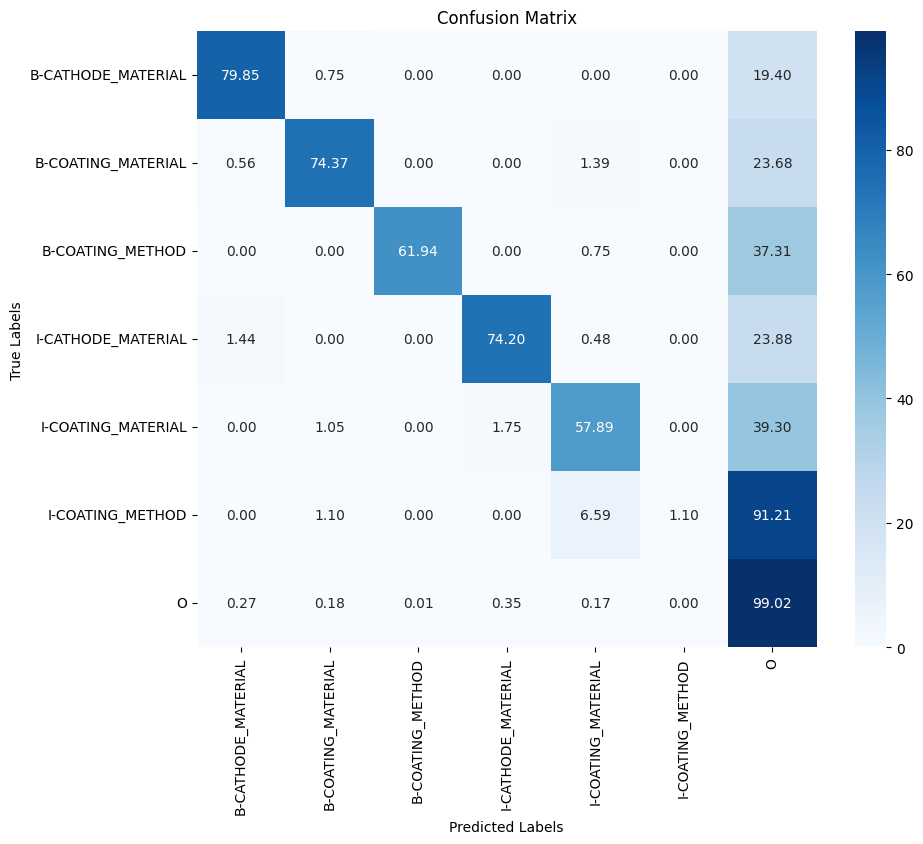

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relatively', 'low', 'cont

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_basebert_battery_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.719  0.845  0.777     420                
COATING_MATERIAL     0.700  0.808  0.750     359                
COATING_METHOD       0.752  0.746  0.749     134                
OVERALL              0.716  0.816  0.763            0.979  0.831

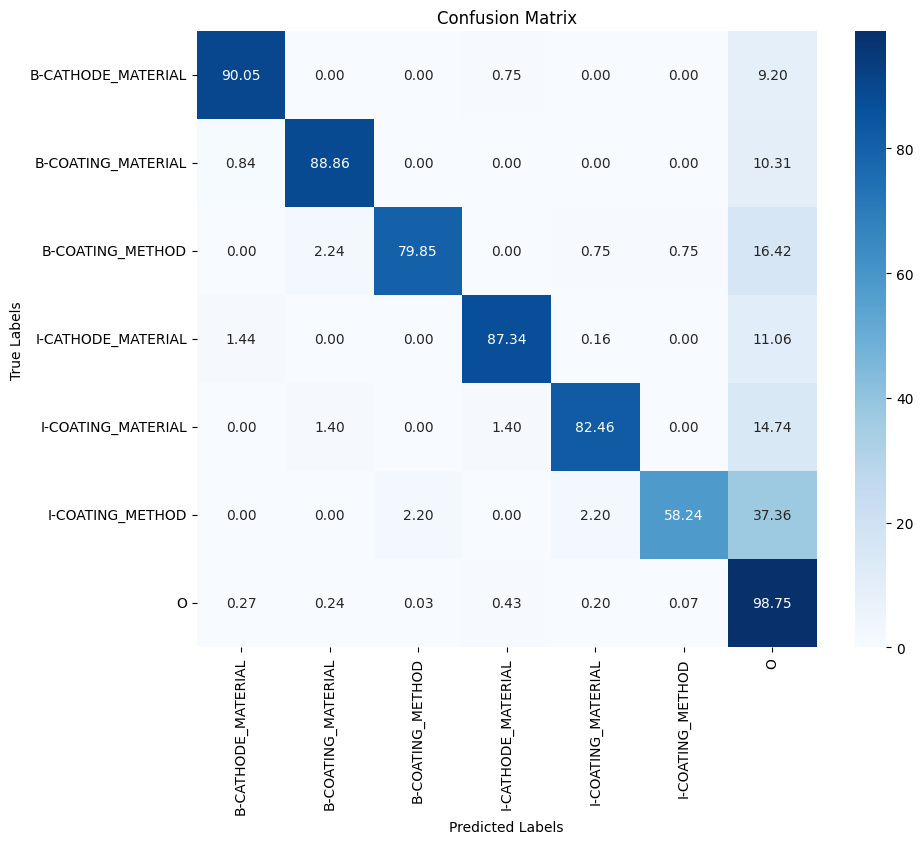

Displaying the first 5 mismatched passages:
Passage 2:
Tokens: ['The', 'relatively', 'low', 'content', 'of', 'organic', 'CEI', 'components', 'indicates', 'the', 'reduced', 'electrode', '/', 'electrolyte', 'side', 'reactions', ',', 'validating', 'the', 'suppressed', 'lattice', 'oxygen', 'oxidizing', 'ability', 'of', 'the', 'spinel', 'phase', '(', 'Co3O4', 'and', 'Co2TiO4', '/', 'CoAl2O4', ')', 'for', 'LATP', '@', 'LCO', '-', '700', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 5:
Tokens: ['(', '33', ')', 'Then', 'the', 'gassing', 'behavior', 'of', 'the', 'c

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_scibert_battery_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.629  0.679  0.653     420                
COATING_MATERIAL     0.655  0.694  0.674     359                
COATING_METHOD       0.660  0.231  0.343     134                
OVERALL              0.642  0.619  0.630            0.970  0.729

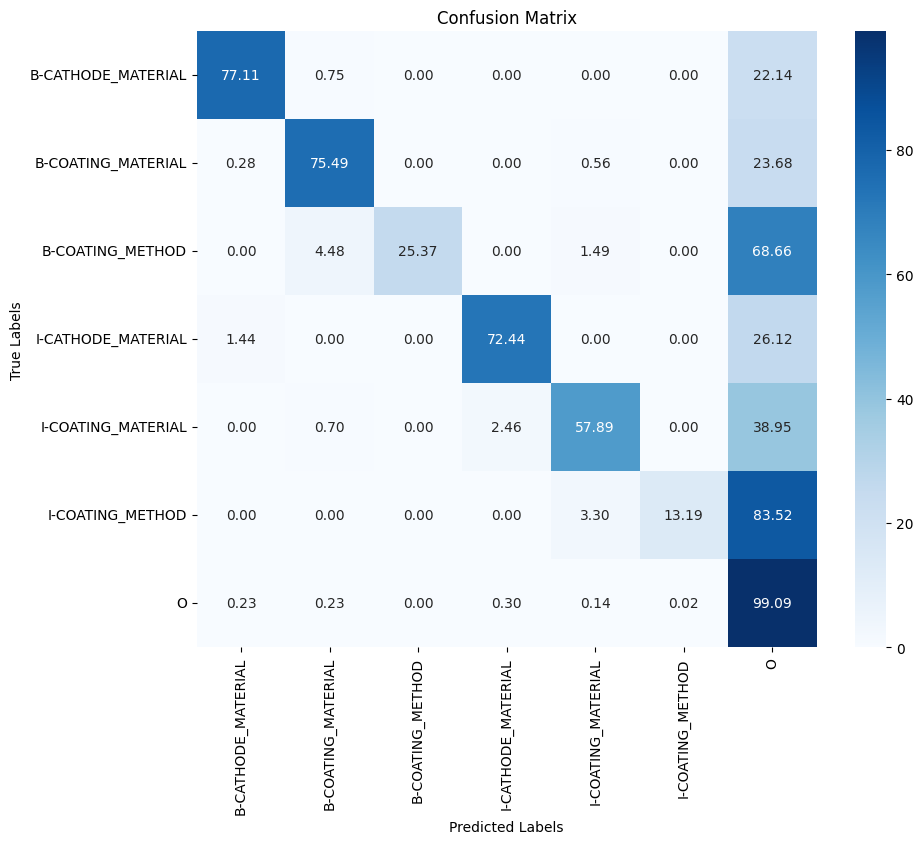

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relatively', 'low', 'cont

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_scibert_battery_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.738  0.871  0.799     420                
COATING_MATERIAL     0.729  0.811  0.768     359                
COATING_METHOD       0.715  0.731  0.723     134                
OVERALL              0.732  0.827  0.776            0.980  0.834

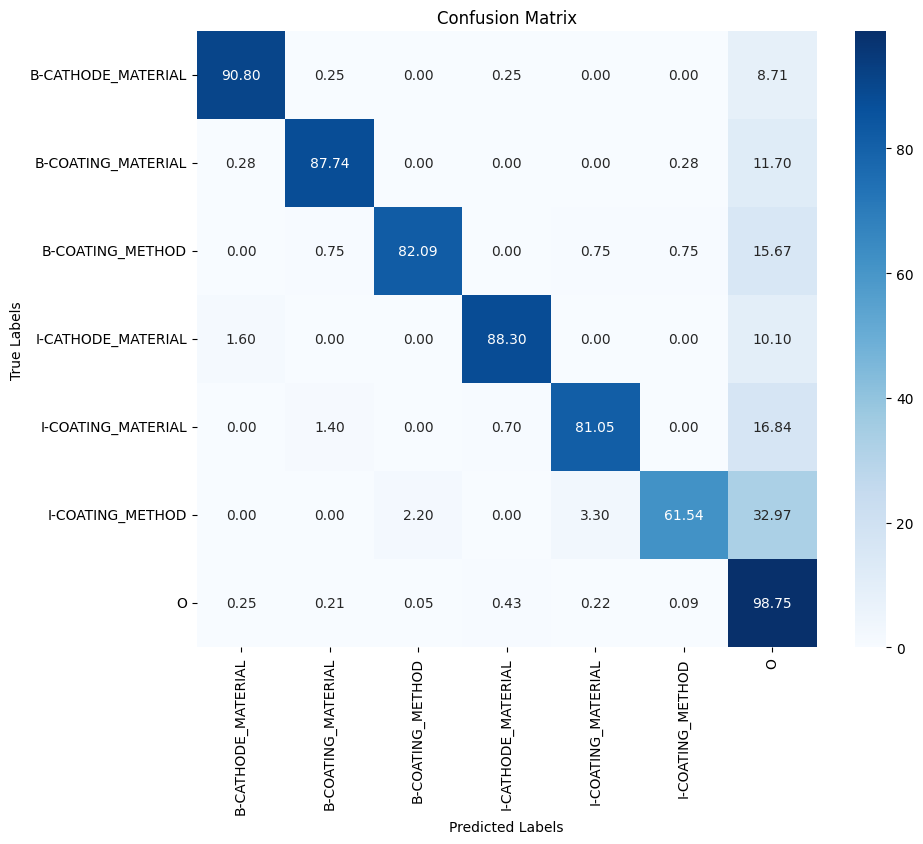

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relative

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_spanbert_battery_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.648  0.667  0.657     420                
COATING_MATERIAL     0.593  0.593  0.593     359                
COATING_METHOD       0.794  0.373  0.508     134                
OVERALL              0.636  0.595  0.615            0.967  0.695

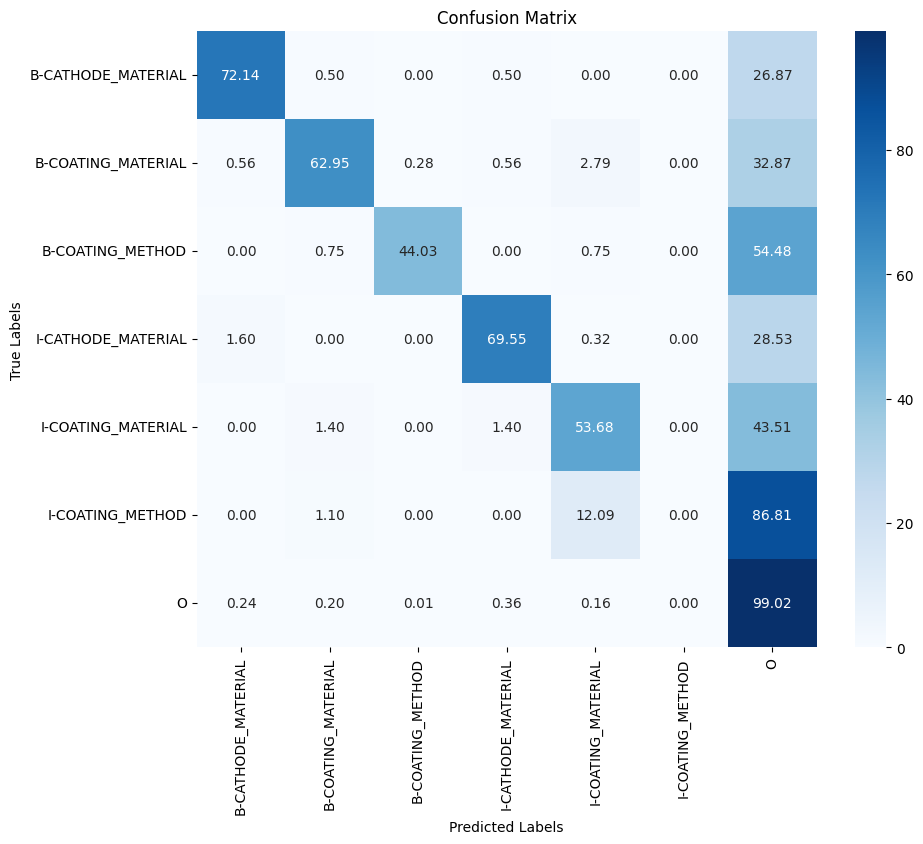

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relatively', 'low', 'cont

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_spanbert_battery_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.721  0.855  0.782     420                
COATING_MATERIAL     0.693  0.825  0.753     359                
COATING_METHOD       0.745  0.761  0.753     134                
OVERALL              0.713  0.829  0.767            0.979  0.834

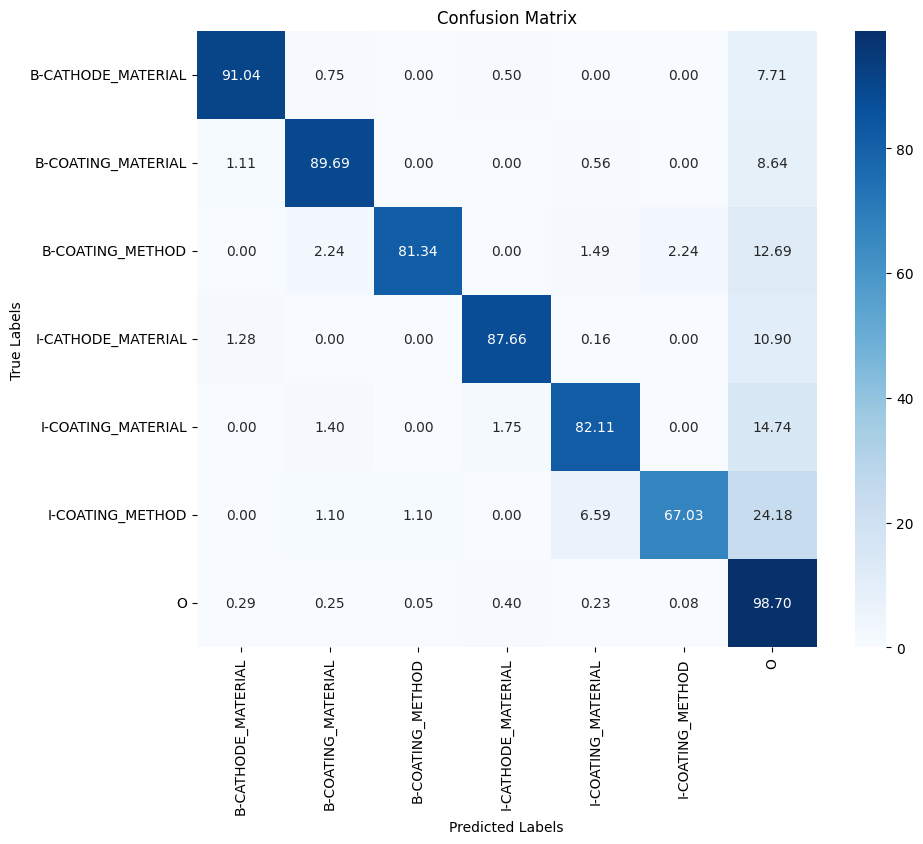

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relative

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_basebert_battery_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.750  0.850  0.797     420                
COATING_MATERIAL     0.714  0.805  0.757     359                
COATING_METHOD       0.765  0.754  0.759     134                
OVERALL              0.737  0.818  0.776            0.981  0.841

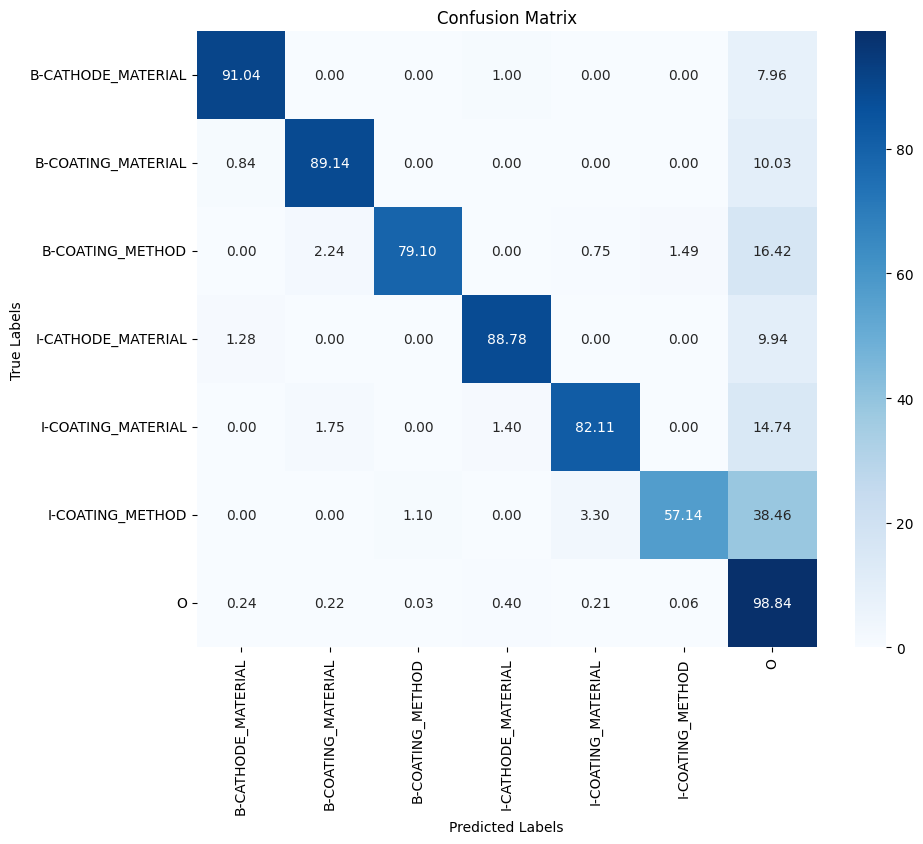

Displaying the first 5 mismatched passages:
Passage 2:
Tokens: ['The', 'relatively', 'low', 'content', 'of', 'organic', 'CEI', 'components', 'indicates', 'the', 'reduced', 'electrode', '/', 'electrolyte', 'side', 'reactions', ',', 'validating', 'the', 'suppressed', 'lattice', 'oxygen', 'oxidizing', 'ability', 'of', 'the', 'spinel', 'phase', '(', 'Co3O4', 'and', 'Co2TiO4', '/', 'CoAl2O4', ')', 'for', 'LATP', '@', 'LCO', '-', '700', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 5:
Tokens: ['(', '33', ')', 'Then', 'the', 'gassing', 'behavior', 'of', 'the', 'c

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_scibert_battery_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.773  0.843  0.806     420                
COATING_MATERIAL     0.754  0.819  0.785     359                
COATING_METHOD       0.769  0.746  0.758     134                
OVERALL              0.765  0.819  0.791            0.981  0.845

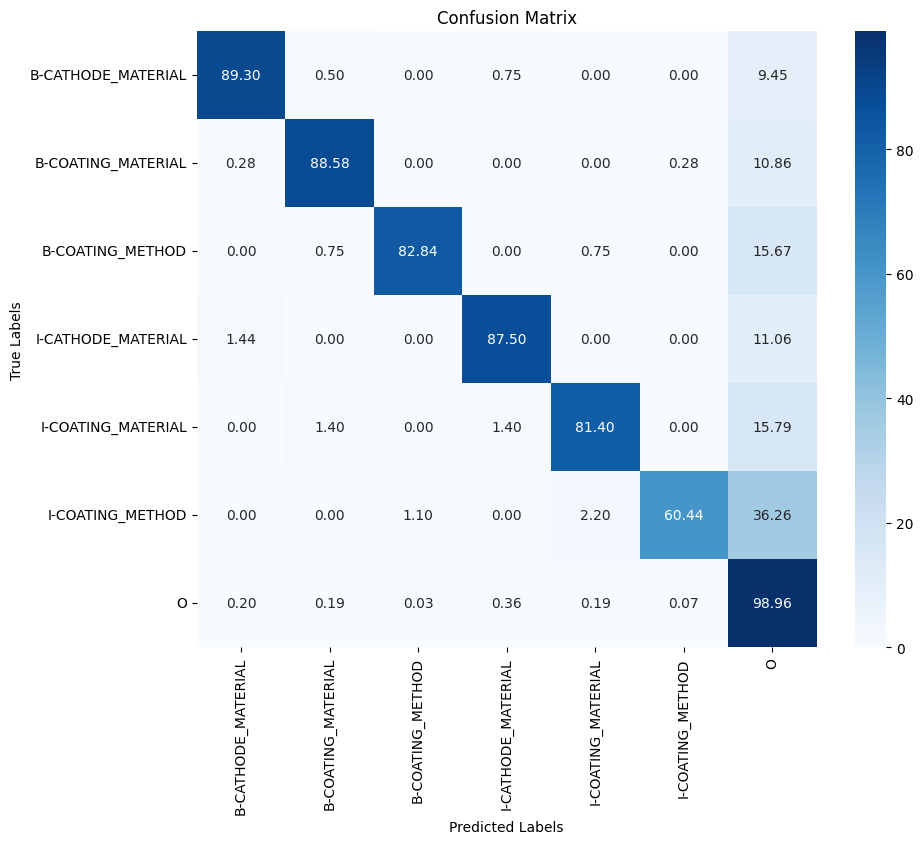

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relative

Map:   0%|          | 0/2550 [00:00<?, ? examples/s]

Map:   0%|          | 0/450 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_spanbert_battery_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.719  0.836  0.773     420                
COATING_MATERIAL     0.702  0.827  0.760     359                
COATING_METHOD       0.750  0.716  0.733     134                
OVERALL              0.716  0.815  0.762            0.979  0.833

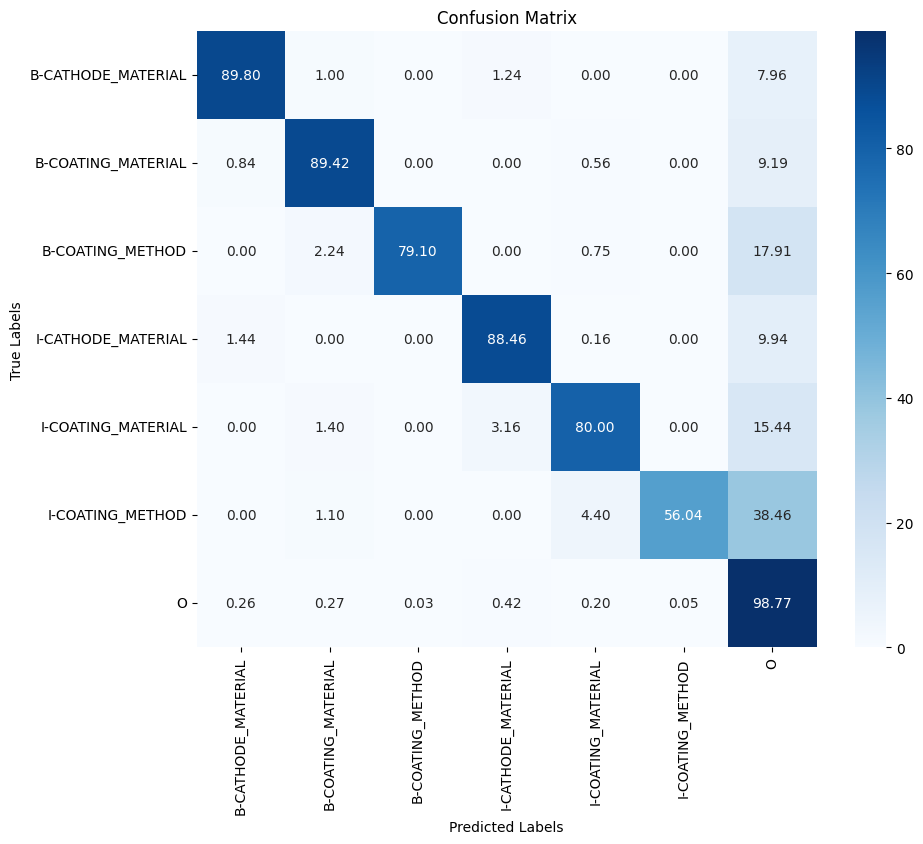

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relative

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_basebert_catalyst_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.383  0.523  0.442     153                
OLEFIN           0.593  0.761  0.667     356                
PRE_CATALYST     0.463  0.620  0.530      71                
SOLVENT          0.800  0.611  0.693     131                
SUPPORT          0.586  0.494  0.536      83                
OVERALL          0.554  0.650  0.598            0.985  0.742

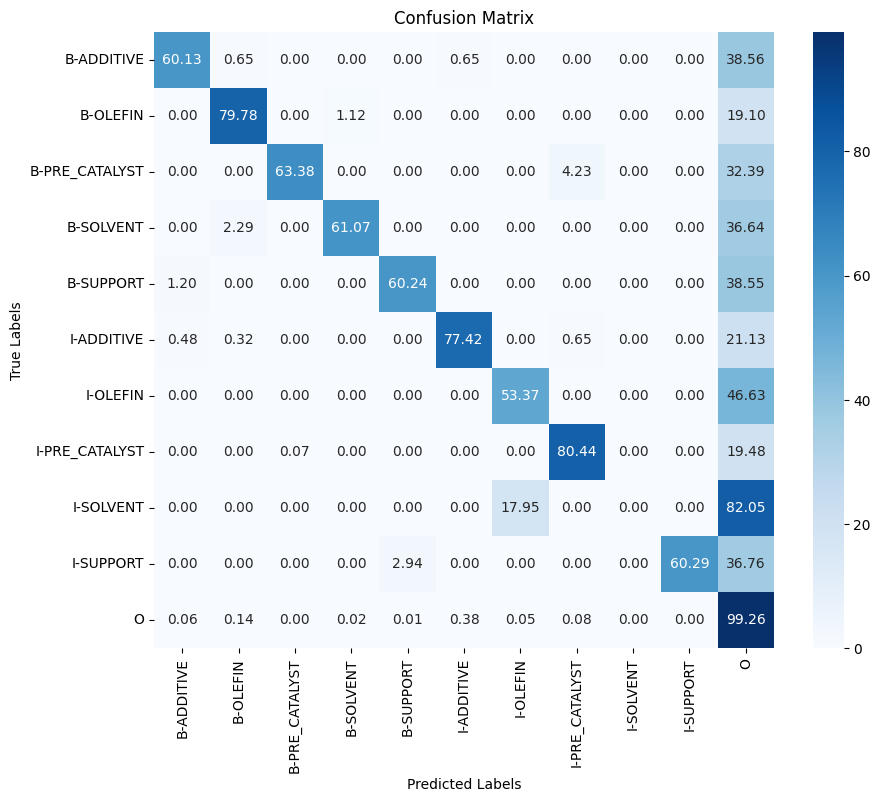

Displaying the first 5 mismatched passages:
Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',', '3', '-', 'methyl', '-', '1', '-', 'pentene', ',', '4', '-', 'methyl', '-', '1', '-', 'pentene', ',', '1', '-', 'octene', ',', '1', '-', 'decene', ',', 'long', 'chain', 'macromolecular', '(', 'x', '-', 'olefins', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels:

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_basebert_catalyst_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.500  0.732  0.594     153                
OLEFIN           0.592  0.803  0.682     356                
PRE_CATALYST     0.667  0.873  0.756      71                
SOLVENT          0.742  0.748  0.745     131                
SUPPORT          0.750  0.867  0.804      83                
OVERALL          0.613  0.793  0.692            0.986  0.774

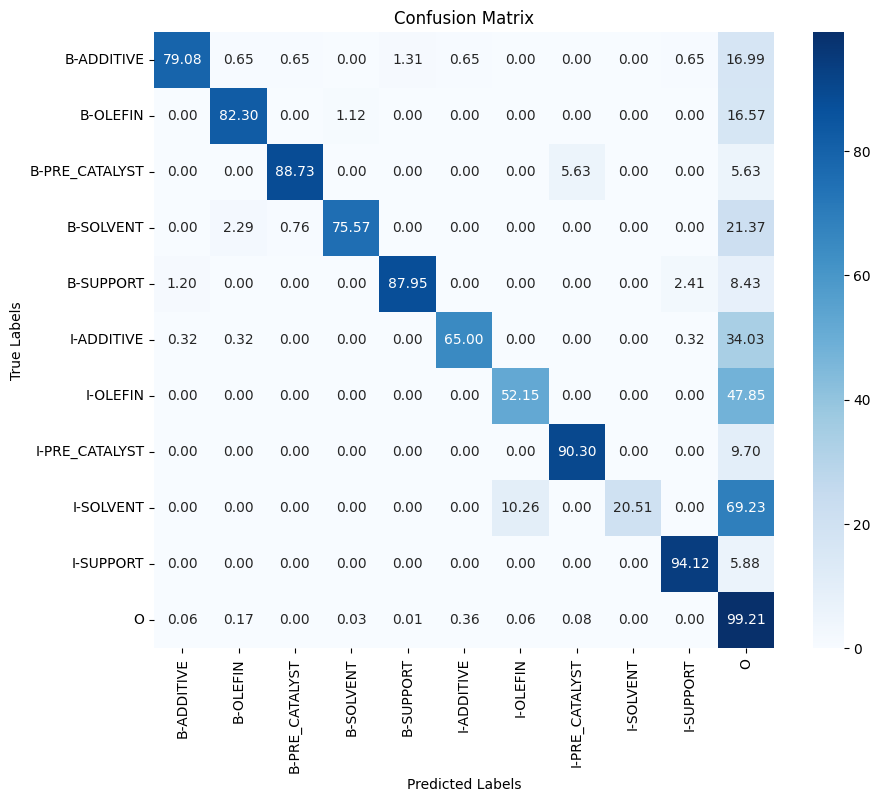

Displaying the first 5 mismatched passages:
Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',', '3', '-', 'methyl', '-', '1', '-', 'pentene', ',', '4', '-', 'methyl', '-', '1', '-', 'pentene', ',', '1', '-', 'octene', ',', '1', '-', 'decene', ',', 'long', 'chain', 'macromolecular', '(', 'x', '-', 'olefins', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels:

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_scibert_catalyst_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.360  0.582  0.445     153                
OLEFIN           0.595  0.809  0.686     356                
PRE_CATALYST     0.565  0.676  0.615      71                
SOLVENT          0.882  0.573  0.694     131                
SUPPORT          0.633  0.458  0.531      83                
OVERALL          0.560  0.678  0.613            0.986  0.760

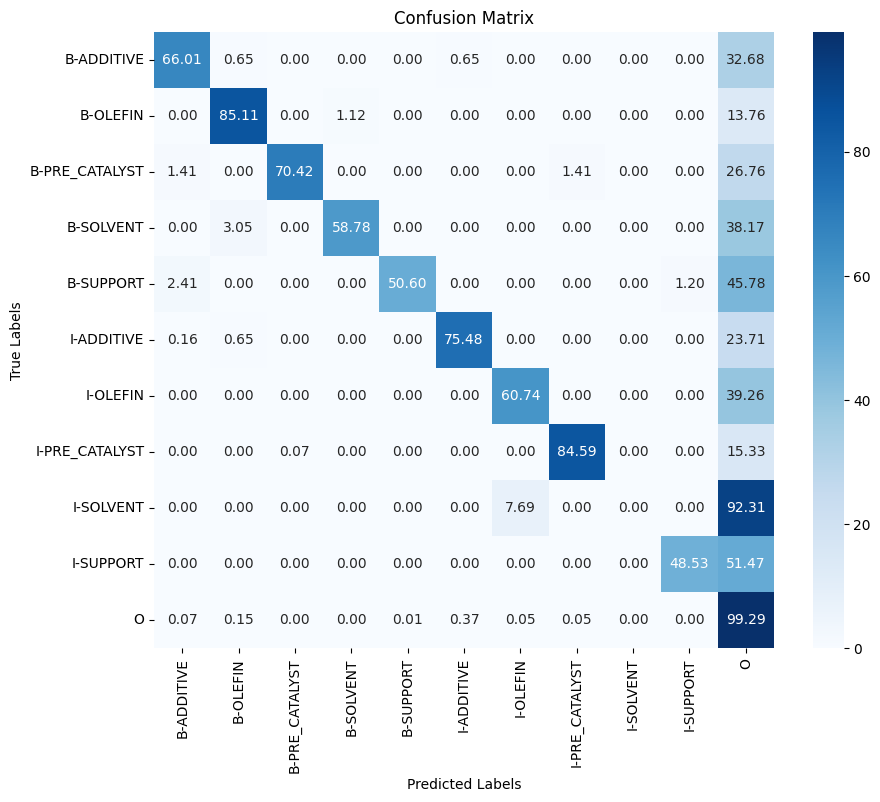

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_scibert_catalyst_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.523  0.752  0.617     153                
OLEFIN           0.583  0.826  0.684     356                
PRE_CATALYST     0.717  0.930  0.810      71                
SOLVENT          0.786  0.756  0.770     131                
SUPPORT          0.701  0.904  0.789      83                
OVERALL          0.619  0.817  0.704            0.987  0.780

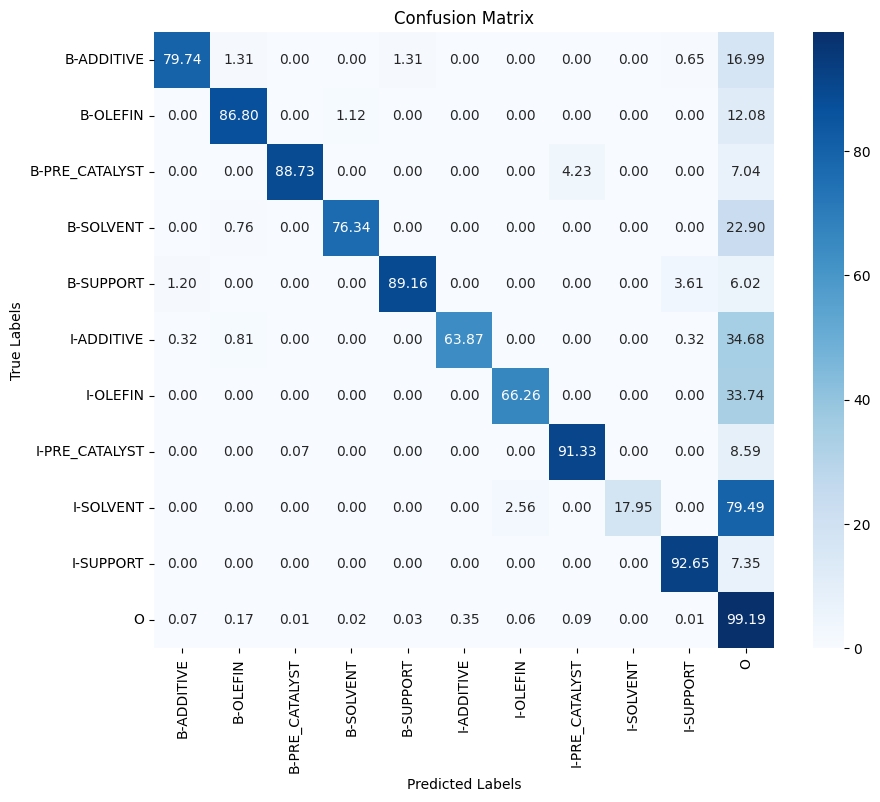

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_spanbert_catalyst_none_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.300  0.353  0.324     153                
OLEFIN           0.579  0.688  0.629     356                
PRE_CATALYST     0.418  0.465  0.440      71                
SOLVENT          0.924  0.466  0.619     131                
SUPPORT          0.411  0.277  0.331      83                
OVERALL          0.517  0.524  0.521            0.984  0.715

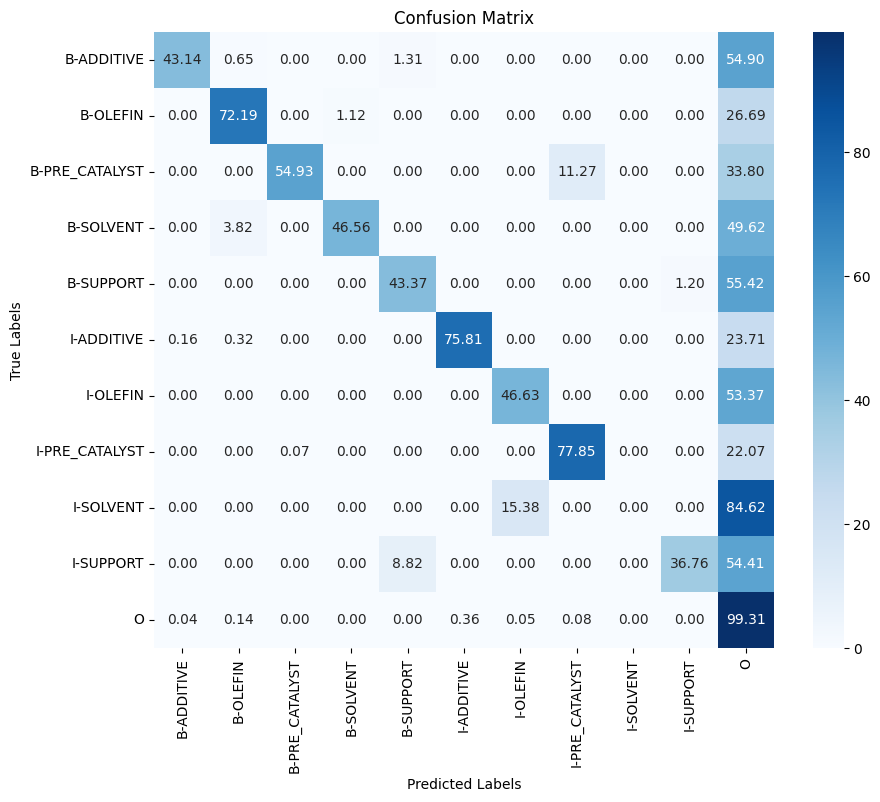

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____B_spanbert_catalyst_all_last_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.457  0.621  0.526     153                
OLEFIN           0.554  0.792  0.652     356                
PRE_CATALYST     0.596  0.831  0.694      71                
SOLVENT          0.798  0.664  0.725     131                
SUPPORT          0.636  0.843  0.725      83                
OVERALL          0.573  0.747  0.648            0.984  0.735

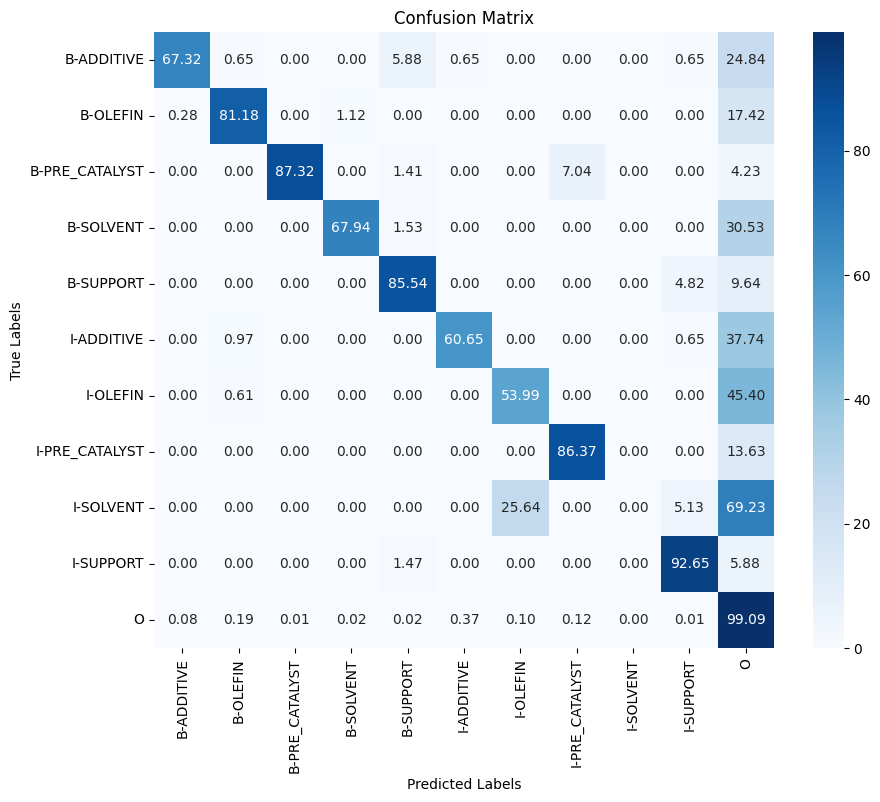

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_basebert_catalyst_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.466  0.719  0.566     153                
OLEFIN           0.566  0.809  0.666     356                
PRE_CATALYST     0.638  0.845  0.727      71                
SOLVENT          0.746  0.740  0.743     131                
SUPPORT          0.747  0.892  0.813      83                
OVERALL          0.589  0.792  0.676            0.986  0.767

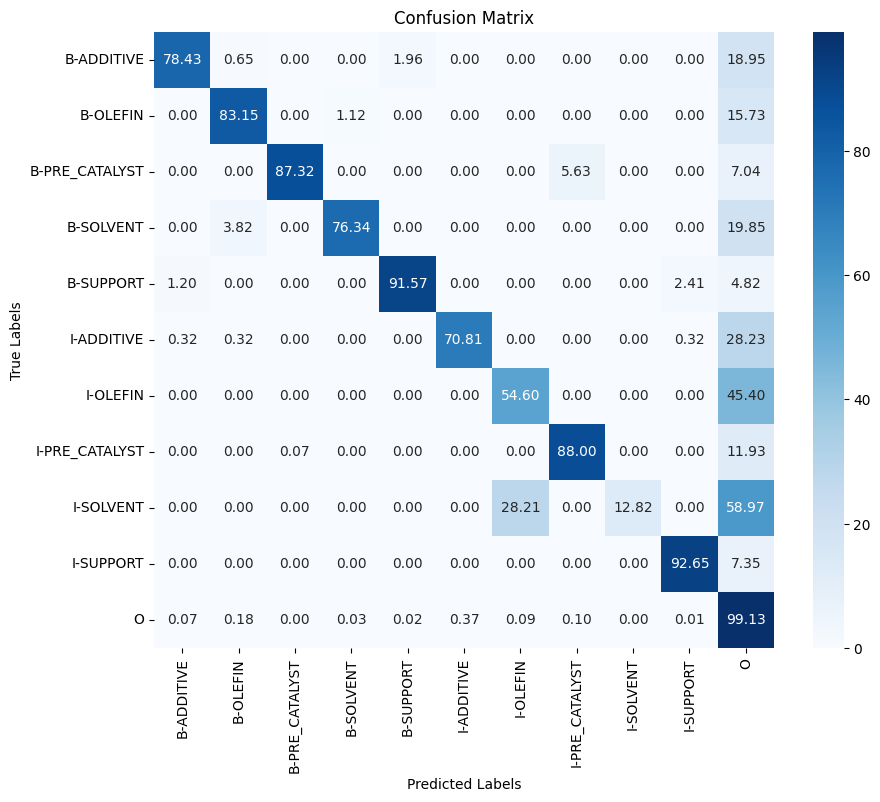

Displaying the first 5 mismatched passages:
Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',', '3', '-', 'methyl', '-', '1', '-', 'pentene', ',', '4', '-', 'methyl', '-', '1', '-', 'pentene', ',', '1', '-', 'octene', ',', '1', '-', 'decene', ',', 'long', 'chain', 'macromolecular', '(', 'x', '-', 'olefins', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels:

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_scibert_catalyst_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.483  0.745  0.586     153                
OLEFIN           0.623  0.868  0.725     356                
PRE_CATALYST     0.700  0.887  0.783      71                
SOLVENT          0.810  0.779  0.794     131                
SUPPORT          0.705  0.892  0.787      83                
OVERALL          0.629  0.834  0.717            0.987  0.789

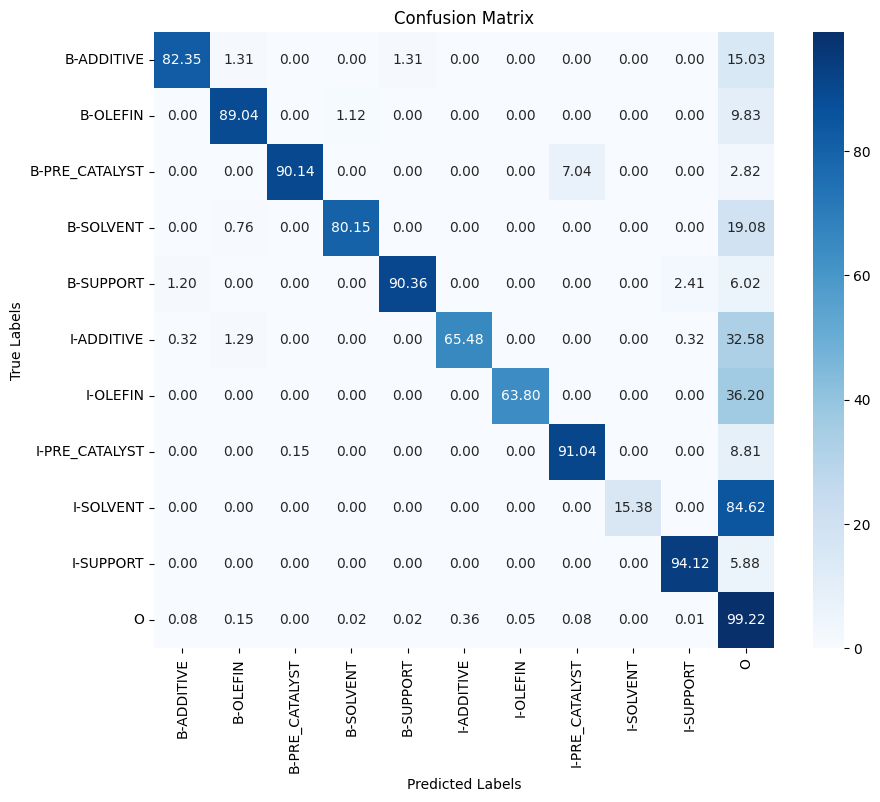

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

Map:   0%|          | 0/8409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1485 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


_____C_spanbert_catalyst_all_concat_ENSEMBLE_____

Final evaluation metrics for train set

Final evaluation metrics for validation set

Final evaluation metrics for evaluation set


Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.421  0.627  0.504     153                
OLEFIN           0.585  0.789  0.672     356                
PRE_CATALYST     0.615  0.789  0.691      71                
SOLVENT          0.798  0.634  0.706     131                
SUPPORT          0.700  0.843  0.765      83                
OVERALL          0.584  0.738  0.652            0.986  0.764

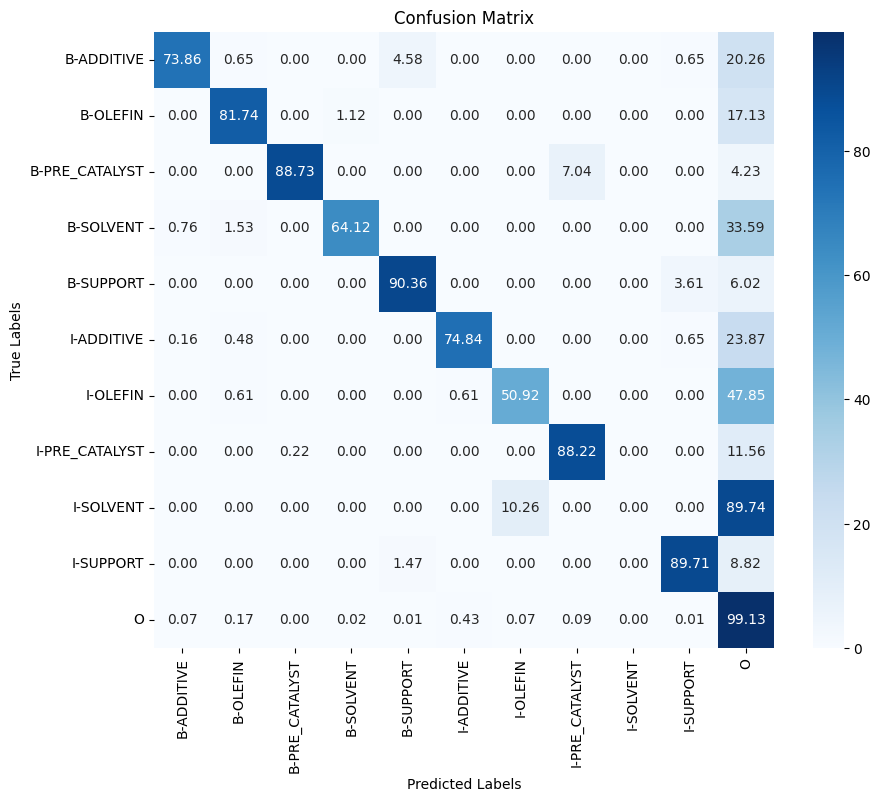

Displaying the first 5 mismatched passages:
Passage 1:
Tokens: ['2', 'Hz', ')', ',', '0', '.', '66', '(', 's', ',', '3H', ')', ',', '0', '.', '64', '(', 's', ',', '3H', ')', ',', '0', '.', '58', '(', 's', ',', '3H', ')', ',', '0', '.', '57', '(', 's', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['and', 'BA', '?', 'to', 'BG', '?', 'except', 'substitute', 'BOMATPB', 'for', 'BOMATPBmix', '.', 'Preferred', 'monomers', 'include', 'the', 'C2', '-', '20', '?', '-', 'olefins', 'especially', 'ethylene', ',', 'propylene', ',', 'isobutylene', ',', '1', '-', 'butene', ',', '1', '-', 'pentene', ',', '1', '-', 'hexene', ',

In [ ]:
MAX_LEN = 256
LABEL_PAD_TOKEN_ID = -100

# Function to score the majority-vote predictions for a given dataset
def score_ensemble_predictions(top_3_specs, dataset):

    # Create a list to store all ENSEMBLE models' scores
    all_scores = []

    for config_number in range(len((top_3_specs))):

        if top_3_specs[config_number][0]['model_prefix'] == 'B_basebert':
            checkpoint = 'bert-base-cased'
        elif top_3_specs[config_number][0]['model_prefix'] == 'B_scibert':
            checkpoint = 'allenai/scibert_scivocab_cased'
        elif top_3_specs[config_number][0]['model_prefix'] == 'B_spanbert':
            checkpoint = 'SpanBERT/spanbert-base-cased'
        elif top_3_specs[config_number][0]['model_prefix'] == 'C_basebert':
            checkpoint = 'bert-base-cased'
        elif top_3_specs[config_number][0]['model_prefix'] == 'C_scibert':
            checkpoint = 'allenai/scibert_scivocab_cased'
        elif top_3_specs[config_number][0]['model_prefix'] == 'C_spanbert':
            checkpoint = 'SpanBERT/spanbert-base-cased'

        global TOKENIZER
        TOKENIZER = AutoTokenizer.from_pretrained(checkpoint)

        if dataset == 'battery':
            train_predictions = ensemble_predictions_battery_train[config_number]
            val_predictions = ensemble_predictions_battery_val[config_number]
            eval_predictions = ensemble_predictions_battery_eval[config_number]
            battery_train = datasets['battery']['train'].map(tokenize_and_align_labels, batched=True)
            battery_val = datasets['battery']['val'].map(tokenize_and_align_labels, batched=True)
            battery_eval = datasets['battery']['eval'].map(tokenize_and_align_labels, batched=True)
            hf_train, hf_val, hf_eval = battery_train, battery_val, battery_eval
            tf_battery_train, tf_battery_val, tf_battery_eval= prepare_tf_datasets(battery_train, battery_val, battery_eval, TOKENIZER)
            tf_train, tf_val, tf_eval = tf_battery_train, tf_battery_val, tf_battery_eval
            NUM_SAMPLES = len(battery_train)
            LABEL_LIST = battery_label_list
            ID2LABEL = battery_id2label
            LABEL2ID = battery_label2id

        elif dataset == 'catalyst':
            train_predictions = ensemble_predictions_catalyst_train[config_number]
            val_predictions = ensemble_predictions_catalyst_val[config_number]
            eval_predictions = ensemble_predictions_catalyst_eval[config_number]
            catalyst_train = datasets['catalyst']['train'].map(tokenize_and_align_labels, batched=True)
            catalyst_val = datasets['catalyst']['val'].map(tokenize_and_align_labels, batched=True)
            catalyst_eval = datasets['catalyst']['eval'].map(tokenize_and_align_labels, batched=True)
            hf_train, hf_val, hf_eval = catalyst_train, catalyst_val, catalyst_eval
            tf_catalyst_train, tf_catalyst_val, tf_catalyst_eval = prepare_tf_datasets(catalyst_train, catalyst_val, catalyst_eval, TOKENIZER)
            tf_train, tf_val, tf_eval = tf_catalyst_train, tf_catalyst_val, tf_catalyst_eval
            NUM_SAMPLES = len(catalyst_train)
            LABEL_LIST = catalyst_label_list
            ID2LABEL = catalyst_id2label
            LABEL2ID = catalyst_label2id

        # Extract metadata
        model_name = top_3_specs[config_number][0]['model_prefix']
        train_strategy = top_3_specs[config_number][0]['train_strategy']
        ff_strategy = top_3_specs[config_number][0]['ff_strategy']

        # Print the model configuration
        print(f"_____{model_name}_{dataset}_{train_strategy}_{ff_strategy}_ENSEMBLE_____")

        # Convert predictions from list of dicts to dict of lists
        eval_pred_dict = convert_predictions_to_dict(eval_predictions)

        # Compute MCC score
        mcc_score_train = compute_MCC.compute_MCC_jsonl(
            hf_train, train_predictions, id_col='id')
        mcc_score_val = compute_MCC.compute_MCC_jsonl(
            hf_val, val_predictions, id_col='id')
        mcc_score_eval = compute_MCC.compute_MCC_jsonl(
            hf_eval, eval_predictions, id_col='id')

        # Compute Seqeval scores
        seqeval_scores_train = compute_seqeval.compute_seqeval_jsonl(
            hf_train, train_predictions, id_col='id')
        seqeval_scores_val = compute_seqeval.compute_seqeval_jsonl(
            hf_val, val_predictions, id_col='id')
        seqeval_scores_eval = compute_seqeval.compute_seqeval_jsonl(
            hf_eval, eval_predictions, id_col='id')

        # Display final evaluation metrics
        print("\nFinal evaluation metrics for train set")
        scores_train = display_metrics_details(mcc_score_train, seqeval_scores_train, show=False)
        print("\nFinal evaluation metrics for validation set")
        scores_val = display_metrics_details(mcc_score_val, seqeval_scores_val, show=False)
        print("\nFinal evaluation metrics for evaluation set")
        scores_eval = display_metrics_details(mcc_score_eval, seqeval_scores_eval, show=True)

        # Store scores as dataframes
        scores = {
            'train': scores_train,
            'val': scores_val,
            'eval': scores_eval}

        # Save the evaluation metrics
        save_metrics_details(
            scores_train, model_replicate_name+'_train_scores', upload_choice=False)
        save_metrics_details(
            scores_val, model_replicate_name+'_val_scores', upload_choice=False)
        save_metrics_details(
            scores_eval, model_replicate_name+'_eval_scores', upload_choice=False)


        # Generate confusion matrix for the evaluation split
        plot_confusion_matrix(hf_eval, eval_pred_dict, LABEL_LIST)

        # Inspect passages with mismatched tokens for the evaluation split
        display_mismatched_passages(hf_eval, eval_pred_dict, N=5)

        # Append the model data to all_models
        model_data = {
            'model_prefix': model_name,
            'dataset': dataset,
            'train_strategy': train_strategy,
            'ff_strategy': ff_strategy,
            'batch_size': 'multi',
            'init_lr': 'multi',
            'replicate': 'multi',
            'scores': scores}
        all_scores.append(model_data)

    # Save all_scores to local workspace
    with open(f"ensemble_{dataset}_scores.pkl", 'wb') as f:
        pickle.dump(all_scores, f)

    # Upload all_Scores file to GitHub
    save_pickle(all_scores, f"ensemble_{dataset}_scores", upload_choice=True)

    return all_scores

# Score the ensemble predictions for each model configuration, for both datasets, then save the metrics
ensemble_scores_battery = score_ensemble_predictions(top_3_specs, 'battery')
ensemble_scores_catalyst = score_ensemble_predictions(top_3_specs, 'catalyst')

In [ ]:
for ensemble_scores in ensemble_scores_catalyst:
  print(ensemble_scores)

{'model_prefix': 'B_basebert', 'dataset': 'catalyst', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 'multi', 'init_lr': 'multi', 'replicate': 'multi', 'scores': {'train':              Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.580  0.673  0.623     822                
OLEFIN           0.643  0.820  0.721    1137                
PRE_CATALYST     0.586  0.679  0.629     315                
SOLVENT          0.694  0.651  0.672     352                
SUPPORT          0.671  0.587  0.626     392                
OVERALL          0.627  0.715  0.668            0.988  0.849, 'val':              Precision Recall     F1 Support Accuracy    MCC
Label                                                       
ADDITIVE         0.569  0.587  0.578     126                
OLEFIN           0.620  0.673  0.645     150                
PRE_CATALYST     0.483  0.569  0.523      51                
SOLVENT  

In [ ]:

# Inspect data structure
for i in range(len(top_3_specs)):
  print(len(top_3_specs)) # should be 7
  print(top_3_specs[i][0])
  print(ensemble_scores_battery[0]['scores'].keys())

print(len(ensemble_scores_battery)) # should be 7

9
{'model_prefix': 'B_basebert', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'B_basebert', 'train_strategy': 'all', 'ff_strategy': 'last', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'B_scibert', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'B_scibert', 'train_strategy': 'all', 'ff_strategy': 'last', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'B_spanbert', 'train_strategy': 'none', 'ff_strategy': 'concat', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'B_spanbert', 'train_strategy': 'all', 'ff_strategy': 'last', 'batch_size': 16, 'init_lr': 8e-05}
dict_keys(['train', 'val', 'eval'])
9
{'model_prefix': 'C_basebert', 'train_strategy': 'all', 'ff_strategy': 'c

## 7.3 Ensemble statistics (D experiments)

### Setup basic data structures

In [ ]:
# Create the full list of scores, with each element corresponding to an ensemble model
ensemble_scores_list = []
for dataset in ['battery', 'catalyst']:
   partial_scores_list = load_pickle(f"ensemble_{dataset}_scores")
   ensemble_scores_list.extend(partial_scores_list)

# Insp6ct structure of the data to confirm it's the same as scores_list
i = 6
print(type(ensemble_scores_list)) # should be a list of 14 dicts, and each element should have keys for metadata, including the key 'scores' which itself is a dict w/ 3 splits
print(len(ensemble_scores_list))
print(type(ensemble_scores_list[i]))
print(ensemble_scores_list[i].keys())
print(ensemble_scores_list[i]['scores'].keys())
print(type(ensemble_scores_list[i]['scores']['train']))
print(f"{ensemble_scores_list[i]['model_prefix']}_{ensemble_scores_list[i]['dataset']}_{ensemble_scores_list[i]['train_strategy']}_{ensemble_scores_list[i]['ff_strategy']}_{ensemble_scores_list[i]['batch_size']}_{ensemble_scores_list[i]['init_lr']}_{ensemble_scores_list[i]['replicate']}")
print(type(ensemble_scores_list[i]['scores']['train']))
display(ensemble_scores_list[i]['scores']['eval'])

<class 'list'>
18
<class 'dict'>
dict_keys(['model_prefix', 'dataset', 'train_strategy', 'ff_strategy', 'batch_size', 'init_lr', 'replicate', 'scores'])
dict_keys(['train', 'val', 'eval'])
<class 'pandas.core.frame.DataFrame'>
C_basebert_battery_all_concat_multi_multi_multi
<class 'pandas.core.frame.DataFrame'>


Precision Recall     F1 Support Accuracy    MCC
Label                                                           
CATHODE_MATERIAL     0.725  0.848  0.782     420                
COATING_MATERIAL     0.714  0.808  0.758     359                
COATING_METHOD       0.770  0.724  0.746     134                
OVERALL              0.726  0.814  0.768            0.980  0.836

In [ ]:
## 7.3.2 - Compute score means and standard deviations (down to the label level)

# Function to compute mean and std for a list of dataframes
def compute_mean_std(dfs):
    # Combine dataframes for computation
    combined = pd.concat(dfs, axis=0)

    # Convert non-numeric values to NaN
    combined = combined.apply(pd.to_numeric, errors='coerce')

    # Compute mean and std
    means = combined.groupby(level=0).mean()
    stds = combined.groupby(level=0).std()

    # Merge results
    result = pd.concat([means, stds], keys=['Mean', 'Stdev'], axis=1)

    # Temporarily suppress FutureWarnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", FutureWarning)
        # Ensure 'Overall' has mean and std for 'Accuracy' and 'MCC'
        if 'OVERALL' in result.index:
            result.loc['OVERALL'] = result.loc['OVERALL'].ffill()

    return result

# Function to compute the statistical scores list
def compute_stat_scores_list(scores_list, n_replicates):
    # List to store the statistical dataframes
    stat_scores_list = []

    # Iterate over the unique combinations of parameters
    for i in range(0, len(scores_list), n_replicates):
        # Extract parameters
        try:
            params = scores_list[i]
            pretrained_model = params['model_prefix']
            dataset = params['dataset']
            train_strategy = params['train_strategy']
            ff_strategy = params['ff_strategy']
            batch_size = params['batch_size']
            init_lr = params['init_lr']
        except KeyError as e:
            print(f"KeyError: {e} in entry {params}")
            continue

        # Initialize storage for replicates
        replicate_data = {
            'train': [],
            'val': [],
            'eval': []
        }

        # Collect replicate data
        for j in range(n_replicates):
            replicate_data['train'].append(scores_list[i + j]['scores']['train'])
            replicate_data['val'].append(scores_list[i + j]['scores']['val'])
            replicate_data['eval'].append(scores_list[i + j]['scores']['eval'])

        # Compute statistics for train, val, and eval splits
        stat_scores = {
            'train': compute_mean_std(replicate_data['train']),
            'val': compute_mean_std(replicate_data['val']),
            'eval': compute_mean_std(replicate_data['eval'])
        }

        # Append to the list
        stat_scores_list.append({
            'model_prefix': pretrained_model,
            'dataset': dataset,
            'train_strategy': train_strategy,
            'ff_strategy': ff_strategy,
            'batch_size': batch_size,
            'init_lr': init_lr,
            'stat_scores': stat_scores
        })

    return stat_scores_list

# Create full list of score statistics
ensemble_stat_scores_list = compute_stat_scores_list(ensemble_scores_list, n_replicates=1)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(ensemble_stat_scores_list)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect an example
i = 6
print(type(ensemble_stat_scores_list))
print(len(ensemble_stat_scores_list))
print(type(ensemble_stat_scores_list[i]))
print(ensemble_stat_scores_list[i].keys())
print(ensemble_stat_scores_list[i]['stat_scores'].keys())
print(type(ensemble_stat_scores_list[i]['stat_scores']['train']))
print(f"{ensemble_stat_scores_list[i]['model_prefix']}_{ensemble_stat_scores_list[i]['dataset']}_{ensemble_stat_scores_list[i]['train_strategy']}_{ensemble_stat_scores_list[i]['ff_strategy']}_{ensemble_stat_scores_list[i]['batch_size']}_{ensemble_stat_scores_list[i]['init_lr']}")
print(type(ensemble_stat_scores_list[i]['stat_scores']['train']))
display(ensemble_stat_scores_list[i]['stat_scores']['eval'])

Deep size of example_dict: 1.7132339477539062 megabytes
<class 'list'>
18
<class 'dict'>
dict_keys(['model_prefix', 'dataset', 'train_strategy', 'ff_strategy', 'batch_size', 'init_lr', 'stat_scores'])
dict_keys(['train', 'val', 'eval'])
<class 'pandas.core.frame.DataFrame'>
C_basebert_battery_all_concat_multi_multi
<class 'pandas.core.frame.DataFrame'>


Mean                                            Stdev  \
                 Precision Recall     F1  Support Accuracy    MCC Precision   
Label                                                                         
CATHODE_MATERIAL     0.725  0.848  0.782  420.000      NaN    NaN       NaN   
COATING_MATERIAL     0.714  0.808  0.758  359.000      NaN    NaN       NaN   
COATING_METHOD       0.770  0.724  0.746  134.000      NaN    NaN       NaN   
OVERALL              0.726  0.814  0.768    0.768     0.98  0.836     0.836   

                                                        
                 Recall     F1 Support Accuracy    MCC  
Label                                                   
CATHODE_MATERIAL    NaN    NaN     NaN      NaN    NaN  
COATING_MATERIAL    NaN    NaN     NaN      NaN    NaN  
COATING_METHOD      NaN    NaN     NaN      NaN    NaN  
OVERALL           0.836  0.836   0.836    0.836  0.836

In [ ]:
## 7.3.3 - Consolidate all score statistics into a single comprehensive dataframe

# Function to consolidate score statistics into a single dataframe for all model specifications
def generate_stat_scores_df(stat_scores_list):
    # Create an empty DataFrame for summary
    stat_scores_specifications = pd.DataFrame()

    # Iterate over stat_scores_list to populate stat_scores_specifications
    for entry in stat_scores_list:
        model_prefix = entry['model_prefix']
        dataset = entry['dataset']
        train_strategy = entry['train_strategy']
        ff_strategy = entry['ff_strategy']
        batch_size = entry['batch_size']
        init_lr = entry['init_lr']

        # Extract statistical data
        for split in ['train', 'val', 'eval']:
            df = entry['stat_scores'][split].copy()
            df.insert(0, 'Model Prefix', model_prefix)
            df.insert(1, 'Dataset', dataset)
            df.insert(2, 'Train Strategy', train_strategy)
            df.insert(3, 'Feedforward Strategy', ff_strategy)
            df.insert(4, 'Batch Size', batch_size)
            df.insert(5, 'Init LR', init_lr)
            df.insert(6, 'Split', split)

            # Append to full DataFrame
            stat_scores_specifications = pd.concat([stat_scores_specifications, df.reset_index()], axis=0)

    # Reset index
    stat_scores_specifications.reset_index(drop=True, inplace=True)

    return stat_scores_specifications

# Generate full DataFrame where each row corresponds to a single model specification
ensemble_stat_scores_specifications = generate_stat_scores_df(ensemble_stat_scores_list)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(ensemble_stat_scores_specifications)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect an example
i = 32
print(type(ensemble_stat_scores_specifications))
print(len(ensemble_stat_scores_specifications))
#display(ensemble_stat_scores_specifications.head(10))
#display(ensemble_stat_scores_specifications[ensemble_stat_scores_specifications['Dataset']=='catalyst'].head(10))

# Display ensemble data
display(ensemble_stat_scores_specifications)

# Append ensemble data to stat_scores_specifications
expanded_stat_scores_specifications = pd.concat([ensemble_stat_scores_specifications, stat_scores_specifications], axis=0).reset_index(drop=True)

# Inspect the expanded data
print(type(expanded_stat_scores_specifications))
print(len(expanded_stat_scores_specifications))
display(expanded_stat_scores_specifications.head())
display(expanded_stat_scores_specifications.tail())

# Filtering the DataFrame based on some specified conditions
filtered_rows = expanded_stat_scores_specifications[
    (expanded_stat_scores_specifications['Model Prefix'] == 'C_scibert') &
    (expanded_stat_scores_specifications[('Dataset', '')] == 'battery') &
    (expanded_stat_scores_specifications[('Feedforward Strategy', '')] == 'concat') &
    (expanded_stat_scores_specifications[('Init LR', '')] == 'multi')
]
# Display the filtered rows
display(filtered_rows)

Deep size of example_dict: 0.35233306884765625 megabytes
<class 'pandas.core.frame.DataFrame'>
270


Label Model Prefix   Dataset Train Strategy  \
                                                              
0    CATHODE_MATERIAL   B_basebert   battery           none   
1    COATING_MATERIAL   B_basebert   battery           none   
2      COATING_METHOD   B_basebert   battery           none   
3             OVERALL   B_basebert   battery           none   
4    CATHODE_MATERIAL   B_basebert   battery           none   
..                ...          ...       ...            ...   
265            OLEFIN   C_spanbert  catalyst            all   
266           OVERALL   C_spanbert  catalyst            all   
267      PRE_CATALYST   C_spanbert  catalyst            all   
268           SOLVENT   C_spanbert  catalyst            all   
269           SUPPORT   C_spanbert  catalyst            all   

    Feedforward Strategy Batch Size Init LR  Split      Mean                \
                                                   Precision Recall     F1   
0                 concat      multi   multi  train     0.640  0.739  0.686   
1                 concat      multi   multi  train     0.687  0.682  0.684   
2                 concat      multi   multi  train     0.807  0.545  0.651   
3                 concat      multi   multi  train     0.674  0.690  0.682   
4                 concat      multi   multi    val     0.639  0.714  0.675   
..                   ...        ...     ...    ...       ...    ...    ...   
265               concat      multi   multi   eval     0.601  0.784  0.680   
266               concat      multi   multi   eval     0.608  0.730  0.664   
267               concat      multi   multi   eval     0.628  0.761  0.688   
268               concat      multi   multi   eval     0.860  0.611  0.714   
269               concat      multi   multi   eval     0.705  0.807  0.753   

                                  Stdev                                        
      Support Accuracy    MCC Precision Recall     F1 Support Accuracy    MCC  
0    1262.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
1    1305.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
2     352.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
3       0.682    0.977  0.783     0.783  0.783  0.783   0.783    0.783  0.783  
4     238.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
..        ...      ...    ...       ...    ...    ...     ...      ...    ...  
265   356.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
266     0.664    0.986  0.767     0.767  0.767  0.767   0.767    0.767  0.767  
267    71.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
268   131.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  
269    83.000      NaN    NaN       NaN    NaN    NaN     NaN      NaN    NaN  

[270 rows x 20 columns]

<class 'pandas.core.frame.DataFrame'>
2700


Label Model Prefix  Dataset Train Strategy Feedforward Strategy  \
                                                                                
0  CATHODE_MATERIAL   B_basebert  battery           none               concat   
1  COATING_MATERIAL   B_basebert  battery           none               concat   
2    COATING_METHOD   B_basebert  battery           none               concat   
3           OVERALL   B_basebert  battery           none               concat   
4  CATHODE_MATERIAL   B_basebert  battery           none               concat   

  Batch Size Init LR  Split      Mean                                          \
                            Precision Recall     F1   Support Accuracy    MCC   
0      multi   multi  train     0.640  0.739  0.686  1262.000      NaN    NaN   
1      multi   multi  train     0.687  0.682  0.684  1305.000      NaN    NaN   
2      multi   multi  train     0.807  0.545  0.651   352.000      NaN    NaN   
3      multi   multi  train     0.674  0.690  0.682     0.682    0.977  0.783   
4      multi   multi    val     0.639  0.714  0.675   238.000      NaN    NaN   

      Stdev                                        
  Precision Recall     F1 Support Accuracy    MCC  
0       NaN    NaN    NaN     NaN      NaN    NaN  
1       NaN    NaN    NaN     NaN      NaN    NaN  
2       NaN    NaN    NaN     NaN      NaN    NaN  
3     0.783  0.783  0.783   0.783    0.783  0.783  
4       NaN    NaN    NaN     NaN      NaN    NaN

Label Model Prefix   Dataset Train Strategy Feedforward Strategy  \
                                                                                
2695        OLEFIN   C_spanbert  catalyst            all               concat   
2696       OVERALL   C_spanbert  catalyst            all               concat   
2697  PRE_CATALYST   C_spanbert  catalyst            all               concat   
2698       SOLVENT   C_spanbert  catalyst            all               concat   
2699       SUPPORT   C_spanbert  catalyst            all               concat   

     Batch Size  Init LR Split      Mean                                  \
                               Precision    Recall        F1     Support   
2695         64  0.00008  eval  0.551667  0.515000  0.531333  356.000000   
2696         64  0.00008  eval  0.384667  0.273333  0.319667    0.319667   
2697         64  0.00008  eval  0.169333  0.305000  0.217333   71.000000   
2698         64  0.00008  eval  0.000000  0.000000  0.000000  131.000000   
2699         64  0.00008  eval  0.166667  0.016000  0.029333   83.000000   

                         Stdev                                         \
     Accuracy    MCC Precision    Recall        F1   Support Accuracy   
2695      NaN    NaN  0.032517  0.081462  0.056518  0.000000      NaN   
2696    0.978  0.594  0.022234  0.025403  0.024826  0.024826    0.001   
2697      NaN    NaN  0.026312  0.086087  0.043466  0.000000      NaN   
2698      NaN    NaN  0.000000  0.000000  0.000000  0.000000      NaN   
2699      NaN    NaN  0.288675  0.027713  0.050807  0.000000      NaN   

                
           MCC  
2695       NaN  
2696  0.020952  
2697       NaN  
2698       NaN  
2699       NaN

Empty DataFrame
Columns: [(Label, ), (Model Prefix, ), (Dataset, ), (Train Strategy, ), (Feedforward Strategy, ), (Batch Size, ), (Init LR, ), (Split, ), (Mean, Precision), (Mean, Recall), (Mean, F1), (Mean, Support), (Mean, Accuracy), (Mean, MCC), (Stdev, Precision), (Stdev, Recall), (Stdev, F1), (Stdev, Support), (Stdev, Accuracy), (Stdev, MCC)]
Index: []

In [ ]:
# Filtering the DataFrame based on some specified conditions
filtered_rows = expanded_stat_scores_specifications[
    (expanded_stat_scores_specifications['Model Prefix'] == 'C_spanbert') &
    (expanded_stat_scores_specifications[('Split', '')] == 'eval') &
    (expanded_stat_scores_specifications[('Feedforward Strategy', '')] == 'concat') &
    (expanded_stat_scores_specifications[('Label', '')] == 'OVERALL')
]
# Display the filtered rows
display(filtered_rows)

Label Model Prefix   Dataset Train Strategy Feedforward Strategy  \
                                                                           
107   OVERALL   C_spanbert   battery            all               concat   
266   OVERALL   C_spanbert  catalyst            all               concat   
2441  OVERALL   C_spanbert   battery            all               concat   
2453  OVERALL   C_spanbert   battery            all               concat   
2465  OVERALL   C_spanbert   battery            all               concat   
2477  OVERALL   C_spanbert   battery            all               concat   
2489  OVERALL   C_spanbert   battery            all               concat   
2501  OVERALL   C_spanbert   battery            all               concat   
2513  OVERALL   C_spanbert   battery            all               concat   
2525  OVERALL   C_spanbert   battery            all               concat   
2537  OVERALL   C_spanbert   battery            all               concat   
2552  OVERALL   C_spanbert  catalyst            all               concat   
2570  OVERALL   C_spanbert  catalyst            all               concat   
2588  OVERALL   C_spanbert  catalyst            all               concat   
2606  OVERALL   C_spanbert  catalyst            all               concat   
2624  OVERALL   C_spanbert  catalyst            all               concat   
2642  OVERALL   C_spanbert  catalyst            all               concat   
2660  OVERALL   C_spanbert  catalyst            all               concat   
2678  OVERALL   C_spanbert  catalyst            all               concat   
2696  OVERALL   C_spanbert  catalyst            all               concat   

     Batch Size  Init LR Split      Mean                                \
                               Precision    Recall        F1   Support   
107       multi    multi  eval  0.686000  0.813000  0.744000  0.744000   
266       multi    multi  eval  0.608000  0.730000  0.664000  0.664000   
2441         16  0.00002  eval  0.581000  0.686000  0.629333  0.629333   
2453         16  0.00005  eval  0.674667  0.799667  0.731667  0.731667   
2465         16  0.00008  eval  0.723000  0.818667  0.768000  0.768000   
2477         32  0.00002  eval  0.501333  0.399333  0.444333  0.444333   
2489         32  0.00005  eval  0.564000  0.659333  0.607667  0.607667   
2501         32  0.00008  eval  0.609667  0.748333  0.671667  0.671667   
2513         64  0.00002  eval  0.000000  0.000000  0.000000  0.000000   
2525         64  0.00005  eval  0.392667  0.314000  0.348333  0.348333   
2537         64  0.00008  eval  0.441333  0.440333  0.441333  0.441333   
2552         16  0.00002  eval  0.534333  0.651667  0.587000  0.587000   
2570         16  0.00005  eval  0.584333  0.731000  0.649333  0.649333   
2588         16  0.00008  eval  0.585667  0.747000  0.656000  0.656000   
2606         32  0.00002  eval  0.472000  0.232333  0.311333  0.311333   
2624         32  0.00005  eval  0.559000  0.475667  0.513333  0.513333   
2642         32  0.00008  eval  0.566667  0.604000  0.584333  0.584333   
2660         64  0.00002  eval  0.125333  0.032667  0.051667  0.051667   
2678         64  0.00005  eval  0.263667  0.105667  0.149667  0.149667   
2696         64  0.00008  eval  0.384667  0.273333  0.319667  0.319667   

                             Stdev                                          \
      Accuracy       MCC Precision    Recall        F1   Support  Accuracy   
107   0.978000  0.821000  0.821000  0.821000  0.821000  0.821000  0.821000   
266   0.986000  0.767000  0.767000  0.767000  0.767000  0.767000  0.767000   
2441  0.968333  0.739333  0.011790  0.019079  0.014189  0.014189  0.000577   
2453  0.977333  0.817333  0.017243  0.010017  0.013503  0.013503  0.000577   
2465  0.980000  0.836667  0.008718  0.004509  0.005292  0.005292  0.000000   
2477  0.957000  0.592333  0.015308  0.042016  0.031723  0.031723  0.001000   
2489  0.967000  0.722333  0.012530  0.016442  0.013429  0.013429  0.001000   
2501

### Generate tables for TRAIN split


In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_train = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'train'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)


            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'train'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    return full_configuration_summaries_train


# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
expanded_configuration_summaries_train = generate_configuration_summaries(expanded_stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
expanded_configuration_summaries_train = add_combined_score(expanded_configuration_summaries_train)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(expanded_configuration_summaries_train)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(expanded_configuration_summaries_train))
print(len(expanded_configuration_summaries_train))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in expanded_configuration_summaries_train:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.3983612060546875 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   train  0.475333   
                                                                                  5e-05   train  0.674000   
                                                                                  8e-05   train  0.721667   
                                                                       32         2e-05   train  0.100000   
                                                                                  5e-05   train  0.471667   
                                                                                  8e-05   train  0.585333   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.072333   
                                                                                  8e-05   train  0.277333   
                                                                       multi      multi   train  0.277333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   train  0.029738   
                                                                                  5e-05   train  0.005196   
                                                                                  8e-05   train  0.005686   
                                                                       32         2e-05   train  0.026230   
                                                                                  5e-05   train  0.032130   
                                                                                  8e-05   train  0.014295   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.050836   
                                                                                  8e-05   train  0.029263   
                                                                       multi      multi   train       NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   train  0.626667   
                                                                                  5e-05   train  0.779667   
                                                                                  8e-05   train  0.824667   
                                                                       32         2e-05   train  0.385333   
                                                                                  5e-05   train  0.618333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   train  0.761000   
                                                                                 5e-05   train  0.858667   
                                                                                 8e-05   train  0.893667   
                                                                      32         2e-05   train  0.679667   
                                                                                 5e-05   train  0.753333   
                                                                                 8e-05   train  0.787000   
                                                                      64         2e-05   train  0.549333   
                                                                                 5e-05   train  0.661000   
                                                                                 8e-05   train  0.686667   
                                                                      multi      multi   train  0.686667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   train  0.016523   
                                                                                 5e-05   train  0.012055   
                                                                                 8e-05   train  0.006429   
                                                                      32         2e-05   train  0.016503   
                                                                                 5e-05   train  0.011846   
                                                                                 8e-05   train  0.018358   
                                                                      64         2e-05   train  0.069867   
                                                                                 5e-05   train  0.019519   
                                                                                 8e-05   train  0.027006   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   train  0.857333   
                                                                                 5e-05   train  0.920000   
                                                                                 8e-05   train  0.940333   
                                                                      32         2e-05   train  0.779667   
                                                                                 5e-05   train  0.845000   
                                                                                 8e-05   train  0.8

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   train  0.439000   
                                                                                  5e-05   train  0.629000   
                                                                                  8e-05   train  0.702333   
                                                                       32         2e-05   train  0.037667   
                                                                                  5e-05   train  0.438667   
                                                                                  8e-05   train  0.529333   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.022333   
                                                                                  8e-05   train  0.230667   
                                                                       multi      multi   train  0.230667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   train  0.008888   
                                                                                  5e-05   train  0.010440   
                                                                                  8e-05   train  0.005132   
                                                                       32         2e-05   train  0.019502   
                                                                                  5e-05   train  0.009292   
                                                                                  8e-05   train  0.007234   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.009074   
                                                                                  8e-05   train  0.031214   
                                                                       multi      multi   train       NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   train  0.617667   
                                                                                  5e-05   train  0.759667   
                                                                                  8e-05   train  0.822000   
                                                                       32         2e-05   train  0.352667   
                                                                                  5e-05   train  0.612333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   train  0.765333   
                                                                                 5e-05   train  0.867667   
                                                                                 8e-05   train  0.902333   
                                                                      32         2e-05   train  0.620667   
                                                                                 5e-05   train  0.751667   
                                                                                 8e-05   train  0.795667   
                                                                      64         2e-05   train  0.431333   
                                                                                 5e-05   train  0.587667   
                                                                                 8e-05   train  0.651333   
                                                                      multi      multi   train  0.651333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   train  0.019858   
                                                                                 5e-05   train  0.007638   
                                                                                 8e-05   train  0.006506   
                                                                      32         2e-05   train  0.036116   
                                                                                 5e-05   train  0.023180   
                                                                                 8e-05   train  0.023965   
                                                                      64         2e-05   train  0.113808   
                                                                                 5e-05   train  0.076553   
                                                                                 8e-05   train  0.059341   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   train  0.865000   
                                                                                 5e-05   train  0.928667   
                                                                                 8e-05   train  0.947667   
                                                                      32         2e-05   train  0.757000   
                                                                                 5e-05   train  0.854333   
                                                                                 8e-05   train  0.8

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   train  0.309000   
                                                                                  5e-05   train  0.586667   
                                                                                  8e-05   train  0.667667   
                                                                       32         2e-05   train  0.000000   
                                                                                  5e-05   train  0.290000   
                                                                                  8e-05   train  0.466667   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.000000   
                                                                                  8e-05   train  0.049333   
                                                                       multi      multi   train  0.049333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   train  0.027221   
                                                                                  5e-05   train  0.016442   
                                                                                  8e-05   train  0.009292   
                                                                       32         2e-05   train  0.000000   
                                                                                  5e-05   train  0.045574   
                                                                                  8e-05   train  0.021939   
                                                                       64         2e-05   train  0.000000   
                                                                                  5e-05   train  0.000000   
                                                                                  8e-05   train  0.037166   
                                                                       multi      multi   train       NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   train  0.531667   
                                                                                  5e-05   train  0.716000   
                                                                                  8e-05   train  0.780667   
                                                                       32         2e-05   train  0.259667   
                                                                                  5e-05   train  0.519667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   train  0.716667   
                                                                                 5e-05   train  0.824667   
                                                                                 8e-05   train  0.864667   
                                                                      32         2e-05   train  0.451667   
                                                                                 5e-05   train  0.662333   
                                                                                 8e-05   train  0.712000   
                                                                      64         2e-05   train  0.008000   
                                                                                 5e-05   train  0.291000   
                                                                                 8e-05   train  0.345667   
                                                                      multi      multi   train  0.345667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   train  0.022898   
                                                                                 5e-05   train  0.019553   
                                                                                 8e-05   train  0.007767   
                                                                      32         2e-05   train  0.079008   
                                                                                 5e-05   train  0.051326   
                                                                                 8e-05   train  0.037403   
                                                                      64         2e-05   train  0.011358   
                                                                                 5e-05   train  0.204507   
                                                                                 8e-05   train  0.192918   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   train  0.824333   
                                                                                 5e-05   train  0.902000   
                                                                                 8e-05   train  0.923333   
                                                                      32         2e-05   train  0.641000   
                                                                                 5e-05   train  0.786667   
                                                                                 8e-05   train  0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   train  0.761667   
                                                                                 5e-05   train  0.860000   
                                                                                 8e-05   train  0.898000   
                                                                      32         2e-05   train  0.664667   
                                                                                 5e-05   train  0.740667   
                                                                                 8e-05   train  0.776000   
                                                                      64         2e-05   train  0.353000   
                                                                                 5e-05   train  0.648667   
                                                                                 8e-05   train  0.678333   
                                                                      multi      multi   train  0.678333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   train  0.001528   
                                                                                 5e-05   train  0.007000   
                                                                                 8e-05   train  0.003464   
                                                                      32         2e-05   train  0.014295   
                                                                                 5e-05   train  0.003512   
                                                                                 8e-05   train  0.002646   
                                                                      64         2e-05   train  0.033779   
                                                                                 5e-05   train  0.028431   
                                                                                 8e-05   train  0.008622   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   train  0.854667   
                                                                                 5e-05   train  0.921667   
                                                                                 8e-05   train  0.942333   
                                                                      32         2e-05   train  0.773333   
                                                                                 5e-05   train  0.840000   
                                                                                 8e-05   train  0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   train  0.783667   
                                                                                 5e-05   train  0.889000   
                                                                                 8e-05   train  0.915667   
                                                                      32         2e-05   train  0.613000   
                                                                                 5e-05   train  0.768333   
                                                                                 8e-05   train  0.804667   
                                                                      64         2e-05   train  0.130667   
                                                                                 5e-05   train  0.578000   
                                                                                 8e-05   train  0.631333   
                                                                      multi      multi   train  0.631333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   train  0.003055   
                                                                                 5e-05   train  0.005000   
                                                                                 8e-05   train  0.005033   
                                                                      32         2e-05   train  0.019975   
                                                                                 5e-05   train  0.008386   
                                                                                 8e-05   train  0.015631   
                                                                      64         2e-05   train  0.034443   
                                                                                 5e-05   train  0.041797   
                                                                                 8e-05   train  0.037018   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   train  0.877667   
                                                                                 5e-05   train  0.940333   
                                                                                 8e-05   train  0.955000   
                                                                      32         2e-05   train  0.754667   
                                                                                 5e-05   train  0.860000   
                                                                                 8e-05   train  0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   train  0.683000   
                                                                                 5e-05   train  0.805000   
                                                                                 8e-05   train  0.856333   
                                                                      32         2e-05   train  0.438333   
                                                                                 5e-05   train  0.649000   
                                                                                 8e-05   train  0.708000   
                                                                      64         2e-05   train  0.000000   
                                                                                 5e-05   train  0.322000   
                                                                                 8e-05   train  0.429667   
                                                                      multi      multi   train  0.429667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   train  0.015524   
                                                                                 5e-05   train  0.002646   
                                                                                 8e-05   train  0.002517   
                                                                      32         2e-05   train  0.033126   
                                                                                 5e-05   train  0.010817   
                                                                                 8e-05   train  0.005568   
                                                                      64         2e-05   train  0.000000   
                                                                                 5e-05   train  0.041581   
                                                                                 8e-05   train  0.042004   
                                                                      multi      multi   train       NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   train  0.808000   
                                                                                 5e-05   train  0.891000   
                                                                                 8e-05   train  0.919667   
                                                                      32         2e-05   train  0.629667   
                                                                                 5e-05   train  0.781333   
                                                                                 8e-05   train  0.8

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_train = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            if isinstance(init_lr, float):
                hyperparameters = f"({batch_size}, {init_lr:.0e})"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_train.append(pretty_df)

    return pretty_configuration_summaries_train

# Usage example:
pretty_configuration_summaries_train = prettify_configuration_summaries(expanded_configuration_summaries_train)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_train)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_train))
print(len(pretty_configuration_summaries_train))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_train:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.2972412109375 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4753 +/- 0.0297  0.6267 +/- 0.0196   
                       (16, 5e-05)      0.6740 +/- 0.0052  0.7797 +/- 0.0071   
                       (16, 8e-05)      0.7217 +/- 0.0057  0.8247 +/- 0.0075   
                       (32, 2e-05)      0.1000 +/- 0.0262  0.3853 +/- 0.0147   
                       (32, 5e-05)      0.4717 +/- 0.0321  0.6183 +/- 0.0232   
                       (32, 8e-05)      0.5853 +/- 0.0143  0.6977 +/- 0.0122   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0973 +/- 0.0877   
                       (64, 5e-05)      0.0723 +/- 0.0508  0.3707 +/- 0.0312   
                       (64, 8e-05)      0.2773 +/- 0.0293  0.4987 +/- 0.0184   
                       (64, 8e-05)         0.2773 +/- nan     0.4987 +/- nan   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4020 +/- 0.0432  0.7577 +/- 0.0131   
                       (16, 5e-05)      0.6413 +/- 0.0186  0.8380 +/- 0.0056   
                       (16, 8e-05)      0.6777 +/- 0.0134  0.8537 +/- 0.0038   
                       (32, 2e-05)      0.0797 +/- 0.0223  0.6260 +/- 0.0249   
                       (32, 5e-05)      0.3350 +/- 0.0579  0.7273 +/- 0.0170   
                       (32, 8e-05)      0.4637 +/- 0.0241  0.7607 +/- 0.0106   
                       (64, 2e-05)      0.0093 +/- 0.0059  0.3543 +/- 0.1060   
                       (64, 5e-05)      0.0137 +/- 0.0203  0.5707 +/- 0.0438   
                       (64, 8e-05)      0.0640 +/- 0.0543  0.6210 +/- 0.0195   
                       (64, 8e-05)         0.0640 +/- nan     0.6210 +/- nan   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4387 +/- 0.0027  0.6922 +/- 0.0054  
                       (16, 5e-05)      0.6577 +/- 0.0005  0.8088 +/- 0.0011  
                       (16, 8e-05)      0.6997 +/- 0.0007  0.8392 +/- 0.0003  
                       (32, 2e-05)      0.0898 +/- 0.0006  0.5057 +/- 0.0177  
                       (32, 5e-05)      0.4033 +/- 0.0074  0.6728 +/- 0.0039  
                       (32, 8e-05)      0.5245 +/- 0.0048  0.7292 +/- 0.0013  
                       (64, 2e-05)      0.0047 +/- 0.0000  0.2258 +/- 0.0274  
                       (64, 5e-05)      0.0430 +/- 0.0022  0.4707 +/- 0.0132  
                       (64, 8e-05)      0.1707 +/- 0.0152  0.5598 +/- 0.0048  
                       (64, 8e-05)         0.1707 +/- nan     0.5598 +/- nan

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.7610 +/- 0.0165  0.8573 +/- 0.0105   
                    (16, 5e-05)      0.8587 +/- 0.0121  0.9200 +/- 0.0061   
                    (16, 8e-05)      0.8937 +/- 0.0064  0.9403 +/- 0.0060   
                    (32, 2e-05)      0.6797 +/- 0.0165  0.7797 +/- 0.0150   
                    (32, 5e-05)      0.7533 +/- 0.0118  0.8450 +/- 0.0098   
                    (32, 8e-05)      0.7870 +/- 0.0184  0.8687 +/- 0.0106   
                    (64, 2e-05)      0.5493 +/- 0.0699  0.6640 +/- 0.0651   
                    (64, 5e-05)      0.6610 +/- 0.0195  0.7600 +/- 0.0190   
                    (64, 8e-05)      0.6867 +/- 0.0270  0.7930 +/- 0.0145   
                    (64, 8e-05)         0.6867 +/- nan     0.7930 +/- nan   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.7343 +/- 0.0130  0.8933 +/- 0.0040   
                    (16, 5e-05)      0.8047 +/- 0.0080  0.9207 +/- 0.0047   
                    (16, 8e-05)      0.8140 +/- 0.0087  0.9260 +/- 0.0026   
                    (32, 2e-05)      0.5980 +/- 0.0227  0.8203 +/- 0.0072   
                    (32, 5e-05)      0.6953 +/- 0.0162  0.8550 +/- 0.0123   
                    (32, 8e-05)      0.7090 +/- 0.0219  0.8573 +/- 0.0105   
                    (64, 2e-05)      0.3427 +/- 0.0535  0.7097 +/- 0.0188   
                    (64, 5e-05)      0.4863 +/- 0.0146  0.7627 +/- 0.0057   
                    (64, 8e-05)      0.5080 +/- 0.0274  0.7667 +/- 0.0272   
                    (64, 8e-05)         0.5080 +/- nan     0.7667 +/- nan   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.7477 +/- 0.0004  0.8753 +/- 0.0004  
                    (16, 5e-05)      0.8317 +/- 0.0010  0.9203 +/- 0.0000  
                    (16, 8e-05)      0.8538 +/- 0.0020  0.9332 +/- 0.0001  
                    (32, 2e-05)      0.6388 +/- 0.0023  0.8000 +/- 0.0006  
                    (32, 5e-05)      0.7243 +/- 0.0012  0.8500 +/- 0.0001  
                    (32, 8e-05)      0.7480 +/- 0.0022  0.8630 +/- 0.0001  
                    (64, 2e-05)      0.4460 +/- 0.0159  0.6868 +/- 0.0025  
                    (64, 5e-05)      0.5737 +/- 0.0094  0.7613 +/- 0.0002  
                    (64, 8e-05)      0.5973 +/- 0.0102  0.7798 +/- 0.0006  
                    (64, 8e-05)         0.5973 +/- nan     0.7798 +/- nan

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4390 +/- 0.0089  0.6177 +/- 0.0051   
                      (16, 5e-05)      0.6290 +/- 0.0104  0.7597 +/- 0.0057   
                      (16, 8e-05)      0.7023 +/- 0.0051  0.8220 +/- 0.0017   
                      (32, 2e-05)      0.0377 +/- 0.0195  0.3527 +/- 0.0090   
                      (32, 5e-05)      0.4387 +/- 0.0093  0.6123 +/- 0.0070   
                      (32, 8e-05)      0.5293 +/- 0.0072  0.6800 +/- 0.0046   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1347 +/- 0.0770   
                      (64, 5e-05)      0.0223 +/- 0.0091  0.3367 +/- 0.0076   
                      (64, 8e-05)      0.2307 +/- 0.0312  0.4763 +/- 0.0147   
                      (64, 8e-05)         0.2307 +/- nan     0.4763 +/- nan   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4760 +/- 0.0291  0.7827 +/- 0.0071   
                      (16, 5e-05)      0.6747 +/- 0.0067  0.8587 +/- 0.0050   
                      (16, 8e-05)      0.7167 +/- 0.0015  0.8753 +/- 0.0031   
                      (32, 2e-05)      0.1473 +/- 0.0176  0.6437 +/- 0.0137   
                      (32, 5e-05)      0.4227 +/- 0.0240  0.7597 +/- 0.0091   
                      (32, 8e-05)      0.5377 +/- 0.0221  0.7937 +/- 0.0060   
                      (64, 2e-05)      0.0457 +/- 0.0119  0.4997 +/- 0.0378   
                      (64, 5e-05)      0.0757 +/- 0.0467  0.6320 +/- 0.0141   
                      (64, 8e-05)      0.1640 +/- 0.0406  0.6743 +/- 0.0123   
                      (64, 8e-05)         0.1640 +/- nan     0.6743 +/- nan   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4575 +/- 0.0008  0.7002 +/- 0.0082  
                      (16, 5e-05)      0.6518 +/- 0.0007  0.8092 +/- 0.0030  
                      (16, 8e-05)      0.7095 +/- 0.0001  0.8487 +/- 0.0009  
                      (32, 2e-05)      0.0925 +/- 0.0039  0.4982 +/- 0.0255  
                      (32, 5e-05)      0.4307 +/- 0.0003  0.6860 +/- 0.0066  
                      (32, 8e-05)      0.5335 +/- 0.0002  0.7368 +/- 0.0039  
                      (64, 2e-05)      0.0228 +/- 0.0007  0.3172 +/- 0.0429  
                      (64, 5e-05)      0.0490 +/- 0.0018  0.4843 +/- 0.0263  
                      (64, 8e-05)      0.1973 +/- 0.0024  0.5753 +/- 0.0119  
                      (64, 8e-05)         0.1973 +/- nan     0.5753 +/- nan

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7653 +/- 0.0199  0.8650 +/- 0.0072   
                   (16, 5e-05)      0.8677 +/- 0.0076  0.9287 +/- 0.0035   
                   (16, 8e-05)      0.9023 +/- 0.0065  0.9477 +/- 0.0035   
                   (32, 2e-05)      0.6207 +/- 0.0361  0.7570 +/- 0.0148   
                   (32, 5e-05)      0.7517 +/- 0.0232  0.8543 +/- 0.0144   
                   (32, 8e-05)      0.7957 +/- 0.0240  0.8780 +/- 0.0130   
                   (64, 2e-05)      0.4313 +/- 0.1138  0.5993 +/- 0.0641   
                   (64, 5e-05)      0.5877 +/- 0.0766  0.7223 +/- 0.0398   
                   (64, 8e-05)      0.6513 +/- 0.0593  0.7680 +/- 0.0313   
                   (64, 8e-05)         0.6513 +/- nan     0.7680 +/- nan   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7527 +/- 0.0170  0.9063 +/- 0.0035   
                   (16, 5e-05)      0.8187 +/- 0.0110  0.9297 +/- 0.0015   
                   (16, 8e-05)      0.8333 +/- 0.0142  0.9323 +/- 0.0070   
                   (32, 2e-05)      0.6023 +/- 0.0235  0.8257 +/- 0.0076   
                   (32, 5e-05)      0.7163 +/- 0.0045  0.8637 +/- 0.0097   
                   (32, 8e-05)      0.7410 +/- 0.0075  0.8723 +/- 0.0055   
                   (64, 2e-05)      0.3333 +/- 0.0267  0.7170 +/- 0.0036   
                   (64, 5e-05)      0.5160 +/- 0.0418  0.7777 +/- 0.0103   
                   (64, 8e-05)      0.5710 +/- 0.0135  0.7920 +/- 0.0154   
                   (64, 8e-05)         0.5710 +/- nan     0.7920 +/- nan   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.7590 +/- 0.0003  0.8857 +/- 0.0005  
                   (16, 5e-05)      0.8432 +/- 0.0008  0.9292 +/- 0.0000  
                   (16, 8e-05)      0.8678 +/- 0.0015  0.9400 +/- 0.0001  
                   (32, 2e-05)      0.6115 +/- 0.0008  0.7913 +/- 0.0015  
                   (32, 5e-05)      0.7340 +/- 0.0006  0.8590 +/- 0.0001  
                   (32, 8e-05)      0.7683 +/- 0.0011  0.8752 +/- 0.0001  
                   (64, 2e-05)      0.3823 +/- 0.0083  0.6582 +/- 0.0058  
                   (64, 5e-05)      0.5518 +/- 0.0046  0.7500 +/- 0.0016  
                   (64, 8e-05)      0.6112 +/- 0.0034  0.7800 +/- 0.0007  
                   (64, 8e-05)         0.6112 +/- nan     0.7800 +/- nan

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3090 +/- 0.0272  0.5317 +/- 0.0145   
                       (16, 5e-05)      0.5867 +/- 0.0164  0.7160 +/- 0.0096   
                       (16, 8e-05)      0.6677 +/- 0.0093  0.7807 +/- 0.0049   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2597 +/- 0.0503   
                       (32, 5e-05)      0.2900 +/- 0.0456  0.5197 +/- 0.0214   
                       (32, 8e-05)      0.4667 +/- 0.0219  0.6267 +/- 0.0103   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2130 +/- 0.0702   
                       (64, 8e-05)      0.0493 +/- 0.0372  0.3480 +/- 0.0275   
                       (64, 8e-05)         0.0493 +/- nan     0.3480 +/- nan   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2530 +/- 0.0384  0.7163 +/- 0.0102   
                       (16, 5e-05)      0.5560 +/- 0.0104  0.8187 +/- 0.0015   
                       (16, 8e-05)      0.6217 +/- 0.0068  0.8407 +/- 0.0023   
                       (32, 2e-05)      0.0370 +/- 0.0072  0.6063 +/- 0.0155   
                       (32, 5e-05)      0.2330 +/- 0.0403  0.6927 +/- 0.0100   
                       (32, 8e-05)      0.3500 +/- 0.0166  0.7330 +/- 0.0078   
                       (64, 2e-05)      0.0127 +/- 0.0038  0.3737 +/- 0.0620   
                       (64, 5e-05)      0.0463 +/- 0.0092  0.5903 +/- 0.0146   
                       (64, 8e-05)      0.0587 +/- 0.0136  0.6190 +/- 0.0044   
                       (64, 8e-05)         0.0587 +/- nan     0.6190 +/- nan   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2810 +/- 0.0018  0.6240 +/- 0.0104  
                       (16, 5e-05)      0.5713 +/- 0.0004  0.7673 +/- 0.0032  
                       (16, 8e-05)      0.6447 +/- 0.0007  0.8107 +/- 0.0011  
                       (32, 2e-05)      0.0185 +/- 0.0004  0.4330 +/- 0.0372  
                       (32, 5e-05)      0.2615 +/- 0.0025  0.6062 +/- 0.0092  
                       (32, 8e-05)      0.4083 +/- 0.0044  0.6798 +/- 0.0035  
                       (64, 2e-05)      0.0063 +/- 0.0001  0.1868 +/- 0.0434  
                       (64, 5e-05)      0.0232 +/- 0.0007  0.4017 +/- 0.0448  
                       (64, 8e-05)      0.0540 +/- 0.0007  0.4835 +/- 0.0223  
                       (64, 8e-05)         0.0540 +/- nan     0.4835 +/- nan

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.7167 +/- 0.0229  0.8243 +/- 0.0178   
                    (16, 5e-05)      0.8247 +/- 0.0196  0.9020 +/- 0.0111   
                    (16, 8e-05)      0.8647 +/- 0.0078  0.9233 +/- 0.0047   
                    (32, 2e-05)      0.4517 +/- 0.0790  0.6410 +/- 0.0495   
                    (32, 5e-05)      0.6623 +/- 0.0513  0.7867 +/- 0.0320   
                    (32, 8e-05)      0.7120 +/- 0.0374  0.8207 +/- 0.0212   
                    (64, 2e-05)      0.0080 +/- 0.0114  0.1253 +/- 0.1764   
                    (64, 5e-05)      0.2910 +/- 0.2045  0.5203 +/- 0.1501   
                    (64, 8e-05)      0.3457 +/- 0.1929  0.5760 +/- 0.1379   
                    (64, 8e-05)         0.3457 +/- nan     0.5760 +/- nan   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.7123 +/- 0.0123  0.8823 +/- 0.0040   
                    (16, 5e-05)      0.7820 +/- 0.0044  0.9117 +/- 0.0021   
                    (16, 8e-05)      0.7827 +/- 0.0156  0.9100 +/- 0.0075   
                    (32, 2e-05)      0.5043 +/- 0.0280  0.7607 +/- 0.0029   
                    (32, 5e-05)      0.6420 +/- 0.0079  0.8327 +/- 0.0078   
                    (32, 8e-05)      0.6560 +/- 0.0416  0.8427 +/- 0.0076   
                    (64, 2e-05)      0.0850 +/- 0.0115  0.6257 +/- 0.0035   
                    (64, 5e-05)      0.3143 +/- 0.0532  0.6867 +/- 0.0206   
                    (64, 8e-05)      0.3460 +/- 0.0350  0.6893 +/- 0.0099   
                    (64, 8e-05)         0.3460 +/- nan     0.6893 +/- nan   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.7145 +/- 0.0003  0.8533 +/- 0.0011  
                    (16, 5e-05)      0.8033 +/- 0.0007  0.9068 +/- 0.0001  
                    (16, 8e-05)      0.8237 +/- 0.0021  0.9167 +/- 0.0001  
                    (32, 2e-05)      0.4780 +/- 0.0036  0.7008 +/- 0.0053  
                    (32, 5e-05)      0.6522 +/- 0.0012  0.8097 +/- 0.0011  
                    (32, 8e-05)      0.6840 +/- 0.0022  0.8317 +/- 0.0003  
                    (64, 2e-05)      0.0465 +/- 0.0019  0.3755 +/- 0.0875  
                    (64, 5e-05)      0.3027 +/- 0.0180  0.6035 +/- 0.0175  
                    (64, 8e-05)      0.3458 +/- 0.0154  0.6327 +/- 0.0115  
                    (64, 8e-05)         0.3458 +/- nan     0.6327 +/- nan

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7617 +/- 0.0015  0.8547 +/- 0.0031   
                 (16, 5e-05)      0.8600 +/- 0.0070  0.9217 +/- 0.0081   
                 (16, 8e-05)      0.8980 +/- 0.0035  0.9423 +/- 0.0050   
                 (32, 2e-05)      0.6647 +/- 0.0143  0.7733 +/- 0.0050   
                 (32, 5e-05)      0.7407 +/- 0.0035  0.8400 +/- 0.0026   
                 (32, 8e-05)      0.7760 +/- 0.0026  0.8653 +/- 0.0006   
                 (64, 2e-05)      0.3530 +/- 0.0338  0.5383 +/- 0.0266   
                 (64, 5e-05)      0.6487 +/- 0.0284  0.7463 +/- 0.0139   
                 (64, 8e-05)      0.6783 +/- 0.0086  0.7777 +/- 0.0058   
                 (64, 8e-05)         0.6783 +/- nan     0.7777 +/- nan   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7283 +/- 0.0157  0.8927 +/- 0.0064   
                 (16, 5e-05)      0.7893 +/- 0.0086  0.9123 +/- 0.0035   
                 (16, 8e-05)      0.8113 +/- 0.0059  0.9230 +/- 0.0026   
                 (32, 2e-05)      0.5617 +/- 0.0335  0.8067 +/- 0.0130   
                 (32, 5e-05)      0.6813 +/- 0.0259  0.8420 +/- 0.0066   
                 (32, 8e-05)      0.6963 +/- 0.0168  0.8457 +/- 0.0135   
                 (64, 2e-05)      0.1627 +/- 0.0973  0.6857 +/- 0.0265   
                 (64, 5e-05)      0.3573 +/- 0.1093  0.7260 +/- 0.0439   
                 (64, 8e-05)      0.4923 +/- 0.0509  0.7657 +/- 0.0225   
                 (64, 8e-05)         0.4923 +/- nan     0.7657 +/- nan   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.7450 +/- 0.0004  0.8737 +/- 0.0005  
                 (16, 5e-05)      0.8247 +/- 0.0015  0.9170 +/- 0.0001  
                 (16, 8e-05)      0.8547 +/- 0.0023  0.9327 +/- 0.0001  
                 (32, 2e-05)      0.6132 +/- 0.0037  0.7900 +/- 0.0004  
                 (32, 5e-05)      0.7110 +/- 0.0013  0.8410 +/- 0.0000  
                 (32, 8e-05)      0.7362 +/- 0.0020  0.8555 +/- 0.0002  
                 (64, 2e-05)      0.2578 +/- 0.0151  0.6120 +/- 0.0071  
                 (64, 5e-05)      0.5030 +/- 0.0306  0.7362 +/- 0.0010  
                 (64, 8e-05)      0.5853 +/- 0.0114  0.7717 +/- 0.0003  
                 (64, 8e-05)         0.5853 +/- nan     0.7717 +/- nan

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7837 +/- 0.0031  0.8777 +/- 0.0012   
                (16, 5e-05)      0.8890 +/- 0.0050  0.9403 +/- 0.0038   
                (16, 8e-05)      0.9157 +/- 0.0050  0.9550 +/- 0.0020   
                (32, 2e-05)      0.6130 +/- 0.0200  0.7547 +/- 0.0117   
                (32, 5e-05)      0.7683 +/- 0.0084  0.8600 +/- 0.0090   
                (32, 8e-05)      0.8047 +/- 0.0156  0.8833 +/- 0.0096   
                (64, 2e-05)      0.1307 +/- 0.0344  0.4243 +/- 0.0280   
                (64, 5e-05)      0.5780 +/- 0.0418  0.7173 +/- 0.0273   
                (64, 8e-05)      0.6313 +/- 0.0370  0.7607 +/- 0.0194   
                (64, 8e-05)         0.6313 +/- nan     0.7607 +/- nan   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7650 +/- 0.0092  0.9137 +/- 0.0025   
                (16, 5e-05)      0.8240 +/- 0.0080  0.9283 +/- 0.0057   
                (16, 8e-05)      0.8317 +/- 0.0050  0.9270 +/- 0.0066   
                (32, 2e-05)      0.5977 +/- 0.0234  0.8113 +/- 0.0090   
                (32, 5e-05)      0.7157 +/- 0.0057  0.8623 +/- 0.0055   
                (32, 8e-05)      0.7213 +/- 0.0160  0.8507 +/- 0.0042   
                (64, 2e-05)      0.2443 +/- 0.0368  0.7023 +/- 0.0155   
                (64, 5e-05)      0.4083 +/- 0.0942  0.7503 +/- 0.0093   
                (64, 8e-05)      0.5063 +/- 0.0455  0.7740 +/- 0.0269   
                (64, 8e-05)         0.5063 +/- nan     0.7740 +/- nan   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.7743 +/- 0.0001  0.8957 +/- 0.0004  
                (16, 5e-05)      0.8565 +/- 0.0013  0.9343 +/- 0.0001  
                (16, 8e-05)      0.8737 +/- 0.0021  0.9410 +/- 0.0003  
                (32, 2e-05)      0.6053 +/- 0.0004  0.7830 +/- 0.0010  
                (32, 5e-05)      0.7420 +/- 0.0009  0.8612 +/- 0.0000  
                (32, 8e-05)      0.7630 +/- 0.0023  0.8670 +/- 0.0004  
                (64, 2e-05)      0.1875 +/- 0.0049  0.5633 +/- 0.0236  
                (64, 5e-05)      0.4932 +/- 0.0129  0.7338 +/- 0.0007  
                (64, 8e-05)      0.5688 +/- 0.0061  0.7673 +/- 0.0005  
                (64, 8e-05)         0.5688 +/- nan     0.7673 +/- nan

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6830 +/- 0.0155  0.8080 +/- 0.0056   
                 (16, 5e-05)      0.8050 +/- 0.0026  0.8910 +/- 0.0017   
                 (16, 8e-05)      0.8563 +/- 0.0025  0.9197 +/- 0.0015   
                 (32, 2e-05)      0.4383 +/- 0.0331  0.6297 +/- 0.0228   
                 (32, 5e-05)      0.6490 +/- 0.0108  0.7813 +/- 0.0040   
                 (32, 8e-05)      0.7080 +/- 0.0056  0.8207 +/- 0.0015   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2530 +/- 0.0327   
                 (64, 5e-05)      0.3220 +/- 0.0416  0.5583 +/- 0.0253   
                 (64, 8e-05)      0.4297 +/- 0.0420  0.6273 +/- 0.0180   
                 (64, 8e-05)         0.4297 +/- nan     0.6273 +/- nan   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6747 +/- 0.0051  0.8740 +/- 0.0036   
                 (16, 5e-05)      0.7600 +/- 0.0046  0.9007 +/- 0.0015   
                 (16, 8e-05)      0.7687 +/- 0.0200  0.9020 +/- 0.0050   
                 (32, 2e-05)      0.3317 +/- 0.0193  0.7430 +/- 0.0052   
                 (32, 5e-05)      0.5693 +/- 0.0395  0.8063 +/- 0.0181   
                 (32, 8e-05)      0.6513 +/- 0.0117  0.8303 +/- 0.0032   
                 (64, 2e-05)      0.0830 +/- 0.0157  0.6457 +/- 0.0096   
                 (64, 5e-05)      0.1537 +/- 0.0356  0.6753 +/- 0.0092   
                 (64, 8e-05)      0.2807 +/- 0.0196  0.6937 +/- 0.0192   
                 (64, 8e-05)         0.2807 +/- nan     0.6937 +/- nan   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6788 +/- 0.0001  0.8410 +/- 0.0013  
                 (16, 5e-05)      0.7825 +/- 0.0006  0.8958 +/- 0.0000  
                 (16, 8e-05)      0.8125 +/- 0.0025  0.9108 +/- 0.0001  
                 (32, 2e-05)      0.3850 +/- 0.0040  0.6863 +/- 0.0041  
                 (32, 5e-05)      0.6092 +/- 0.0026  0.7938 +/- 0.0003  
                 (32, 8e-05)      0.6797 +/- 0.0010  0.8255 +/- 0.0000  
                 (64, 2e-05)      0.0415 +/- 0.0022  0.4493 +/- 0.0467  
                 (64, 5e-05)      0.2378 +/- 0.0097  0.6168 +/- 0.0044  
                 (64, 8e-05)      0.3552 +/- 0.0075  0.6605 +/- 0.0016  
                 (64, 8e-05)         0.3552 +/- nan     0.6605 +/- nan

### Generate tables for VALIDATION split

In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_train = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'val'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)


            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'val'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    return full_configuration_summaries_train


# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
expanded_configuration_summaries_val = generate_configuration_summaries(expanded_stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
expanded_configuration_summaries_val = add_combined_score(expanded_configuration_summaries_val)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(expanded_configuration_summaries_val)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(expanded_configuration_summaries_val))
print(len(expanded_configuration_summaries_val))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in expanded_configuration_summaries_val:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.39794158935546875 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   val    0.493333   
                                                                                  5e-05   val    0.642667   
                                                                                  8e-05   val    0.668333   
                                                                       32         2e-05   val    0.108000   
                                                                                  5e-05   val    0.490667   
                                                                                  8e-05   val    0.582667   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.066333   
                                                                                  8e-05   val    0.310000   
                                                                       multi      multi   val    0.310000   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   val    0.022591   
                                                                                  5e-05   val    0.005774   
                                                                                  8e-05   val    0.002309   
                                                                       32         2e-05   val    0.035384   
                                                                                  5e-05   val    0.019140   
                                                                                  8e-05   val    0.006506   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.063721   
                                                                                  8e-05   val    0.047445   
                                                                       multi      multi   val         NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   val    0.630667   
                                                                                  5e-05   val    0.757667   
                                                                                  8e-05   val    0.783667   
                                                                       32         2e-05   val    0.424667   
                                                                                  5e-05   val    0.623333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   val    0.699000   
                                                                                 5e-05   val    0.771333   
                                                                                 8e-05   val    0.789667   
                                                                      32         2e-05   val    0.665667   
                                                                                 5e-05   val    0.703667   
                                                                                 8e-05   val    0.731667   
                                                                      64         2e-05   val    0.564667   
                                                                                 5e-05   val    0.649333   
                                                                                 8e-05   val    0.664000   
                                                                      multi      multi   val    0.664000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   val    0.012767   
                                                                                 5e-05   val    0.015011   
                                                                                 8e-05   val    0.004041   
                                                                      32         2e-05   val    0.005033   
                                                                                 5e-05   val    0.014844   
                                                                                 8e-05   val    0.015011   
                                                                      64         2e-05   val    0.061240   
                                                                                 5e-05   val    0.003786   
                                                                                 8e-05   val    0.022517   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   val    0.826333   
                                                                                 5e-05   val    0.869000   
                                                                                 8e-05   val    0.873333   
                                                                      32         2e-05   val    0.772667   
                                                                                 5e-05   val    0.818000   
                                                                                 8e-05   val    0.8

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   val    0.455333   
                                                                                  5e-05   val    0.603333   
                                                                                  8e-05   val    0.638667   
                                                                       32         2e-05   val    0.039000   
                                                                                  5e-05   val    0.455333   
                                                                                  8e-05   val    0.525000   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.021667   
                                                                                  8e-05   val    0.275333   
                                                                       multi      multi   val    0.275333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   val    0.014572   
                                                                                  5e-05   val    0.008083   
                                                                                  8e-05   val    0.012097   
                                                                       32         2e-05   val    0.029614   
                                                                                  5e-05   val    0.001155   
                                                                                  8e-05   val    0.010536   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.005774   
                                                                                  8e-05   val    0.024111   
                                                                       multi      multi   val         NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   val    0.616333   
                                                                                  5e-05   val    0.742333   
                                                                                  8e-05   val    0.781667   
                                                                       32         2e-05   val    0.384667   
                                                                                  5e-05   val    0.609000   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   val    0.690000   
                                                                                 5e-05   val    0.759333   
                                                                                 8e-05   val    0.783333   
                                                                      32         2e-05   val    0.593667   
                                                                                 5e-05   val    0.694333   
                                                                                 8e-05   val    0.729667   
                                                                      64         2e-05   val    0.438333   
                                                                                 5e-05   val    0.579333   
                                                                                 8e-05   val    0.626667   
                                                                      multi      multi   val    0.626667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   val    0.008888   
                                                                                 5e-05   val    0.009609   
                                                                                 8e-05   val    0.013013   
                                                                      32         2e-05   val    0.036665   
                                                                                 5e-05   val    0.016503   
                                                                                 8e-05   val    0.015011   
                                                                      64         2e-05   val    0.110555   
                                                                                 5e-05   val    0.060468   
                                                                                 8e-05   val    0.053594   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   val    0.827667   
                                                                                 5e-05   val    0.861333   
                                                                                 8e-05   val    0.875000   
                                                                      32         2e-05   val    0.745333   
                                                                                 5e-05   val    0.824000   
                                                                                 8e-05   val    0.8

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   val    0.310000   
                                                                                  5e-05   val    0.556667   
                                                                                  8e-05   val    0.608000   
                                                                       32         2e-05   val    0.000000   
                                                                                  5e-05   val    0.309000   
                                                                                  8e-05   val    0.474000   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.000000   
                                                                                  8e-05   val    0.047000   
                                                                       multi      multi   val    0.047000   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   val    0.026230   
                                                                                  5e-05   val    0.011590   
                                                                                  8e-05   val    0.010583   
                                                                       32         2e-05   val    0.000000   
                                                                                  5e-05   val    0.035157   
                                                                                  8e-05   val    0.028000   
                                                                       64         2e-05   val    0.000000   
                                                                                  5e-05   val    0.000000   
                                                                                  8e-05   val    0.035043   
                                                                       multi      multi   val         NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   val    0.542667   
                                                                                  5e-05   val    0.699333   
                                                                                  8e-05   val    0.746000   
                                                                       32         2e-05   val    0.290667   
                                                                                  5e-05   val    0.539333   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   val    0.642333   
                                                                                 5e-05   val    0.718333   
                                                                                 8e-05   val    0.759000   
                                                                      32         2e-05   val    0.448000   
                                                                                 5e-05   val    0.616667   
                                                                                 8e-05   val    0.670000   
                                                                      64         2e-05   val    0.010000   
                                                                                 5e-05   val    0.304000   
                                                                                 8e-05   val    0.355000   
                                                                      multi      multi   val    0.355000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   val    0.015011   
                                                                                 5e-05   val    0.009074   
                                                                                 8e-05   val    0.007000   
                                                                      32         2e-05   val    0.061392   
                                                                                 5e-05   val    0.032563   
                                                                                 8e-05   val    0.039154   
                                                                      64         2e-05   val    0.014000   
                                                                                 5e-05   val    0.199812   
                                                                                 8e-05   val    0.162923   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   val    0.789667   
                                                                                 5e-05   val    0.841667   
                                                                                 8e-05   val    0.855667   
                                                                      32         2e-05   val    0.641000   
                                                                                 5e-05   val    0.767000   
                                                                                 8e-05   val    0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   val    0.710667   
                                                                                 5e-05   val    0.765667   
                                                                                 8e-05   val    0.787333   
                                                                      32         2e-05   val    0.644000   
                                                                                 5e-05   val    0.697667   
                                                                                 8e-05   val    0.713000   
                                                                      64         2e-05   val    0.390333   
                                                                                 5e-05   val    0.639333   
                                                                                 8e-05   val    0.663667   
                                                                      multi      multi   val    0.663667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   val    0.008622   
                                                                                 5e-05   val    0.008021   
                                                                                 8e-05   val    0.005132   
                                                                      32         2e-05   val    0.012000   
                                                                                 5e-05   val    0.003215   
                                                                                 8e-05   val    0.001732   
                                                                      64         2e-05   val    0.036692   
                                                                                 5e-05   val    0.020232   
                                                                                 8e-05   val    0.003786   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   val    0.832000   
                                                                                 5e-05   val    0.867000   
                                                                                 8e-05   val    0.870667   
                                                                      32         2e-05   val    0.757667   
                                                                                 5e-05   val    0.823333   
                                                                                 8e-05   val    0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   val    0.706333   
                                                                                 5e-05   val    0.796000   
                                                                                 8e-05   val    0.810667   
                                                                      32         2e-05   val    0.586667   
                                                                                 5e-05   val    0.702333   
                                                                                 8e-05   val    0.738667   
                                                                      64         2e-05   val    0.139000   
                                                                                 5e-05   val    0.573000   
                                                                                 8e-05   val    0.614000   
                                                                      multi      multi   val    0.614000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   val    0.004509   
                                                                                 5e-05   val    0.001000   
                                                                                 8e-05   val    0.001155   
                                                                      32         2e-05   val    0.025794   
                                                                                 5e-05   val    0.008083   
                                                                                 8e-05   val    0.002887   
                                                                      64         2e-05   val    0.024637   
                                                                                 5e-05   val    0.042579   
                                                                                 8e-05   val    0.024637   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   val    0.835000   
                                                                                 5e-05   val    0.876333   
                                                                                 8e-05   val    0.881333   
                                                                      32         2e-05   val    0.743667   
                                                                                 5e-05   val    0.827333   
                                                                                 8e-05   val    0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   val    0.625667   
                                                                                 5e-05   val    0.712667   
                                                                                 8e-05   val    0.744667   
                                                                      32         2e-05   val    0.425667   
                                                                                 5e-05   val    0.603333   
                                                                                 8e-05   val    0.664333   
                                                                      64         2e-05   val    0.000000   
                                                                                 5e-05   val    0.341333   
                                                                                 8e-05   val    0.434667   
                                                                      multi      multi   val    0.434667   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   val    0.009238   
                                                                                 5e-05   val    0.002517   
                                                                                 8e-05   val    0.010066   
                                                                      32         2e-05   val    0.018717   
                                                                                 5e-05   val    0.009018   
                                                                                 8e-05   val    0.002517   
                                                                      64         2e-05   val    0.000000   
                                                                                 5e-05   val    0.038592   
                                                                                 8e-05   val    0.049217   
                                                                      multi      multi   val         NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   val    0.778000   
                                                                                 5e-05   val    0.837333   
                                                                                 8e-05   val    0.849333   
                                                                      32         2e-05   val    0.618333   
                                                                                 5e-05   val    0.760333   
                                                                                 8e-05   val    0.7

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_val = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            if isinstance(init_lr, float):
                  hyperparameters = f"({batch_size}, {init_lr:.0e})"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_val.append(pretty_df)

    return pretty_configuration_summaries_val

# Usage example:
pretty_configuration_summaries_val = prettify_configuration_summaries(full_configuration_summaries_val)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_val)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_val))
print(len(pretty_configuration_summaries_val))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_val:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.28973388671875 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4933 +/- 0.0226  0.6307 +/- 0.0130   
                       (16, 5e-05)      0.6427 +/- 0.0058  0.7577 +/- 0.0064   
                       (16, 8e-05)      0.6683 +/- 0.0023  0.7837 +/- 0.0035   
                       (32, 2e-05)      0.1080 +/- 0.0354  0.4247 +/- 0.0211   
                       (32, 5e-05)      0.4907 +/- 0.0191  0.6233 +/- 0.0166   
                       (32, 8e-05)      0.5827 +/- 0.0065  0.6887 +/- 0.0086   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.1217 +/- 0.1196   
                       (64, 5e-05)      0.0663 +/- 0.0637  0.4057 +/- 0.0307   
                       (64, 8e-05)      0.3100 +/- 0.0474  0.5250 +/- 0.0276   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4057 +/- 0.0488  0.6983 +/- 0.0093   
                       (16, 5e-05)      0.5833 +/- 0.0112  0.7493 +/- 0.0021   
                       (16, 8e-05)      0.6107 +/- 0.0110  0.7663 +/- 0.0025   
                       (32, 2e-05)      0.0993 +/- 0.0196  0.6243 +/- 0.0096   
                       (32, 5e-05)      0.3257 +/- 0.0590  0.6760 +/- 0.0100   
                       (32, 8e-05)      0.4263 +/- 0.0387  0.6983 +/- 0.0064   
                       (64, 2e-05)      0.0143 +/- 0.0127  0.3973 +/- 0.1068   
                       (64, 5e-05)      0.0290 +/- 0.0308  0.5853 +/- 0.0432   
                       (64, 8e-05)      0.1083 +/- 0.0745  0.6310 +/- 0.0125   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4495 +/- 0.0035  0.6645 +/- 0.0015  
                       (16, 5e-05)      0.6130 +/- 0.0011  0.7535 +/- 0.0000  
                       (16, 8e-05)      0.6395 +/- 0.0010  0.7750 +/- 0.0001  
                       (32, 2e-05)      0.1037 +/- 0.0007  0.5245 +/- 0.0122  
                       (32, 5e-05)      0.4082 +/- 0.0097  0.6497 +/- 0.0010  
                       (32, 8e-05)      0.5045 +/- 0.0079  0.6935 +/- 0.0001  
                       (64, 2e-05)      0.0072 +/- 0.0001  0.2595 +/- 0.0331  
                       (64, 5e-05)      0.0477 +/- 0.0024  0.4955 +/- 0.0108  
                       (64, 8e-05)      0.2092 +/- 0.0153  0.5780 +/- 0.0037

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6990 +/- 0.0128  0.8263 +/- 0.0059   
                    (16, 5e-05)      0.7713 +/- 0.0150  0.8690 +/- 0.0070   
                    (16, 8e-05)      0.7897 +/- 0.0040  0.8733 +/- 0.0038   
                    (32, 2e-05)      0.6657 +/- 0.0050  0.7727 +/- 0.0129   
                    (32, 5e-05)      0.7037 +/- 0.0148  0.8180 +/- 0.0122   
                    (32, 8e-05)      0.7317 +/- 0.0150  0.8453 +/- 0.0076   
                    (64, 2e-05)      0.5647 +/- 0.0612  0.6717 +/- 0.0580   
                    (64, 5e-05)      0.6493 +/- 0.0038  0.7507 +/- 0.0121   
                    (64, 8e-05)      0.6640 +/- 0.0225  0.7823 +/- 0.0161   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6133 +/- 0.0228  0.8150 +/- 0.0070   
                    (16, 5e-05)      0.6723 +/- 0.0101  0.8357 +/- 0.0055   
                    (16, 8e-05)      0.6860 +/- 0.0100  0.8350 +/- 0.0056   
                    (32, 2e-05)      0.5607 +/- 0.0202  0.7373 +/- 0.0061   
                    (32, 5e-05)      0.6087 +/- 0.0130  0.7627 +/- 0.0150   
                    (32, 8e-05)      0.6280 +/- 0.0185  0.7690 +/- 0.0053   
                    (64, 2e-05)      0.3370 +/- 0.0387  0.6710 +/- 0.0087   
                    (64, 5e-05)      0.4453 +/- 0.0116  0.7033 +/- 0.0050   
                    (64, 8e-05)      0.4400 +/- 0.0240  0.7007 +/- 0.0247   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.6562 +/- 0.0025  0.8207 +/- 0.0001  
                    (16, 5e-05)      0.7218 +/- 0.0031  0.8523 +/- 0.0004  
                    (16, 8e-05)      0.7378 +/- 0.0033  0.8542 +/- 0.0005  
                    (32, 2e-05)      0.6132 +/- 0.0035  0.7550 +/- 0.0005  
                    (32, 5e-05)      0.6562 +/- 0.0029  0.7903 +/- 0.0011  
                    (32, 8e-05)      0.6798 +/- 0.0035  0.8072 +/- 0.0018  
                    (64, 2e-05)      0.4508 +/- 0.0177  0.6713 +/- 0.0014  
                    (64, 5e-05)      0.5473 +/- 0.0125  0.7270 +/- 0.0007  
                    (64, 8e-05)      0.5520 +/- 0.0155  0.7415 +/- 0.0023

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4553 +/- 0.0146  0.6163 +/- 0.0060   
                      (16, 5e-05)      0.6033 +/- 0.0081  0.7423 +/- 0.0025   
                      (16, 8e-05)      0.6387 +/- 0.0121  0.7817 +/- 0.0006   
                      (32, 2e-05)      0.0390 +/- 0.0296  0.3847 +/- 0.0096   
                      (32, 5e-05)      0.4553 +/- 0.0012  0.6090 +/- 0.0046   
                      (32, 8e-05)      0.5250 +/- 0.0105  0.6733 +/- 0.0059   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1253 +/- 0.0869   
                      (64, 5e-05)      0.0217 +/- 0.0058  0.3677 +/- 0.0038   
                      (64, 8e-05)      0.2753 +/- 0.0241  0.5020 +/- 0.0115   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4753 +/- 0.0186  0.7393 +/- 0.0090   
                      (16, 5e-05)      0.6217 +/- 0.0232  0.7890 +/- 0.0020   
                      (16, 8e-05)      0.6647 +/- 0.0090  0.8037 +/- 0.0023   
                      (32, 2e-05)      0.1743 +/- 0.0176  0.6443 +/- 0.0125   
                      (32, 5e-05)      0.4010 +/- 0.0261  0.7197 +/- 0.0058   
                      (32, 8e-05)      0.4880 +/- 0.0176  0.7417 +/- 0.0025   
                      (64, 2e-05)      0.0657 +/- 0.0206  0.5373 +/- 0.0423   
                      (64, 5e-05)      0.0870 +/- 0.0501  0.6370 +/- 0.0195   
                      (64, 8e-05)      0.2090 +/- 0.0477  0.6710 +/- 0.0115   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4653 +/- 0.0003  0.6778 +/- 0.0046  
                      (16, 5e-05)      0.6125 +/- 0.0003  0.7657 +/- 0.0007  
                      (16, 8e-05)      0.6517 +/- 0.0003  0.7927 +/- 0.0001  
                      (32, 2e-05)      0.1067 +/- 0.0060  0.5145 +/- 0.0203  
                      (32, 5e-05)      0.4282 +/- 0.0012  0.6643 +/- 0.0037  
                      (32, 8e-05)      0.5065 +/- 0.0006  0.7075 +/- 0.0014  
                      (64, 2e-05)      0.0328 +/- 0.0015  0.3313 +/- 0.0547  
                      (64, 5e-05)      0.0543 +/- 0.0023  0.5023 +/- 0.0219  
                      (64, 8e-05)      0.2422 +/- 0.0025  0.5865 +/- 0.0087

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6900 +/- 0.0089  0.8277 +/- 0.0035   
                   (16, 5e-05)      0.7593 +/- 0.0096  0.8613 +/- 0.0085   
                   (16, 8e-05)      0.7833 +/- 0.0130  0.8750 +/- 0.0044   
                   (32, 2e-05)      0.5937 +/- 0.0367  0.7453 +/- 0.0093   
                   (32, 5e-05)      0.6943 +/- 0.0165  0.8240 +/- 0.0082   
                   (32, 8e-05)      0.7297 +/- 0.0150  0.8413 +/- 0.0091   
                   (64, 2e-05)      0.4383 +/- 0.1106  0.6083 +/- 0.0631   
                   (64, 5e-05)      0.5793 +/- 0.0605  0.7193 +/- 0.0317   
                   (64, 8e-05)      0.6267 +/- 0.0536  0.7547 +/- 0.0300   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6687 +/- 0.0263  0.8463 +/- 0.0015   
                   (16, 5e-05)      0.6893 +/- 0.0100  0.8550 +/- 0.0125   
                   (16, 8e-05)      0.6873 +/- 0.0046  0.8523 +/- 0.0051   
                   (32, 2e-05)      0.5890 +/- 0.0140  0.7763 +/- 0.0040   
                   (32, 5e-05)      0.6587 +/- 0.0264  0.8027 +/- 0.0060   
                   (32, 8e-05)      0.6580 +/- 0.0160  0.8043 +/- 0.0081   
                   (64, 2e-05)      0.3963 +/- 0.0147  0.7040 +/- 0.0030   
                   (64, 5e-05)      0.5290 +/- 0.0517  0.7620 +/- 0.0181   
                   (64, 8e-05)      0.5617 +/- 0.0146  0.7783 +/- 0.0224   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.6793 +/- 0.0004  0.8370 +/- 0.0001  
                   (16, 5e-05)      0.7243 +/- 0.0015  0.8582 +/- 0.0001  
                   (16, 8e-05)      0.7353 +/- 0.0028  0.8637 +/- 0.0002  
                   (32, 2e-05)      0.5913 +/- 0.0006  0.7608 +/- 0.0003  
                   (32, 5e-05)      0.6765 +/- 0.0008  0.8133 +/- 0.0002  
                   (32, 8e-05)      0.6938 +/- 0.0017  0.8228 +/- 0.0005  
                   (64, 2e-05)      0.4173 +/- 0.0055  0.6562 +/- 0.0043  
                   (64, 5e-05)      0.5542 +/- 0.0033  0.7407 +/- 0.0011  
                   (64, 8e-05)      0.5942 +/- 0.0025  0.7665 +/- 0.0007

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3100 +/- 0.0262  0.5427 +/- 0.0096   
                       (16, 5e-05)      0.5567 +/- 0.0116  0.6993 +/- 0.0065   
                       (16, 8e-05)      0.6080 +/- 0.0106  0.7460 +/- 0.0036   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2907 +/- 0.0645   
                       (32, 5e-05)      0.3090 +/- 0.0352  0.5393 +/- 0.0133   
                       (32, 8e-05)      0.4740 +/- 0.0280  0.6240 +/- 0.0104   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2330 +/- 0.0884   
                       (64, 8e-05)      0.0470 +/- 0.0350  0.3930 +/- 0.0255   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2637 +/- 0.0395  0.6783 +/- 0.0096   
                       (16, 5e-05)      0.5023 +/- 0.0265  0.7413 +/- 0.0038   
                       (16, 8e-05)      0.5640 +/- 0.0036  0.7557 +/- 0.0071   
                       (32, 2e-05)      0.0593 +/- 0.0137  0.6307 +/- 0.0119   
                       (32, 5e-05)      0.2357 +/- 0.0505  0.6723 +/- 0.0104   
                       (32, 8e-05)      0.3547 +/- 0.0251  0.6913 +/- 0.0065   
                       (64, 2e-05)      0.0153 +/- 0.0080  0.4217 +/- 0.0609   
                       (64, 5e-05)      0.0640 +/- 0.0114  0.6317 +/- 0.0051   
                       (64, 8e-05)      0.0833 +/- 0.0098  0.6460 +/- 0.0053   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2868 +/- 0.0015  0.6105 +/- 0.0056  
                       (16, 5e-05)      0.5295 +/- 0.0012  0.7203 +/- 0.0006  
                       (16, 8e-05)      0.5860 +/- 0.0006  0.7508 +/- 0.0001  
                       (32, 2e-05)      0.0297 +/- 0.0011  0.4607 +/- 0.0364  
                       (32, 5e-05)      0.2723 +/- 0.0031  0.6058 +/- 0.0054  
                       (32, 8e-05)      0.4143 +/- 0.0048  0.6577 +/- 0.0014  
                       (64, 2e-05)      0.0077 +/- 0.0001  0.2108 +/- 0.0548  
                       (64, 5e-05)      0.0320 +/- 0.0013  0.4323 +/- 0.0508  
                       (64, 8e-05)      0.0652 +/- 0.0009  0.5195 +/- 0.0195

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6423 +/- 0.0150  0.7897 +/- 0.0154   
                    (16, 5e-05)      0.7183 +/- 0.0091  0.8417 +/- 0.0057   
                    (16, 8e-05)      0.7590 +/- 0.0070  0.8557 +/- 0.0070   
                    (32, 2e-05)      0.4480 +/- 0.0614  0.6410 +/- 0.0336   
                    (32, 5e-05)      0.6167 +/- 0.0326  0.7670 +/- 0.0238   
                    (32, 8e-05)      0.6700 +/- 0.0392  0.8010 +/- 0.0229   
                    (64, 2e-05)      0.0100 +/- 0.0140  0.1400 +/- 0.1984   
                    (64, 5e-05)      0.3040 +/- 0.1998  0.5330 +/- 0.1393   
                    (64, 8e-05)      0.3550 +/- 0.1629  0.5747 +/- 0.1276   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6120 +/- 0.0113  0.8093 +/- 0.0145   
                    (16, 5e-05)      0.6553 +/- 0.0031  0.8193 +/- 0.0067   
                    (16, 8e-05)      0.6480 +/- 0.0275  0.8097 +/- 0.0198   
                    (32, 2e-05)      0.4553 +/- 0.0506  0.6930 +/- 0.0098   
                    (32, 5e-05)      0.5757 +/- 0.0283  0.7467 +/- 0.0075   
                    (32, 8e-05)      0.6020 +/- 0.0298  0.7643 +/- 0.0051   
                    (64, 2e-05)      0.0923 +/- 0.0087  0.6263 +/- 0.0025   
                    (64, 5e-05)      0.3307 +/- 0.0758  0.6540 +/- 0.0092   
                    (64, 8e-05)      0.3833 +/- 0.0522  0.6657 +/- 0.0060   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.6272 +/- 0.0004  0.7995 +/- 0.0003  
                    (16, 5e-05)      0.6868 +/- 0.0012  0.8305 +/- 0.0002  
                    (16, 8e-05)      0.7035 +/- 0.0040  0.8327 +/- 0.0008  
                    (32, 2e-05)      0.4517 +/- 0.0025  0.6670 +/- 0.0013  
                    (32, 5e-05)      0.5962 +/- 0.0012  0.7568 +/- 0.0004  
                    (32, 8e-05)      0.6360 +/- 0.0024  0.7827 +/- 0.0006  
                    (64, 2e-05)      0.0512 +/- 0.0021  0.3832 +/- 0.0867  
                    (64, 5e-05)      0.3173 +/- 0.0185  0.5935 +/- 0.0122  
                    (64, 8e-05)      0.3692 +/- 0.0119  0.6202 +/- 0.0090

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7107 +/- 0.0086  0.8320 +/- 0.0010   
                 (16, 5e-05)      0.7657 +/- 0.0080  0.8670 +/- 0.0010   
                 (16, 8e-05)      0.7873 +/- 0.0051  0.8707 +/- 0.0015   
                 (32, 2e-05)      0.6440 +/- 0.0120  0.7577 +/- 0.0038   
                 (32, 5e-05)      0.6977 +/- 0.0032  0.8233 +/- 0.0015   
                 (32, 8e-05)      0.7130 +/- 0.0017  0.8350 +/- 0.0030   
                 (64, 2e-05)      0.3903 +/- 0.0367  0.5630 +/- 0.0250   
                 (64, 5e-05)      0.6393 +/- 0.0202  0.7363 +/- 0.0091   
                 (64, 8e-05)      0.6637 +/- 0.0038  0.7713 +/- 0.0057   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.6463 +/- 0.0071  0.8163 +/- 0.0015   
                 (16, 5e-05)      0.6947 +/- 0.0090  0.8230 +/- 0.0208   
                 (16, 8e-05)      0.6933 +/- 0.0055  0.8283 +/- 0.0114   
                 (32, 2e-05)      0.5127 +/- 0.0057  0.7273 +/- 0.0057   
                 (32, 5e-05)      0.6103 +/- 0.0137  0.7513 +/- 0.0047   
                 (32, 8e-05)      0.6283 +/- 0.0137  0.7607 +/- 0.0106   
                 (64, 2e-05)      0.1923 +/- 0.0984  0.6577 +/- 0.0152   
                 (64, 5e-05)      0.3337 +/- 0.1095  0.6753 +/- 0.0295   
                 (64, 8e-05)      0.4630 +/- 0.0369  0.7053 +/- 0.0130   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.6785 +/- 0.0013  0.8242 +/- 0.0001  
                 (16, 5e-05)      0.7302 +/- 0.0016  0.8450 +/- 0.0008  
                 (16, 8e-05)      0.7403 +/- 0.0027  0.8495 +/- 0.0006  
                 (32, 2e-05)      0.5783 +/- 0.0052  0.7425 +/- 0.0003  
                 (32, 5e-05)      0.6540 +/- 0.0024  0.7873 +/- 0.0016  
                 (32, 8e-05)      0.6707 +/- 0.0022  0.7978 +/- 0.0017  
                 (64, 2e-05)      0.2913 +/- 0.0162  0.6103 +/- 0.0030  
                 (64, 5e-05)      0.4865 +/- 0.0330  0.7058 +/- 0.0015  
                 (64, 8e-05)      0.5633 +/- 0.0126  0.7383 +/- 0.0014

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7063 +/- 0.0045  0.8350 +/- 0.0010   
                (16, 5e-05)      0.7960 +/- 0.0010  0.8763 +/- 0.0038   
                (16, 8e-05)      0.8107 +/- 0.0012  0.8813 +/- 0.0038   
                (32, 2e-05)      0.5867 +/- 0.0258  0.7437 +/- 0.0101   
                (32, 5e-05)      0.7023 +/- 0.0081  0.8273 +/- 0.0015   
                (32, 8e-05)      0.7387 +/- 0.0029  0.8443 +/- 0.0040   
                (64, 2e-05)      0.1390 +/- 0.0246  0.4603 +/- 0.0265   
                (64, 5e-05)      0.5730 +/- 0.0426  0.7087 +/- 0.0272   
                (64, 8e-05)      0.6140 +/- 0.0246  0.7477 +/- 0.0186   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.6637 +/- 0.0339  0.8430 +/- 0.0087   
                (16, 5e-05)      0.7007 +/- 0.0276  0.8550 +/- 0.0080   
                (16, 8e-05)      0.6983 +/- 0.0099  0.8477 +/- 0.0194   
                (32, 2e-05)      0.5373 +/- 0.0117  0.7597 +/- 0.0029   
                (32, 5e-05)      0.6363 +/- 0.0012  0.8017 +/- 0.0023   
                (32, 8e-05)      0.6427 +/- 0.0083  0.7870 +/- 0.0066   
                (64, 2e-05)      0.3173 +/- 0.0474  0.6967 +/- 0.0136   
                (64, 5e-05)      0.4277 +/- 0.0895  0.7403 +/- 0.0186   
                (64, 8e-05)      0.4897 +/- 0.0438  0.7513 +/- 0.0414   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.6850 +/- 0.0010  0.8390 +/- 0.0000  
                (16, 5e-05)      0.7483 +/- 0.0030  0.8657 +/- 0.0002  
                (16, 8e-05)      0.7545 +/- 0.0038  0.8645 +/- 0.0005  
                (32, 2e-05)      0.5620 +/- 0.0011  0.7517 +/- 0.0001  
                (32, 5e-05)      0.6693 +/- 0.0013  0.8145 +/- 0.0002  
                (32, 8e-05)      0.6907 +/- 0.0028  0.8157 +/- 0.0010  
                (64, 2e-05)      0.2282 +/- 0.0107  0.5785 +/- 0.0171  
                (64, 5e-05)      0.5003 +/- 0.0103  0.7245 +/- 0.0007  
                (64, 8e-05)      0.5518 +/- 0.0056  0.7495 +/- 0.0008

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6257 +/- 0.0092  0.7780 +/- 0.0078   
                 (16, 5e-05)      0.7127 +/- 0.0025  0.8373 +/- 0.0025   
                 (16, 8e-05)      0.7447 +/- 0.0101  0.8493 +/- 0.0021   
                 (32, 2e-05)      0.4257 +/- 0.0187  0.6183 +/- 0.0155   
                 (32, 5e-05)      0.6033 +/- 0.0090  0.7603 +/- 0.0045   
                 (32, 8e-05)      0.6643 +/- 0.0025  0.7987 +/- 0.0006   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2817 +/- 0.0388   
                 (64, 5e-05)      0.3413 +/- 0.0386  0.5653 +/- 0.0176   
                 (64, 8e-05)      0.4347 +/- 0.0492  0.6267 +/- 0.0200   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.5820 +/- 0.0040  0.8160 +/- 0.0044   
                 (16, 5e-05)      0.6413 +/- 0.0196  0.8260 +/- 0.0122   
                 (16, 8e-05)      0.6617 +/- 0.0226  0.8223 +/- 0.0197   
                 (32, 2e-05)      0.3207 +/- 0.0397  0.7020 +/- 0.0115   
                 (32, 5e-05)      0.4993 +/- 0.0257  0.7327 +/- 0.0087   
                 (32, 8e-05)      0.5823 +/- 0.0132  0.7503 +/- 0.0015   
                 (64, 2e-05)      0.0980 +/- 0.0429  0.6390 +/- 0.0062   
                 (64, 5e-05)      0.1617 +/- 0.0357  0.6490 +/- 0.0052   
                 (64, 8e-05)      0.2907 +/- 0.0420  0.6697 +/- 0.0038   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6038 +/- 0.0006  0.7970 +/- 0.0005  
                 (16, 5e-05)      0.6770 +/- 0.0017  0.8317 +/- 0.0001  
                 (16, 8e-05)      0.7032 +/- 0.0023  0.8358 +/- 0.0004  
                 (32, 2e-05)      0.3732 +/- 0.0041  0.6602 +/- 0.0022  
                 (32, 5e-05)      0.5513 +/- 0.0035  0.7465 +/- 0.0003  
                 (32, 8e-05)      0.6233 +/- 0.0021  0.7745 +/- 0.0007  
                 (64, 2e-05)      0.0490 +/- 0.0036  0.4603 +/- 0.0389  
                 (64, 5e-05)      0.2515 +/- 0.0108  0.6072 +/- 0.0022  
                 (64, 8e-05)      0.3627 +/- 0.0079  0.6482 +/- 0.0007

### Generate tables for EVALUATION split

In [ ]:
## 7.1.4 - Generate comprehensive dataframes to summarize statistics for each model configuration

def generate_configuration_summaries(stat_scores_specifications):

    full_configuration_summaries_train = []

    # Create summaries for 'B' experiments
    name_prefix = 'B_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['none', 'all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['feature-based', 'fine-tuned']
    label = 'OVERALL'
    split = 'eval'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'feature-based':
                train_strategy = 'none'
                ff_strategy = 'concat'
            elif model_config == 'fine-tuned':
                train_strategy = 'all'
                ff_strategy = 'last'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)


            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    # Create summaries for 'C' experiments
    name_prefix = 'C_'
    checkpoints = ['bert-base-cased', 'allenai/scibert_scivocab_cased', 'SpanBERT/spanbert-base-cased']
    datasets = ['battery', 'catalyst']
    train_strategies = ['all']
    batch_sizes = [16, 32, 64]
    init_lrs = [2e-5, 5e-5, 8e-5]

    model_configurations = ['special']
    label = 'OVERALL'
    split = 'eval'

    for checkpoint in checkpoints:
        if checkpoint == 'bert-base-cased':
            model_name = name_prefix + 'basebert'
        elif checkpoint == 'allenai/scibert_scivocab_cased':
            model_name = name_prefix + 'scibert'
        elif checkpoint == 'SpanBERT/spanbert-base-cased':
            model_name = name_prefix + 'spanbert'
        elif checkpoint == 'dmis-lab/biobert-base-cased-v1.2':
            model_name = name_prefix + 'biobert'

        for model_config in model_configurations:
            if model_config == 'special':
                train_strategy = 'all'
                ff_strategy = 'concat'

            summary_data = []

            for batch_size in batch_sizes:
                for init_lr in init_lrs:
                    row = {
                        'Label': label,
                        'Model Prefix': model_name,
                        'Model Config': model_config,
                        'Train Strategy': train_strategy,
                        'Feedforward Strategy': ff_strategy,
                        'Batch Size': batch_size,
                        'Init LR': init_lr,
                        'Split': split,
                    }

                    for dataset in datasets:
                        scores = stat_scores_specifications[
                            (stat_scores_specifications['Label'] == label) &
                            (stat_scores_specifications['Model Prefix'] == model_name) &
                            (stat_scores_specifications['Train Strategy'] == train_strategy) &
                            (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                            (stat_scores_specifications['Batch Size'] == batch_size) &
                            (stat_scores_specifications['Init LR'] == init_lr) &
                            (stat_scores_specifications['Split'] == split) &
                            (stat_scores_specifications['Dataset'] == dataset)
                        ]

                        if not scores.empty:
                            row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                            row[f'{dataset}_F1_Stdev'] = scores.loc[:, ('Stdev', 'F1')].values[0]
                            row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                            row[f'{dataset}_MCC_Stdev'] = scores.loc[:, ('Stdev', 'MCC')].values[0]
                        else:
                            row[f'{dataset}_F1_Mean'] = None
                            row[f'{dataset}_F1_Stdev'] = None
                            row[f'{dataset}_MCC_Mean'] = None
                            row[f'{dataset}_MCC_Stdev'] = None

                    summary_data.append(row)

            # Append the ensemble data
            row = {
                'Label': label,
                'Model Prefix': model_name,
                'Model Config': model_config,
                'Train Strategy': train_strategy,
                'Feedforward Strategy': ff_strategy,
                'Batch Size': 'multi',
                'Init LR': 'multi',
                'Split': split,
            }
            for dataset in datasets:
                scores = stat_scores_specifications[
                    (stat_scores_specifications['Label'] == label) &
                    (stat_scores_specifications['Model Prefix'] == model_name) &
                    (stat_scores_specifications['Train Strategy'] == train_strategy) &
                    (stat_scores_specifications['Feedforward Strategy'] == ff_strategy) &
                    (stat_scores_specifications['Batch Size'] == batch_size) &
                    (stat_scores_specifications['Init LR'] == init_lr) &
                    (stat_scores_specifications['Split'] == split) &
                    (stat_scores_specifications['Dataset'] == dataset)
                ]
                if not scores.empty:
                    row[f'{dataset}_F1_Mean'] = scores.loc[:, ('Mean', 'F1')].values[0]
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = scores.loc[:, ('Mean', 'MCC')].values[0]
                    row[f'{dataset}_MCC_Stdev'] = None
                else:
                    row[f'{dataset}_F1_Mean'] = None
                    row[f'{dataset}_F1_Stdev'] = None
                    row[f'{dataset}_MCC_Mean'] = None
                    row[f'{dataset}_MCC_Stdev'] = None
            summary_data.append(row)

            summary_df = pd.DataFrame(summary_data)
            summary_df = summary_df.set_index(['Label', 'Model Prefix', 'Model Config', 'Train Strategy', 'Feedforward Strategy', 'Batch Size', 'Init LR', 'Split'])
            summary_df.columns = pd.MultiIndex.from_tuples([
                (dataset, metric, stat)
                for dataset in datasets
                for metric in ['F1', 'MCC']
                for stat in ['Mean', 'Stdev']
            ])

            full_configuration_summaries_train.append(summary_df)

    return full_configuration_summaries_train


# Function to add the combined F1 score (the average over both datasets)
def add_combined_score(full_configuration_summaries):
    updated_dfs = []

    for df in full_configuration_summaries:
        # Ensure the DataFrame has the required columns
        if all(col in df.columns for col in [('battery', 'F1', 'Mean'), ('catalyst', 'F1', 'Mean'),
                                             ('battery', 'MCC', 'Mean'), ('catalyst', 'MCC', 'Mean')]):
            # Extract F1 and MCC mean values for battery and catalyst
            battery_f1_mean = df[('battery', 'F1', 'Mean')]
            catalyst_f1_mean = df[('catalyst', 'F1', 'Mean')]
            battery_mcc_mean = df[('battery', 'MCC', 'Mean')]
            catalyst_mcc_mean = df[('catalyst', 'MCC', 'Mean')]

            # Calculate mean performance score
            combined_score = (battery_f1_mean + catalyst_f1_mean) / 2

            # Add the new column to the DataFrame
            df[('Combined', 'F1', '')] = combined_score

            # Append the updated DataFrame to the list
            updated_dfs.append(df)
        else:
            print("One or more required columns are missing in the dataframe.")

    return updated_dfs

# Generate a list of dataframes (one for each model configuration) summarizing score statistics for each model specification
expanded_configuration_summaries_eval = generate_configuration_summaries(expanded_stat_scores_specifications)

# Update the dataframes with the 'Combined' scores
expanded_configuration_summaries_eval = add_combined_score(expanded_configuration_summaries_eval)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(expanded_configuration_summaries_eval)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(expanded_configuration_summaries_eval))
print(len(expanded_configuration_summaries_eval))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in expanded_configuration_summaries_eval:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.39810943603515625 megabytes
<class 'list'>
9


battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   eval   0.497667   
                                                                                  5e-05   eval   0.665333   
                                                                                  8e-05   eval   0.692667   
                                                                       32         2e-05   eval   0.139333   
                                                                                  5e-05   eval   0.491667   
                                                                                  8e-05   eval   0.593000   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.109667   
                                                                                  8e-05   eval   0.318333   
                                                                       multi      multi   eval   0.318333   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   eval   0.023245   
                                                                                  5e-05   eval   0.003786   
                                                                                  8e-05   eval   0.001528   
                                                                       32         2e-05   eval   0.029400   
                                                                                  5e-05   eval   0.020429   
                                                                                  8e-05   eval   0.010000   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.063948   
                                                                                  8e-05   eval   0.034312   
                                                                       multi      multi   eval        NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   feature-based none           concat               16         2e-05   eval   0.600667   
                                                                                  5e-05   eval   0.725333   
                                                                                  8e-05   eval   0.755667   
                                                                       32         2e-05   eval   0.388000   
                                                                                  5e-05   eval   0.595667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   eval   0.694000   
                                                                                 5e-05   eval   0.746000   
                                                                                 8e-05   eval   0.767000   
                                                                      32         2e-05   eval   0.657333   
                                                                                 5e-05   eval   0.683667   
                                                                                 8e-05   eval   0.712667   
                                                                      64         2e-05   eval   0.556333   
                                                                                 5e-05   eval   0.635000   
                                                                                 8e-05   eval   0.645000   
                                                                      multi      multi   eval   0.645000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   eval   0.012000   
                                                                                 5e-05   eval   0.005196   
                                                                                 8e-05   eval   0.002646   
                                                                      32         2e-05   eval   0.016010   
                                                                                 5e-05   eval   0.008622   
                                                                                 8e-05   eval   0.016166   
                                                                      64         2e-05   eval   0.066905   
                                                                                 5e-05   eval   0.011136   
                                                                                 8e-05   eval   0.024637   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_basebert   fine-tuned   all            last                 16         2e-05   eval   0.778000   
                                                                                 5e-05   eval   0.823000   
                                                                                 8e-05   eval   0.833667   
                                                                      32         2e-05   eval   0.727000   
                                                                                 5e-05   eval   0.772333   
                                                                                 8e-05   eval   0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   eval   0.454333   
                                                                                  5e-05   eval   0.597000   
                                                                                  8e-05   eval   0.653667   
                                                                       32         2e-05   eval   0.034000   
                                                                                  5e-05   eval   0.457333   
                                                                                  8e-05   eval   0.535333   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.025667   
                                                                                  8e-05   eval   0.250667   
                                                                       multi      multi   eval   0.250667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   eval   0.007506   
                                                                                  5e-05   eval   0.003606   
                                                                                  8e-05   eval   0.008505   
                                                                       32         2e-05   eval   0.015716   
                                                                                  5e-05   eval   0.005859   
                                                                                  8e-05   eval   0.004509   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.015044   
                                                                                  8e-05   eval   0.039804   
                                                                       multi      multi   eval        NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    feature-based none           concat               16         2e-05   eval   0.590000   
                                                                                  5e-05   eval   0.705667   
                                                                                  8e-05   eval   0.751000   
                                                                       32         2e-05   eval   0.338000   
                                                                                  5e-05   eval   0.589667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   eval   0.700000   
                                                                                 5e-05   eval   0.756667   
                                                                                 8e-05   eval   0.757333   
                                                                      32         2e-05   eval   0.591333   
                                                                                 5e-05   eval   0.691667   
                                                                                 8e-05   eval   0.724333   
                                                                      64         2e-05   eval   0.444333   
                                                                                 5e-05   eval   0.567667   
                                                                                 8e-05   eval   0.622000   
                                                                      multi      multi   eval   0.622000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   eval   0.013077   
                                                                                 5e-05   eval   0.004041   
                                                                                 8e-05   eval   0.003215   
                                                                      32         2e-05   eval   0.034269   
                                                                                 5e-05   eval   0.019296   
                                                                                 8e-05   eval   0.021079   
                                                                      64         2e-05   eval   0.115846   
                                                                                 5e-05   eval   0.078679   
                                                                                 8e-05   eval   0.064969   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_scibert    fine-tuned   all            last                 16         2e-05   eval   0.788000   
                                                                                 5e-05   eval   0.821333   
                                                                                 8e-05   eval   0.827000   
                                                                      32         2e-05   eval   0.701000   
                                                                                 5e-05   eval   0.778667   
                                                                                 8e-05   eval   0.7

battery  \
                                                                                                       F1   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   eval   0.326333   
                                                                                  5e-05   eval   0.570333   
                                                                                  8e-05   eval   0.640667   
                                                                       32         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.315333   
                                                                                  8e-05   eval   0.469667   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.000000   
                                                                                  8e-05   eval   0.081667   
                                                                       multi      multi   eval   0.081667   

                                                                                                           \
                                                                                                            
                                                                                                    Stdev   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   eval   0.026160   
                                                                                  5e-05   eval   0.006429   
                                                                                  8e-05   eval   0.005033   
                                                                       32         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.039703   
                                                                                  8e-05   eval   0.018475   
                                                                       64         2e-05   eval   0.000000   
                                                                                  5e-05   eval   0.000000   
                                                                                  8e-05   eval   0.050836   
                                                                       multi      multi   eval        NaN   

                                                                                                           \
                                                                                                      MCC   
                                                                                                     Mean   
Label   Model Prefix Model Config  Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   feature-based none           concat               16         2e-05   eval   0.503667   
                                                                                  5e-05   eval   0.662667   
                                                                                  8e-05   eval   0.719333   
                                                                       32         2e-05   eval   0.266000   
                                                                                  5e-05   eval   0.497667   
                                                               

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   eval   0.661333   
                                                                                 5e-05   eval   0.741000   
                                                                                 8e-05   eval   0.771000   
                                                                      32         2e-05   eval   0.442667   
                                                                                 5e-05   eval   0.613333   
                                                                                 8e-05   eval   0.659000   
                                                                      64         2e-05   eval   0.006000   
                                                                                 5e-05   eval   0.299000   
                                                                                 8e-05   eval   0.338000   
                                                                      multi      multi   eval   0.338000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   eval   0.021221   
                                                                                 5e-05   eval   0.007810   
                                                                                 8e-05   eval   0.008888   
                                                                      32         2e-05   eval   0.070685   
                                                                                 5e-05   eval   0.049410   
                                                                                 8e-05   eval   0.034117   
                                                                      64         2e-05   eval   0.010392   
                                                                                 5e-05   eval   0.197411   
                                                                                 8e-05   eval   0.176847   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL B_spanbert   fine-tuned   all            last                 16         2e-05   eval   0.750333   
                                                                                 5e-05   eval   0.819000   
                                                                                 8e-05   eval   0.834000   
                                                                      32         2e-05   eval   0.599667   
                                                                                 5e-05   eval   0.716333   
                                                                                 8e-05   eval   0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   eval   0.711667   
                                                                                 5e-05   eval   0.760000   
                                                                                 8e-05   eval   0.776667   
                                                                      32         2e-05   eval   0.640333   
                                                                                 5e-05   eval   0.690333   
                                                                                 8e-05   eval   0.708667   
                                                                      64         2e-05   eval   0.358000   
                                                                                 5e-05   eval   0.632333   
                                                                                 8e-05   eval   0.641000   
                                                                      multi      multi   eval   0.641000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   eval   0.003512   
                                                                                 5e-05   eval   0.001732   
                                                                                 8e-05   eval   0.006807   
                                                                      32         2e-05   eval   0.008327   
                                                                                 5e-05   eval   0.004726   
                                                                                 8e-05   eval   0.001528   
                                                                      64         2e-05   eval   0.023516   
                                                                                 5e-05   eval   0.017010   
                                                                                 8e-05   eval   0.003464   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_basebert   special      all            concat               16         2e-05   eval   0.786667   
                                                                                 5e-05   eval   0.830667   
                                                                                 8e-05   eval   0.841000   
                                                                      32         2e-05   eval   0.717667   
                                                                                 5e-05   eval   0.773333   
                                                                                 8e-05   eval   0.7

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   eval   0.724000   
                                                                                 5e-05   eval   0.778333   
                                                                                 8e-05   eval   0.788000   
                                                                      32         2e-05   eval   0.588333   
                                                                                 5e-05   eval   0.715667   
                                                                                 8e-05   eval   0.730000   
                                                                      64         2e-05   eval   0.129000   
                                                                                 5e-05   eval   0.579000   
                                                                                 8e-05   eval   0.595000   
                                                                      multi      multi   eval   0.595000   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   eval   0.005292   
                                                                                 5e-05   eval   0.002887   
                                                                                 8e-05   eval   0.006000   
                                                                      32         2e-05   eval   0.021779   
                                                                                 5e-05   eval   0.012897   
                                                                                 8e-05   eval   0.013528   
                                                                      64         2e-05   eval   0.028931   
                                                                                 5e-05   eval   0.026458   
                                                                                 8e-05   eval   0.031048   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_scibert    special      all            concat               16         2e-05   eval   0.805333   
                                                                                 5e-05   eval   0.838000   
                                                                                 8e-05   eval   0.842333   
                                                                      32         2e-05   eval   0.705667   
                                                                                 5e-05   eval   0.785333   
                                                                                 8e-05   eval   0.8

battery  \
                                                                                                      F1   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   eval   0.629333   
                                                                                 5e-05   eval   0.731667   
                                                                                 8e-05   eval   0.768000   
                                                                      32         2e-05   eval   0.444333   
                                                                                 5e-05   eval   0.607667   
                                                                                 8e-05   eval   0.671667   
                                                                      64         2e-05   eval   0.000000   
                                                                                 5e-05   eval   0.348333   
                                                                                 8e-05   eval   0.441333   
                                                                      multi      multi   eval   0.441333   

                                                                                                          \
                                                                                                           
                                                                                                   Stdev   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   eval   0.014189   
                                                                                 5e-05   eval   0.013503   
                                                                                 8e-05   eval   0.005292   
                                                                      32         2e-05   eval   0.031723   
                                                                                 5e-05   eval   0.013429   
                                                                                 8e-05   eval   0.006028   
                                                                      64         2e-05   eval   0.000000   
                                                                                 5e-05   eval   0.044185   
                                                                                 8e-05   eval   0.035557   
                                                                      multi      multi   eval        NaN   

                                                                                                          \
                                                                                                     MCC   
                                                                                                    Mean   
Label   Model Prefix Model Config Train Strategy Feedforward Strategy Batch Size Init LR Split             
OVERALL C_spanbert   special      all            concat               16         2e-05   eval   0.739333   
                                                                                 5e-05   eval   0.817333   
                                                                                 8e-05   eval   0.836667   
                                                                      32         2e-05   eval   0.592333   
                                                                                 5e-05   eval   0.722333   
                                                                                 8e-05   eval   0.7

In [ ]:
## 7.1.5 - Prettify the tables

# Function to prettify the configuration summary dataframes
def prettify_configuration_summaries(full_configuration_summaries):

    pretty_configuration_summaries_eval = []

    for df in full_configuration_summaries:
        # Prepare lists for new columns
        model_list = []
        process_list = []
        hyperparameters_list = []
        battery_f1_list = []
        battery_mcc_list = []
        catalyst_f1_list = []
        catalyst_mcc_list = []
        combined_f1_list = []
        combined_mcc_list = []

        # Iterate through the dataframe and format the values
        for idx, row in df.iterrows():
            # Extract necessary values
            model_prefix = row.name[1]
            model_config = row.name[2]
            batch_size = row.name[5]
            init_lr = row.name[6]

            # Format model and process names
            model = model_prefix.split('_')[1]
            process = model_config.replace('-', ' ')

            # Format hyperparameters
            if isinstance(init_lr, float):
                hyperparameters = f"({batch_size}, {init_lr:.0e})"
            else:
                hyperparameters = f"(ensemble)"

            # Format scores
            battery_f1 = f"{row['battery']['F1']['Mean']:.4f} +/- {row['battery']['F1']['Stdev']:.4f}"
            battery_mcc = f"{row['battery']['MCC']['Mean']:.4f} +/- {row['battery']['MCC']['Stdev']:.4f}"
            catalyst_f1 = f"{row['catalyst']['F1']['Mean']:.4f} +/- {row['catalyst']['F1']['Stdev']:.4f}"
            catalyst_mcc = f"{row['catalyst']['MCC']['Mean']:.4f} +/- {row['catalyst']['MCC']['Stdev']:.4f}"

            # Compute combined means
            combined_f1_mean = (row['battery']['F1']['Mean'] + row['catalyst']['F1']['Mean']) / 2
            combined_mcc_mean = (row['battery']['MCC']['Mean'] + row['catalyst']['MCC']['Mean']) / 2

            # Compute the combined standard deviations-- source:  https://math.stackexchange.com/questions/2971315/how-do-i-combine-standard-deviations-of-two-groups
            n, m = 3, 3 # the number of replicate samples used to calculate the individual means and standard deviations
            combined_f1_stdev_term1 = ((n-1)*row['battery']['F1']['Stdev']**2 + (m-1)*row['catalyst']['F1']['Stdev']**2) / (n+m-1)
            combined_f1_stdev_term2 = (n*m*((row['battery']['F1']['Mean'] - row['catalyst']['F1']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_f1_stdev = combined_f1_stdev_term1 + combined_f1_stdev_term2
            combined_mcc_stdev_term1 = ((n-1)*row['battery']['MCC']['Stdev']**2 + (m-1)*row['catalyst']['MCC']['Stdev']**2) / (n+m-1)
            combined_mcc_stdev_term2 = (n*m*((row['battery']['MCC']['Mean'] - row['catalyst']['MCC']['Mean'])**2)) / ((n+m)*(n+m-1))
            combined_mcc_stdev = combined_mcc_stdev_term1 + combined_mcc_stdev_term2

            combined_f1 = f"{combined_f1_mean:.4f} +/- {combined_f1_stdev:.4f}"
            combined_mcc = f"{combined_mcc_mean:.4f} +/- {combined_mcc_stdev:.4f}"

            # Append values to lists
            model_list.append(model)
            process_list.append(process)
            hyperparameters_list.append(hyperparameters)
            battery_f1_list.append(battery_f1)
            battery_mcc_list.append(battery_mcc)
            catalyst_f1_list.append(catalyst_f1)
            catalyst_mcc_list.append(catalyst_mcc)
            combined_f1_list.append(combined_f1)
            combined_mcc_list.append(combined_mcc)

        # Create a new dataframe with the formatted values
        pretty_df = pd.DataFrame({
            'Model': model_list,
            'Process': process_list,
            'Hyperparameters': hyperparameters_list,
            ('battery', 'F1'): battery_f1_list,
            ('battery', 'MCC'): battery_mcc_list,
            ('catalyst', 'F1'): catalyst_f1_list,
            ('catalyst', 'MCC'): catalyst_mcc_list,
            ('combined', 'F1'): combined_f1_list,
            ('combined', 'MCC'): combined_mcc_list
        })

        # Set the new multi-index for the pretty dataframe
        pretty_df.set_index(['Model', 'Process', 'Hyperparameters'], inplace=True)
        pretty_df.columns = pd.MultiIndex.from_tuples(pretty_df.columns)
        pretty_configuration_summaries_eval.append(pretty_df)

    return pretty_configuration_summaries_eval

# Usage example:
pretty_configuration_summaries_eval = prettify_configuration_summaries(expanded_configuration_summaries_eval)

# Print the deep size of the variable
deep_size_in_bytes = asizeof.asizeof(pretty_configuration_summaries_eval)
print(f"Deep size of example_dict: {deep_size_in_bytes/(1024*1024)} megabytes")

# Inspect data structure
print(type(pretty_configuration_summaries_eval))
print(len(pretty_configuration_summaries_eval))

# Display each dataframe summarizing the score statistics of each model configuration
for summary_df in pretty_configuration_summaries_eval:
    display(summary_df)
    # Inspect dataframe structure
    """print(summary_df.columns)
    print(summary_df.labels)
    print(summary_df.index)"""

Deep size of example_dict: 0.30181884765625 megabytes
<class 'list'>
9


battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.4977 +/- 0.0232  0.6007 +/- 0.0136   
                       (16, 5e-05)      0.6653 +/- 0.0038  0.7253 +/- 0.0042   
                       (16, 8e-05)      0.6927 +/- 0.0015  0.7557 +/- 0.0031   
                       (32, 2e-05)      0.1393 +/- 0.0294  0.3880 +/- 0.0177   
                       (32, 5e-05)      0.4917 +/- 0.0204  0.5957 +/- 0.0160   
                       (32, 8e-05)      0.5930 +/- 0.0100  0.6587 +/- 0.0091   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0940 +/- 0.0982   
                       (64, 5e-05)      0.1097 +/- 0.0639  0.3723 +/- 0.0326   
                       (64, 8e-05)      0.3183 +/- 0.0343  0.4967 +/- 0.0178   
                       (ensemble)          0.3183 +/- nan     0.4967 +/- nan   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
basebert feature based (16, 2e-05)      0.3797 +/- 0.0434  0.6567 +/- 0.0126   
                       (16, 5e-05)      0.5773 +/- 0.0240  0.7280 +/- 0.0087   
                       (16, 8e-05)      0.6033 +/- 0.0137  0.7497 +/- 0.0040   
                       (32, 2e-05)      0.0657 +/- 0.0401  0.5293 +/- 0.0260   
                       (32, 5e-05)      0.2810 +/- 0.0476  0.6147 +/- 0.0175   
                       (32, 8e-05)      0.4027 +/- 0.0211  0.6547 +/- 0.0100   
                       (64, 2e-05)      0.0017 +/- 0.0029  0.2273 +/- 0.1006   
                       (64, 5e-05)      0.0370 +/- 0.0486  0.4857 +/- 0.0493   
                       (64, 8e-05)      0.0830 +/- 0.0772  0.5370 +/- 0.0230   
                       (ensemble)          0.0830 +/- nan     0.5370 +/- nan   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
basebert feature based (16, 2e-05)      0.4387 +/- 0.0051  0.6287 +/- 0.0011  
                       (16, 5e-05)      0.6213 +/- 0.0026  0.7267 +/- 0.0000  
                       (16, 8e-05)      0.6480 +/- 0.0025  0.7527 +/- 0.0000  
                       (32, 2e-05)      0.1025 +/- 0.0026  0.4587 +/- 0.0064  
                       (32, 5e-05)      0.3863 +/- 0.0144  0.6052 +/- 0.0003  
                       (32, 8e-05)      0.4978 +/- 0.0111  0.6567 +/- 0.0001  
                       (64, 2e-05)      0.0008 +/- 0.0000  0.1607 +/- 0.0132  
                       (64, 5e-05)      0.0733 +/- 0.0042  0.4290 +/- 0.0053  
                       (64, 8e-05)      0.2007 +/- 0.0195  0.5168 +/- 0.0008  
                       (ensemble)          0.2007 +/- nan     0.5168 +/- nan

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6940 +/- 0.0120  0.7780 +/- 0.0078   
                    (16, 5e-05)      0.7460 +/- 0.0052  0.8230 +/- 0.0010   
                    (16, 8e-05)      0.7670 +/- 0.0026  0.8337 +/- 0.0012   
                    (32, 2e-05)      0.6573 +/- 0.0160  0.7270 +/- 0.0141   
                    (32, 5e-05)      0.6837 +/- 0.0086  0.7723 +/- 0.0102   
                    (32, 8e-05)      0.7127 +/- 0.0162  0.7987 +/- 0.0105   
                    (64, 2e-05)      0.5563 +/- 0.0669  0.6323 +/- 0.0541   
                    (64, 5e-05)      0.6350 +/- 0.0111  0.7067 +/- 0.0150   
                    (64, 8e-05)      0.6450 +/- 0.0246  0.7323 +/- 0.0166   
                    (ensemble)          0.6450 +/- nan     0.7323 +/- nan   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
basebert fine tuned (16, 2e-05)      0.6260 +/- 0.0078  0.7563 +/- 0.0059   
                    (16, 5e-05)      0.6700 +/- 0.0078  0.7647 +/- 0.0093   
                    (16, 8e-05)      0.6743 +/- 0.0078  0.7770 +/- 0.0052   
                    (32, 2e-05)      0.5493 +/- 0.0341  0.7207 +/- 0.0076   
                    (32, 5e-05)      0.6170 +/- 0.0053  0.7413 +/- 0.0040   
                    (32, 8e-05)      0.6253 +/- 0.0076  0.7507 +/- 0.0061   
                    (64, 2e-05)      0.3617 +/- 0.0399  0.6223 +/- 0.0095   
                    (64, 5e-05)      0.4617 +/- 0.0192  0.6573 +/- 0.0133   
                    (64, 8e-05)      0.4880 +/- 0.0236  0.6653 +/- 0.0250   
                    (ensemble)          0.4880 +/- nan     0.6653 +/- nan   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
basebert fine tuned (16, 2e-05)      0.6600 +/- 0.0015  0.7672 +/- 0.0002  
                    (16, 5e-05)      0.7080 +/- 0.0018  0.7938 +/- 0.0011  
                    (16, 8e-05)      0.7207 +/- 0.0026  0.8053 +/- 0.0010  
                    (32, 2e-05)      0.6033 +/- 0.0041  0.7238 +/- 0.0001  
                    (32, 5e-05)      0.6503 +/- 0.0014  0.7568 +/- 0.0003  
                    (32, 8e-05)      0.6690 +/- 0.0024  0.7747 +/- 0.0008  
                    (64, 2e-05)      0.4590 +/- 0.0138  0.6273 +/- 0.0012  
                    (64, 5e-05)      0.5483 +/- 0.0092  0.6820 +/- 0.0009  
                    (64, 8e-05)      0.5665 +/- 0.0079  0.6988 +/- 0.0017  
                    (ensemble)          0.5665 +/- nan     0.6988 +/- nan

battery                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4543 +/- 0.0075  0.5900 +/- 0.0061   
                      (16, 5e-05)      0.5970 +/- 0.0036  0.7057 +/- 0.0042   
                      (16, 8e-05)      0.6537 +/- 0.0085  0.7510 +/- 0.0056   
                      (32, 2e-05)      0.0340 +/- 0.0157  0.3380 +/- 0.0070   
                      (32, 5e-05)      0.4573 +/- 0.0059  0.5897 +/- 0.0015   
                      (32, 8e-05)      0.5353 +/- 0.0045  0.6460 +/- 0.0010   
                      (64, 2e-05)      0.0000 +/- 0.0000  0.1297 +/- 0.0713   
                      (64, 5e-05)      0.0257 +/- 0.0150  0.3277 +/- 0.0095   
                      (64, 8e-05)      0.2507 +/- 0.0398  0.4667 +/- 0.0133   
                      (ensemble)          0.2507 +/- nan     0.4667 +/- nan   

                                                catalyst                     \
                                                      F1                MCC   
Model   Process       Hyperparameters                                         
scibert feature based (16, 2e-05)      0.4360 +/- 0.0156  0.6830 +/- 0.0046   
                      (16, 5e-05)      0.6017 +/- 0.0085  0.7503 +/- 0.0031   
                      (16, 8e-05)      0.6197 +/- 0.0110  0.7600 +/- 0.0053   
                      (32, 2e-05)      0.1290 +/- 0.0036  0.5487 +/- 0.0183   
                      (32, 5e-05)      0.3687 +/- 0.0119  0.6537 +/- 0.0061   
                      (32, 8e-05)      0.4713 +/- 0.0168  0.6863 +/- 0.0031   
                      (64, 2e-05)      0.0103 +/- 0.0055  0.3750 +/- 0.0348   
                      (64, 5e-05)      0.0890 +/- 0.0721  0.5340 +/- 0.0252   
                      (64, 8e-05)      0.1817 +/- 0.0471  0.5780 +/- 0.0161   
                      (ensemble)          0.1817 +/- nan     0.5780 +/- nan   

                                                combined                     
                                                      F1                MCC  
Model   Process       Hyperparameters                                        
scibert feature based (16, 2e-05)      0.4452 +/- 0.0002  0.6365 +/- 0.0026  
                      (16, 5e-05)      0.5993 +/- 0.0000  0.7280 +/- 0.0006  
                      (16, 8e-05)      0.6367 +/- 0.0004  0.7555 +/- 0.0000  
                      (32, 2e-05)      0.0815 +/- 0.0028  0.4433 +/- 0.0135  
                      (32, 5e-05)      0.4130 +/- 0.0024  0.6217 +/- 0.0012  
                      (32, 8e-05)      0.5033 +/- 0.0013  0.6662 +/- 0.0005  
                      (64, 2e-05)      0.0052 +/- 0.0000  0.2523 +/- 0.0206  
                      (64, 5e-05)      0.0573 +/- 0.0034  0.4308 +/- 0.0131  
                      (64, 8e-05)      0.2162 +/- 0.0029  0.5223 +/- 0.0039  
                      (ensemble)          0.2162 +/- nan     0.5223 +/- nan

battery                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.7000 +/- 0.0131  0.7880 +/- 0.0056   
                   (16, 5e-05)      0.7567 +/- 0.0040  0.8213 +/- 0.0035   
                   (16, 8e-05)      0.7573 +/- 0.0032  0.8270 +/- 0.0026   
                   (32, 2e-05)      0.5913 +/- 0.0343  0.7010 +/- 0.0187   
                   (32, 5e-05)      0.6917 +/- 0.0193  0.7787 +/- 0.0121   
                   (32, 8e-05)      0.7243 +/- 0.0211  0.7987 +/- 0.0047   
                   (64, 2e-05)      0.4443 +/- 0.1158  0.5780 +/- 0.0622   
                   (64, 5e-05)      0.5677 +/- 0.0787  0.6733 +/- 0.0393   
                   (64, 8e-05)      0.6220 +/- 0.0650  0.7050 +/- 0.0374   
                   (ensemble)          0.6220 +/- nan     0.7050 +/- nan   

                                             catalyst                     \
                                                   F1                MCC   
Model   Process    Hyperparameters                                         
scibert fine tuned (16, 2e-05)      0.6643 +/- 0.0102  0.7727 +/- 0.0105   
                   (16, 5e-05)      0.6813 +/- 0.0093  0.7827 +/- 0.0064   
                   (16, 8e-05)      0.6870 +/- 0.0154  0.7783 +/- 0.0146   
                   (32, 2e-05)      0.5377 +/- 0.0180  0.7227 +/- 0.0072   
                   (32, 5e-05)      0.6300 +/- 0.0035  0.7527 +/- 0.0023   
                   (32, 8e-05)      0.6433 +/- 0.0076  0.7670 +/- 0.0075   
                   (64, 2e-05)      0.3530 +/- 0.0111  0.6263 +/- 0.0006   
                   (64, 5e-05)      0.4883 +/- 0.0345  0.6690 +/- 0.0215   
                   (64, 8e-05)      0.5347 +/- 0.0168  0.6707 +/- 0.0168   
                   (ensemble)          0.5347 +/- nan     0.6707 +/- nan   

                                             combined                     
                                                   F1                MCC  
Model   Process    Hyperparameters                                        
scibert fine tuned (16, 2e-05)      0.6822 +/- 0.0005  0.7803 +/- 0.0001  
                   (16, 5e-05)      0.7190 +/- 0.0017  0.8020 +/- 0.0005  
                   (16, 8e-05)      0.7222 +/- 0.0016  0.8027 +/- 0.0008  
                   (32, 2e-05)      0.5645 +/- 0.0015  0.7118 +/- 0.0003  
                   (32, 5e-05)      0.6608 +/- 0.0013  0.7657 +/- 0.0003  
                   (32, 8e-05)      0.6838 +/- 0.0022  0.7828 +/- 0.0003  
                   (64, 2e-05)      0.3987 +/- 0.0079  0.6022 +/- 0.0022  
                   (64, 5e-05)      0.5280 +/- 0.0048  0.6712 +/- 0.0008  
                   (64, 8e-05)      0.5783 +/- 0.0041  0.6878 +/- 0.0010  
                   (ensemble)          0.5783 +/- nan     0.6878 +/- nan

battery                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.3263 +/- 0.0262  0.5037 +/- 0.0136   
                       (16, 5e-05)      0.5703 +/- 0.0064  0.6627 +/- 0.0058   
                       (16, 8e-05)      0.6407 +/- 0.0050  0.7193 +/- 0.0023   
                       (32, 2e-05)      0.0000 +/- 0.0000  0.2660 +/- 0.0368   
                       (32, 5e-05)      0.3153 +/- 0.0397  0.4977 +/- 0.0176   
                       (32, 8e-05)      0.4697 +/- 0.0185  0.5867 +/- 0.0103   
                       (64, 2e-05)      0.0000 +/- 0.0000  0.0000 +/- 0.0000   
                       (64, 5e-05)      0.0000 +/- 0.0000  0.2290 +/- 0.0589   
                       (64, 8e-05)      0.0817 +/- 0.0508  0.3490 +/- 0.0300   
                       (ensemble)          0.0817 +/- nan     0.3490 +/- nan   

                                                 catalyst                     \
                                                       F1                MCC   
Model    Process       Hyperparameters                                         
spanbert feature based (16, 2e-05)      0.2717 +/- 0.0358  0.6130 +/- 0.0096   
                       (16, 5e-05)      0.4963 +/- 0.0136  0.6997 +/- 0.0055   
                       (16, 8e-05)      0.5403 +/- 0.0187  0.7230 +/- 0.0036   
                       (32, 2e-05)      0.0213 +/- 0.0103  0.4863 +/- 0.0208   
                       (32, 5e-05)      0.2453 +/- 0.0320  0.5897 +/- 0.0103   
                       (32, 8e-05)      0.3363 +/- 0.0251  0.6237 +/- 0.0045   
                       (64, 2e-05)      0.0070 +/- 0.0020  0.2493 +/- 0.0671   
                       (64, 5e-05)      0.0237 +/- 0.0038  0.4717 +/- 0.0172   
                       (64, 8e-05)      0.0633 +/- 0.0275  0.5077 +/- 0.0050   
                       (ensemble)          0.0633 +/- nan     0.5077 +/- nan   

                                                 combined                     
                                                       F1                MCC  
Model    Process       Hyperparameters                                        
spanbert feature based (16, 2e-05)      0.2990 +/- 0.0017  0.5583 +/- 0.0037  
                       (16, 5e-05)      0.5333 +/- 0.0017  0.6812 +/- 0.0004  
                       (16, 8e-05)      0.5905 +/- 0.0032  0.7212 +/- 0.0000  
                       (32, 2e-05)      0.0107 +/- 0.0002  0.3762 +/- 0.0153  
                       (32, 5e-05)      0.2803 +/- 0.0025  0.5437 +/- 0.0027  
                       (32, 8e-05)      0.4030 +/- 0.0057  0.6052 +/- 0.0005  
                       (64, 2e-05)      0.0035 +/- 0.0000  0.1247 +/- 0.0205  
                       (64, 5e-05)      0.0118 +/- 0.0002  0.3503 +/- 0.0192  
                       (64, 8e-05)      0.0725 +/- 0.0014  0.4283 +/- 0.0079  
                       (ensemble)          0.0725 +/- nan     0.4283 +/- nan

battery                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6613 +/- 0.0212  0.7503 +/- 0.0153   
                    (16, 5e-05)      0.7410 +/- 0.0078  0.8190 +/- 0.0030   
                    (16, 8e-05)      0.7710 +/- 0.0089  0.8340 +/- 0.0030   
                    (32, 2e-05)      0.4427 +/- 0.0707  0.5997 +/- 0.0364   
                    (32, 5e-05)      0.6133 +/- 0.0494  0.7163 +/- 0.0295   
                    (32, 8e-05)      0.6590 +/- 0.0341  0.7523 +/- 0.0257   
                    (64, 2e-05)      0.0060 +/- 0.0104  0.1183 +/- 0.1715   
                    (64, 5e-05)      0.2990 +/- 0.1974  0.4920 +/- 0.1408   
                    (64, 8e-05)      0.3380 +/- 0.1768  0.5367 +/- 0.1207   
                    (ensemble)          0.3380 +/- nan     0.5367 +/- nan   

                                              catalyst                     \
                                                    F1                MCC   
Model    Process    Hyperparameters                                         
spanbert fine tuned (16, 2e-05)      0.6230 +/- 0.0130  0.7443 +/- 0.0127   
                    (16, 5e-05)      0.6377 +/- 0.0049  0.7313 +/- 0.0059   
                    (16, 8e-05)      0.6470 +/- 0.0087  0.7460 +/- 0.0123   
                    (32, 2e-05)      0.4580 +/- 0.0397  0.6553 +/- 0.0169   
                    (32, 5e-05)      0.5703 +/- 0.0080  0.7197 +/- 0.0040   
                    (32, 8e-05)      0.5943 +/- 0.0440  0.7330 +/- 0.0078   
                    (64, 2e-05)      0.0460 +/- 0.0030  0.4893 +/- 0.0058   
                    (64, 5e-05)      0.2987 +/- 0.0854  0.5687 +/- 0.0372   
                    (64, 8e-05)      0.3753 +/- 0.0339  0.5907 +/- 0.0067   
                    (ensemble)          0.3753 +/- nan     0.5907 +/- nan   

                                              combined                     
                                                    F1                MCC  
Model    Process    Hyperparameters                                        
spanbert fine tuned (16, 2e-05)      0.6422 +/- 0.0007  0.7473 +/- 0.0002  
                    (16, 5e-05)      0.6893 +/- 0.0032  0.7752 +/- 0.0023  
                    (16, 8e-05)      0.7090 +/- 0.0047  0.7900 +/- 0.0024  
                    (32, 2e-05)      0.4503 +/- 0.0027  0.6275 +/- 0.0016  
                    (32, 5e-05)      0.5918 +/- 0.0016  0.7180 +/- 0.0004  
                    (32, 8e-05)      0.6267 +/- 0.0025  0.7427 +/- 0.0004  
                    (64, 2e-05)      0.0260 +/- 0.0005  0.3038 +/- 0.0531  
                    (64, 5e-05)      0.2988 +/- 0.0185  0.5303 +/- 0.0102  
                    (64, 8e-05)      0.3567 +/- 0.0134  0.5637 +/- 0.0067  
                    (ensemble)          0.3567 +/- nan     0.5637 +/- nan

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.7117 +/- 0.0035  0.7867 +/- 0.0025   
                 (16, 5e-05)      0.7600 +/- 0.0017  0.8307 +/- 0.0015   
                 (16, 8e-05)      0.7767 +/- 0.0068  0.8410 +/- 0.0036   
                 (32, 2e-05)      0.6403 +/- 0.0083  0.7177 +/- 0.0032   
                 (32, 5e-05)      0.6903 +/- 0.0047  0.7733 +/- 0.0061   
                 (32, 8e-05)      0.7087 +/- 0.0015  0.7973 +/- 0.0032   
                 (64, 2e-05)      0.3580 +/- 0.0235  0.5143 +/- 0.0171   
                 (64, 5e-05)      0.6323 +/- 0.0170  0.6930 +/- 0.0095   
                 (64, 8e-05)      0.6410 +/- 0.0035  0.7207 +/- 0.0076   
                 (ensemble)          0.6410 +/- nan     0.7207 +/- nan   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
basebert special (16, 2e-05)      0.6203 +/- 0.0110  0.7557 +/- 0.0040   
                 (16, 5e-05)      0.6673 +/- 0.0006  0.7630 +/- 0.0035   
                 (16, 8e-05)      0.6813 +/- 0.0099  0.7683 +/- 0.0006   
                 (32, 2e-05)      0.4990 +/- 0.0299  0.6997 +/- 0.0200   
                 (32, 5e-05)      0.6043 +/- 0.0200  0.7350 +/- 0.0072   
                 (32, 8e-05)      0.6247 +/- 0.0125  0.7383 +/- 0.0015   
                 (64, 2e-05)      0.1557 +/- 0.1434  0.5880 +/- 0.0417   
                 (64, 5e-05)      0.3897 +/- 0.0774  0.6247 +/- 0.0411   
                 (64, 8e-05)      0.4917 +/- 0.0416  0.6590 +/- 0.0272   
                 (ensemble)          0.4917 +/- nan     0.6590 +/- nan   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
basebert special (16, 2e-05)      0.6660 +/- 0.0026  0.7712 +/- 0.0003  
                 (16, 5e-05)      0.7137 +/- 0.0026  0.7968 +/- 0.0014  
                 (16, 8e-05)      0.7290 +/- 0.0028  0.8047 +/- 0.0016  
                 (32, 2e-05)      0.5697 +/- 0.0064  0.7087 +/- 0.0003  
                 (32, 5e-05)      0.6473 +/- 0.0024  0.7542 +/- 0.0005  
                 (32, 8e-05)      0.6667 +/- 0.0022  0.7678 +/- 0.0010  
                 (64, 2e-05)      0.2568 +/- 0.0207  0.5512 +/- 0.0024  
                 (64, 5e-05)      0.5110 +/- 0.0202  0.6588 +/- 0.0021  
                 (64, 8e-05)      0.5663 +/- 0.0074  0.6898 +/- 0.0015  
                 (ensemble)          0.5663 +/- nan     0.6898 +/- nan

battery                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.7240 +/- 0.0053  0.8053 +/- 0.0025   
                (16, 5e-05)      0.7783 +/- 0.0029  0.8380 +/- 0.0050   
                (16, 8e-05)      0.7880 +/- 0.0060  0.8423 +/- 0.0035   
                (32, 2e-05)      0.5883 +/- 0.0218  0.7057 +/- 0.0080   
                (32, 5e-05)      0.7157 +/- 0.0129  0.7853 +/- 0.0133   
                (32, 8e-05)      0.7300 +/- 0.0135  0.8073 +/- 0.0112   
                (64, 2e-05)      0.1290 +/- 0.0289  0.3987 +/- 0.0169   
                (64, 5e-05)      0.5790 +/- 0.0265  0.6770 +/- 0.0221   
                (64, 8e-05)      0.5950 +/- 0.0310  0.7070 +/- 0.0235   
                (ensemble)          0.5950 +/- nan     0.7070 +/- nan   

                                          catalyst                     \
                                                F1                MCC   
Model   Process Hyperparameters                                         
scibert special (16, 2e-05)      0.6730 +/- 0.0225  0.7767 +/- 0.0051   
                (16, 5e-05)      0.7043 +/- 0.0126  0.7853 +/- 0.0093   
                (16, 8e-05)      0.7067 +/- 0.0093  0.7867 +/- 0.0051   
                (32, 2e-05)      0.5297 +/- 0.0176  0.7130 +/- 0.0108   
                (32, 5e-05)      0.6303 +/- 0.0192  0.7533 +/- 0.0038   
                (32, 8e-05)      0.6320 +/- 0.0053  0.7487 +/- 0.0087   
                (64, 2e-05)      0.2773 +/- 0.0354  0.6103 +/- 0.0168   
                (64, 5e-05)      0.4103 +/- 0.0551  0.6443 +/- 0.0100   
                (64, 8e-05)      0.4743 +/- 0.0370  0.6620 +/- 0.0322   
                (ensemble)          0.4743 +/- nan     0.6620 +/- nan   

                                          combined                     
                                                F1                MCC  
Model   Process Hyperparameters                                        
scibert special (16, 2e-05)      0.6985 +/- 0.0010  0.7910 +/- 0.0003  
                (16, 5e-05)      0.7413 +/- 0.0017  0.8117 +/- 0.0009  
                (16, 8e-05)      0.7473 +/- 0.0020  0.8145 +/- 0.0009  
                (32, 2e-05)      0.5590 +/- 0.0013  0.7093 +/- 0.0001  
                (32, 5e-05)      0.6730 +/- 0.0024  0.7693 +/- 0.0004  
                (32, 8e-05)      0.6810 +/- 0.0030  0.7780 +/- 0.0011  
                (64, 2e-05)      0.2032 +/- 0.0074  0.5045 +/- 0.0137  
                (64, 5e-05)      0.4947 +/- 0.0100  0.6607 +/- 0.0006  
                (64, 8e-05)      0.5347 +/- 0.0053  0.6845 +/- 0.0012  
                (ensemble)          0.5347 +/- nan     0.6845 +/- nan

battery                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.6293 +/- 0.0142  0.7393 +/- 0.0055   
                 (16, 5e-05)      0.7317 +/- 0.0135  0.8173 +/- 0.0042   
                 (16, 8e-05)      0.7680 +/- 0.0053  0.8367 +/- 0.0006   
                 (32, 2e-05)      0.4443 +/- 0.0317  0.5923 +/- 0.0188   
                 (32, 5e-05)      0.6077 +/- 0.0134  0.7223 +/- 0.0055   
                 (32, 8e-05)      0.6717 +/- 0.0060  0.7600 +/- 0.0010   
                 (64, 2e-05)      0.0000 +/- 0.0000  0.2500 +/- 0.0339   
                 (64, 5e-05)      0.3483 +/- 0.0442  0.5320 +/- 0.0240   
                 (64, 8e-05)      0.4413 +/- 0.0356  0.5923 +/- 0.0160   
                 (ensemble)          0.4413 +/- nan     0.5923 +/- nan   

                                           catalyst                     \
                                                 F1                MCC   
Model    Process Hyperparameters                                         
spanbert special (16, 2e-05)      0.5870 +/- 0.0010  0.7497 +/- 0.0070   
                 (16, 5e-05)      0.6493 +/- 0.0029  0.7543 +/- 0.0135   
                 (16, 8e-05)      0.6560 +/- 0.0010  0.7647 +/- 0.0021   
                 (32, 2e-05)      0.3113 +/- 0.0254  0.6403 +/- 0.0103   
                 (32, 5e-05)      0.5133 +/- 0.0512  0.7090 +/- 0.0095   
                 (32, 8e-05)      0.5843 +/- 0.0210  0.7323 +/- 0.0067   
                 (64, 2e-05)      0.0517 +/- 0.0152  0.5227 +/- 0.0032   
                 (64, 5e-05)      0.1497 +/- 0.0613  0.5600 +/- 0.0242   
                 (64, 8e-05)      0.3197 +/- 0.0248  0.5940 +/- 0.0210   
                 (ensemble)          0.3197 +/- nan     0.5940 +/- nan   

                                           combined                     
                                                 F1                MCC  
Model    Process Hyperparameters                                        
spanbert special (16, 2e-05)      0.6082 +/- 0.0006  0.7445 +/- 0.0001  
                 (16, 5e-05)      0.6905 +/- 0.0021  0.7858 +/- 0.0013  
                 (16, 8e-05)      0.7120 +/- 0.0038  0.8007 +/- 0.0016  
                 (32, 2e-05)      0.3778 +/- 0.0060  0.6163 +/- 0.0009  
                 (32, 5e-05)      0.5605 +/- 0.0038  0.7157 +/- 0.0001  
                 (32, 8e-05)      0.6280 +/- 0.0025  0.7462 +/- 0.0002  
                 (64, 2e-05)      0.0258 +/- 0.0009  0.3863 +/- 0.0228  
                 (64, 5e-05)      0.2490 +/- 0.0141  0.5460 +/- 0.0007  
                 (64, 8e-05)      0.3805 +/- 0.0052  0.5932 +/- 0.0003  
                 (ensemble)          0.3805 +/- nan     0.5932 +/- nan

## 7.4 Additional misclassification comparisons

In [ ]:
#TOKENIZER = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_cased')
#TOKENIZER = AutoTokenizer.from_pretrained('SpanBERT/spanbert-base-cased')
TOKENIZER = AutoTokenizer.from_pretrained('bert-base-cased')

hf_eval1 = datasets['battery']['eval'].map(tokenize_and_align_labels, batched=True)
pred_file1a = 'C_basebert_battery_all_concat_16_8e-05_r2_eval_predictions'
pred_file1b = 'C_scibert_battery_all_concat_16_8e-05_r3_val_predictions'
pred_file1c = 'C_spanbert_battery_all_concat_16_8e-05_r3_eval_predictions'
pred1a = load_predictions(pred_file1a)
pred1b = load_predictions(pred_file1b)
pred1c = load_predictions(pred_file1c)

hf_eval2 = datasets['catalyst']['eval'].map(tokenize_and_align_labels, batched=True)
pred_file2a = 'C_basebert_catalyst_all_concat_16_8e-05_r3_eval_predictions'
pred_file2b = 'C_scibert_catalyst_all_concat_16_8e-05_r3_eval_predictions'
pred_file2c = 'C_spanbert_catalyst_all_concat_16_8e-05_r1_eval_predictions'
pred2a = load_predictions(pred_file2a)
pred2b = load_predictions(pred_file2b)
pred2c = load_predictions(pred_file2c)

Displaying the first 150 mismatched passages:
Passage 1:
Tokens: ['However', ',', 'no', 'more', 'cycles', 'have', 'been', 'performed', 'in', 'contrast', 'with', 'Li', '/', 'LiFePO4', 'cell', 'with', 'the', 'same', 'solid', 'electrolyte', '.', 'In', 'turn', ',', 'Choi', 'et', 'al', '.', '[', '118', ']', 'investigated', 'hybrid', 'solid', 'electrolyte', 'based', 'on', 'PEO', '-', 'LiClO4', 'system', 'with', 'addition', 'of', '52', '.']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CATHODE_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Passage 2:
Tokens: ['The', 'relati

In [ ]:
def display_label_mismatches(true_data, predicted_data, N=5, actual_label='B-COATING_METHOD', pred_label='O'):
    """
    Displays passages where the true label is "B_COATING_METHOD" but the predicted label is "O".

    Args:
    true_data (dict): Dictionary of lists containing the true data with keys 'tokens' and 'ner_tags'.
    predicted_data (dict): Dictionary of lists containing the predicted data with keys 'pred_ner_tags'.
    N (int): Number of mismatched examples to display.
    """
    # Extract passages from the data
    true_passages = list(zip(true_data['tokens'], true_data['ner_tags']))
    pred_passages = list(zip(predicted_data['tokens'], predicted_data['pred_ner_tags']))

    # Find passages where true label is "B_COATING_METHOD" and predicted label is "O"
    mismatches = [
        i for i in range(len(true_passages))
        if any(t == actual_label and p == pred_label for t, p in zip(true_passages[i][1], pred_passages[i][1]))
    ]

    # Display the first N mismatched passages
    print(f"Displaying the first {N} passages where the true label is {actual_label}' but the predicted label is {pred_label}:")
    for i in mismatches[:N]:
        tokens, true_labels = true_passages[i]
        _, pred_labels = pred_passages[i]

        print(f"Passage {i + 1}:")
        print(f"Tokens: {tokens}")
        print(f"True Labels: {true_labels}")
        print(f"Predicted Labels: {pred_labels}")
        print()

LABEL_LIST = battery_label_list

# Convert predictions from list of dicts to dict of lists
eval_pred_dict = convert_predictions_to_dict(pred1c)

# Generate confusion matrix for the evaluation split
#plot_confusion_matrix(hf_eval1, eval_pred_dict, LABEL_LIST)

# Inspect passages with mismatched tokens for the evaluation split
#display_mismatched_passages(hf_eval1, eval_pred_dict, N=150)

display_label_mismatches(hf_eval1, eval_pred_dict, N=5, actual_label='B-COATING_METHOD')

print('----------------------')

display_label_mismatches(hf_eval1, eval_pred_dict, N=5, actual_label='I-COATING_METHOD')


Displaying the first 5 passages where the true label is B-COATING_METHOD' but the predicted label is O:
Passage 7:
Tokens: ['In', 'the', 'second', 'coating', 'process', ',', 'PPy', 'formed', 'a', 'continuous', 'coating', 'layer', ',', 'which', 'made', 'up', 'for', 'the', 'Li3PO4', 'coating', 'defects', '.', 'PPy', 'coating', 'reduced', 'the', 'separation', 'between', 'the', 'particles', 'and', 'also', 'resistance', 'of', 'the', 'electrode', ',']
True Labels: ['O', 'O', 'B-COATING_METHOD', 'I-COATING_METHOD', 'I-COATING_METHOD', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Predicted Labels: ['O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_METHOD', 'O', 'B-COATING_MATERIAL', 'O', 'O', 'O', 'B-COATING_MATERIAL', 'I-COATING_MATERIAL', 'O', 'O', 'O', 'O', 'O', 

In [ ]:
LABEL_LIST = catalyst_label_list

# Convert predictions from list of dicts to dict of lists
eval_pred_dict = convert_predictions_to_dict(pred2c)

# Generate confusion matrix for the evaluation split
#plot_confusion_matrix(hf_eval1, eval_pred_dict, LABEL_LIST)

# Inspect passages with mismatched tokens for the evaluation split
#display_mismatched_passages(hf_eval2, eval_pred_dict, N=10)

display_label_mismatches(hf_eval2, eval_pred_dict, N=5, actual_label='I-SOLVENT', pred_label='O')

print('------------------------')

display_label_mismatches(hf_eval2, eval_pred_dict, N=5, actual_label='I-SOLVENT', pred_label='I-OLEFIN')

Displaying the first 5 passages where the true label is I-SOLVENT' but the predicted label is O:
Passage 229:
Tokens: ['and', 'mixtures', 'thereof', ';', 'cyclic', 'and', 'alicyclic', 'hydrocarbons', ',', 'such', 'as', 'cyclohexane', ',', 'cycloheptane', ',', 'methylcyclohexane', ',', 'methylcycloheptane', ',', 'and', 'mixtures', 'thereof', ',', 'such', 'as', 'can', 'be', 'found', 'commercially', '(', 'Isopar', 'TM', ')', ';', 'perhalogenated', 'hydrocarbons', ',', 'such', 'as', 'perfluorinated', 'C4', 'to', 'C10', 'alkanes', ',', 'chlorobenzene', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'I-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVE

In [ ]:
LABEL_LIST = catalyst_label_list

# Convert predictions from list of dicts to dict of lists
eval_pred_dict = convert_predictions_to_dict(pred2b)

# Generate confusion matrix for the evaluation split
#plot_confusion_matrix(hf_eval1, eval_pred_dict, LABEL_LIST)

# Inspect passages with mismatched tokens for the evaluation split
#display_mismatched_passages(hf_eval2, eval_pred_dict, N=10)

display_label_mismatches(hf_eval2, eval_pred_dict, N=5, actual_label='I-SOLVENT', pred_label='O')

Displaying the first 5 passages where the true label is I-SOLVENT' but the predicted label is O:
Passage 229:
Tokens: ['and', 'mixtures', 'thereof', ';', 'cyclic', 'and', 'alicyclic', 'hydrocarbons', ',', 'such', 'as', 'cyclohexane', ',', 'cycloheptane', ',', 'methylcyclohexane', ',', 'methylcycloheptane', ',', 'and', 'mixtures', 'thereof', ',', 'such', 'as', 'can', 'be', 'found', 'commercially', '(', 'Isopar', 'TM', ')', ';', 'perhalogenated', 'hydrocarbons', ',', 'such', 'as', 'perfluorinated', 'C4', 'to', 'C10', 'alkanes', ',', 'chlorobenzene', ',']
True Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'I-SOLVENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O']
Predicted Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVENT', 'O', 'B-SOLVE